In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output
from collections import namedtuple, deque

from unityagents import UnityEnvironment

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

In [3]:
from buffer import ReplayBuffer
from model import ActorNetwork, CriticNetwork

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [5]:
plt.style.use('ggplot')

## Set Configs

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [7]:
BATCH_SIZE = 32
GAMMA = 0.995
ENTROPY_WEIGHT = 0.001
EPS_CLIP = 1e-1
GRAD_CLIP = 5e-1
DEQUE_SIZE = 100

GOALIE_LR = 8e-5
STRIKER_LR = 1e-4

In [8]:
TRAINED_AGENT_KEY = 0
RANDOM_AGENT_KEY = 1

## Set Environment

In [9]:
env = UnityEnvironment(file_name='./Soccer.app', no_graphics=True)

env_info = env.reset(train_mode=True)

goalie_brain_name = env.brain_names[0]
goalie_state_size = env_info[goalie_brain_name].vector_observations.shape[1]
goalie_action_size = env.brains[goalie_brain_name].vector_action_space_size

striker_brain_name = env.brain_names[1]
striker_state_size = env_info[striker_brain_name].vector_observations.shape[1]
striker_action_size = env.brains[striker_brain_name].vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of External Brains : 2
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: GoalieBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Unity brain name: StrikerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 6
        Vector Action descriptions: , , , , , 


## Define [A2C](https://arxiv.org/pdf/1602.01783.pdf) Agent

In [10]:
class PPOAgent():
    """The Agent that will interacts with and learns from the environment."""
    
    def __init__(self, env, mode='Goalie', seed=90):
        """Initialize an Agent object."""
        
        self.env_info = env.reset(train_mode=True)
                
        if mode == 'Goalie': brain_name = env.brain_names[0] # brain name for Goalie
        elif mode == 'Striker': brain_name = env.brain_names[1] # brain name for Striker
            
        self.state_size = self.env_info[brain_name].vector_observations.shape[1]
        self.action_size = env.brains[brain_name].vector_action_space_size
        
        self.batch_size = BATCH_SIZE
        self.gamma = GAMMA
        self.entropy_weight = ENTROPY_WEIGHT
        self.eps_clip = EPS_CLIP       
        self.grad_clip = GRAD_CLIP
        
        if mode == 'Goalie': self.lr = GOALIE_LR
        elif mode == 'Striker':  self.lr = STRIKER_LR
            
        self.actor = ActorNetwork(self.state_size, self.action_size, seed).to(device)
        self.critic = CriticNetwork(2 * len(env_info[goalie_brain_name].agents) * self.state_size, seed).to(device)
        self.optimizer = torch.optim.Adam(list(self.actor.parameters()) + list(self.critic.parameters()), lr=self.lr)
        
        self.buffer = ReplayBuffer(self.batch_size, seed)
        
    def act(self, states):
        
        states = torch.FloatTensor(states).unsqueeze(0).to(device)
        
        self.actor.eval()
        
        with torch.no_grad():
            actions, action_log_probs, _ = self.actor(states)
            
        actions = actions.cpu().detach().numpy().item()
        action_log_probs = action_log_probs.cpu().detach().numpy().item()
        
        self.actor.train()
        
        return actions, action_log_probs
    
    def memorize(self, actor_state, critic_state, action, log_prob, reward):
        
        self.buffer.add(actor_state, critic_state, action, log_prob, reward)
    
    def learn(self):
        
        actor_states, critic_states, actions, old_log_probs, rewards, num_experiences = self.buffer.get_experiences()
        
        discount = self.gamma**np.arange(num_experiences)
        rewards = rewards.squeeze(1) * discount
        next_rewards = rewards[::-1].cumsum(axis=0)[::-1]
        
        actor_states = torch.FloatTensor(actor_states).to(device)
        critic_states = torch.FloatTensor(critic_states).to(device)
        actions = torch.LongTensor(actions).squeeze(1).to(device)
        old_log_probs = torch.FloatTensor(old_log_probs).squeeze(1).to(device)
        rewards = torch.FloatTensor(next_rewards.copy()).to(device)

        self.critic.eval()
        with torch.no_grad():
            state_values = self.critic(critic_states)
        
        self.critic.train()
        
        advantages = (rewards - state_values.detach().squeeze())
        advantages = advantages.detach()
        advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1e-10)
        advantages_normalized = torch.FloatTensor(advantages_normalized).to(device)
        
        batches = BatchSampler(SubsetRandomSampler(range(0, num_experiences)), self.batch_size, drop_last=False)
        losses = []
        
        for batch_indices in batches:
            
            batch_indices = torch.LongTensor(batch_indices).to(device)
            
            sampled_actor_states = actor_states[batch_indices]
            sampled_critic_states = critic_states[batch_indices]
            sampled_actions = actions[batch_indices]
            sampled_old_log_probs = old_log_probs[batch_indices]
            sampled_rewards = rewards[batch_indices]
            sampled_advantages_normalized = advantages_normalized[batch_indices]
        
            _, log_probs, dist_entropies = self.actor(sampled_actor_states, sampled_actions)
            state_values = self.critic(sampled_critic_states)
            state_values = state_values.squeeze()
            
            ratios = torch.exp(log_probs - sampled_old_log_probs.detach())
            
            surrogate1 = ratios * sampled_advantages_normalized
            surrogate2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * sampled_advantages_normalized
                
            policy_loss = -torch.min(surrogate1, surrogate2).mean() - self.entropy_weight * dist_entropies.mean()
            value_loss = 0.5 * (sampled_rewards - state_values).pow(2).mean()
            
            total_loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            total_loss.backward()
            nn.utils.clip_grad_norm_(self.actor.parameters(), self.grad_clip)
            nn.utils.clip_grad_norm_(self.critic.parameters(), self.grad_clip)
            self.optimizer.step()
            
            losses.append(total_loss.item())
            
        self.buffer.reset()
            
        self.eps_clip *= 1.
        self.entropy_weight *= 0.995
        
        return np.average(losses)
    
    def save(self, actor_path, critic_path):
        
        if not os.path.exists('./agents/'): os.makedirs('./agents/')
        torch.save(self.actor.state_dict(), actor_path); torch.save(self.critic.state_dict(), critic_path);
        
    def load(self, actor_path, critic_path):
        
        self.actor.load_state_dict(torch.load(actor_path)); self.critic.load_state_dict(torch.load(critic_path));

In [11]:
goalie = PPOAgent(env, mode='Goalie', seed=90); striker = PPOAgent(env, mode='Striker', seed=90);

## Train The Agent

In [12]:
def train_agent(num_episodes=10000):
    
    all_scores = []
    scores_target = 95.0
    
    trained_agent_scores_window = deque(maxlen=DEQUE_SIZE)
    trained_agent_scores_window_wins = deque(maxlen=DEQUE_SIZE)

    random_agent_scores_window = deque(maxlen=DEQUE_SIZE)
    random_agent_scores_window_wins = deque(maxlen=DEQUE_SIZE)
    
    draws = deque(maxlen=DEQUE_SIZE)
    
    # training loop
    for i_episode in range(1, num_episodes+1):

        env_info = env.reset(train_mode=True)
        
        goalie_states = env_info[goalie_brain_name].vector_observations
        striker_states = env_info[striker_brain_name].vector_observations
        
        goalie_scores = np.zeros(len(env_info[goalie_brain_name].agents))
        striker_scores = np.zeros(len(env_info[striker_brain_name].agents))
        
        while True:
            
            trained_goalie_action, trained_goalie_log_prob = goalie.act(goalie_states[TRAINED_AGENT_KEY])
            trained_striker_action, trained_striker_log_prob = striker.act(striker_states[TRAINED_AGENT_KEY])
            
            random_goalie_action = np.asarray([np.random.choice(goalie_action_size)])
            random_striker_action = np.asarray([np.random.choice(striker_action_size)])
            
            goalie_actions = np.array((trained_goalie_action, random_goalie_action))
            striker_actions = np.array((trained_striker_action, random_striker_action))
            
            actions = dict(zip([goalie_brain_name, striker_brain_name], [goalie_actions, striker_actions]))
            
            env_info = env.step(actions)
            
            # agents get next states
            goalie_next_states = env_info[goalie_brain_name].vector_observations
            striker_next_states = env_info[striker_brain_name].vector_observations
            
            # agents get rewards
            goalie_rewards = env_info[goalie_brain_name].rewards
            striker_rewards = env_info[striker_brain_name].rewards
            
            # agents update scores
            goalie_scores += goalie_rewards
            striker_scores += striker_rewards
            
            # agents memorize experiences
            trained_goalie_reward = goalie_rewards[TRAINED_AGENT_KEY]
            goalie.memorize(goalie_states[TRAINED_AGENT_KEY], 
                            np.concatenate((goalie_states[TRAINED_AGENT_KEY], 
                                            striker_states[TRAINED_AGENT_KEY], 
                                            goalie_states[RANDOM_AGENT_KEY], 
                                            striker_states[RANDOM_AGENT_KEY]), axis=0), trained_goalie_action, trained_goalie_log_prob, trained_goalie_reward)
            
            trained_striker_reward = striker_rewards[TRAINED_AGENT_KEY]
            striker.memorize(striker_states[TRAINED_AGENT_KEY], 
                             np.concatenate((striker_states[TRAINED_AGENT_KEY], 
                                             goalie_states[TRAINED_AGENT_KEY], 
                                             striker_states[RANDOM_AGENT_KEY], 
                                             goalie_states[RANDOM_AGENT_KEY]), axis=0), trained_striker_action, trained_striker_log_prob, trained_striker_reward)
            
            # agents roll over states to next states
            goalie_states = goalie_next_states
            striker_states = striker_next_states
            
            # check if episode finished
            done = np.any(env_info[goalie_brain_name].local_done)
            if done: break  

        # agents learn from collected experiences
        goalie_loss = goalie.learn()
        striker_loss = striker.learn()

        # agents record scores
        trained_agent_score = goalie_scores[TRAINED_AGENT_KEY] + striker_scores[TRAINED_AGENT_KEY]
        trained_agent_scores_window.append(trained_agent_score)
        trained_agent_scores_window_wins.append(1 if trained_agent_score > 0 else 0)

        random_agent_score = goalie_scores[RANDOM_AGENT_KEY] + striker_scores[RANDOM_AGENT_KEY]
        random_agent_scores_window.append(random_agent_score)
        random_agent_scores_window_wins.append(1 if random_agent_score > 0 else 0)

        draws.append(trained_agent_score == random_agent_score)

        print(f'\rEpisode: {i_episode}, Goalie Loss: {goalie_loss:.4f}, Striker Loss: {striker_loss:.4f}')
        print(f'Red Wins: {np.count_nonzero(trained_agent_scores_window_wins)}, Score: {trained_agent_score:.4f}, Average Score: {np.sum(trained_agent_scores_window):.4f}')
        print(f'Blue Wins: {np.count_nonzero(random_agent_scores_window_wins)}, Score: {random_agent_score:.4f}, Average Score: {np.sum(random_agent_scores_window):.4f}')
        print(f'Draws: {np.count_nonzero(draws)}\n')

        all_scores.append(np.sum(trained_agent_scores_window))
        
        if i_episode == 1 or i_episode == 50 or i_episode == 100 or i_episode == 1000 or i_episode == 2000 or i_episode == 4000:
            goalie.save(f'./agents/Actor_{goalie_brain_name}_episode{i_episode}.pth', f'./agents/Critic_{goalie_brain_name}_episode{i_episode}.pth')
            striker.save(f'./agents/Actor_{striker_brain_name}_episode{i_episode}.pth', f'./agents/Critic_{striker_brain_name}_episode{i_episode}.pth')
            
        if np.count_nonzero(trained_agent_scores_window_wins) >= scores_target:
            print(f'\rEnvironment solved in {i_episode-100:d} episodes!')
            print(f'Red Wins: {np.count_nonzero(trained_agent_scores_window_wins)}, Score: {trained_agent_score:.4f}, Average Score: {np.sum(trained_agent_scores_window):.4f}')
            print(f'Blue Wins: {np.count_nonzero(random_agent_scores_window_wins)}, Score: {random_agent_score:.4f}, Average Score: {np.sum(random_agent_scores_window):.4f}')
            print(f'Draws: {np.count_nonzero(draws)}\n')
            break
    
    goalie.save(f'./agents/Actor_{goalie_brain_name}.pth', f'./agents/Critic_{goalie_brain_name}.pth')
    striker.save(f'./agents/Actor_{striker_brain_name}.pth', f'./agents/Critic_{striker_brain_name}.pth')
    print('Training completed.')
     
    return all_scores

In [13]:
scores = train_agent(num_episodes=10000)

Episode: 1, Goalie Loss: 0.0001, Striker Loss: 0.0106
Red Wins: 0, Score: 0.0000, Average Score: 0.0000
Blue Wins: 0, Score: 0.0000, Average Score: 0.0000
Draws: 1

Episode: 2, Goalie Loss: 0.0018, Striker Loss: 0.0053
Red Wins: 0, Score: 0.0000, Average Score: 0.0000
Blue Wins: 0, Score: 0.0000, Average Score: 0.0000
Draws: 2

Episode: 3, Goalie Loss: 0.0162, Striker Loss: 0.0014
Red Wins: 0, Score: -1.1000, Average Score: -1.1000
Blue Wins: 1, Score: 1.1000, Average Score: 1.1000
Draws: 2

Episode: 4, Goalie Loss: 0.0930, Striker Loss: 0.3445
Red Wins: 1, Score: 1.1000, Average Score: 0.0000
Blue Wins: 1, Score: -1.1000, Average Score: 0.0000
Draws: 2

Episode: 5, Goalie Loss: 0.0071, Striker Loss: 0.0036
Red Wins: 1, Score: 0.0000, Average Score: 0.0000
Blue Wins: 1, Score: 0.0000, Average Score: 0.0000
Draws: 3

Episode: 6, Goalie Loss: 0.0034, Striker Loss: 0.2382
Red Wins: 2, Score: 1.1000, Average Score: 1.1000
Blue Wins: 1, Score: -1.1000, Average Score: -1.1000
Draws: 3

Episo

Episode: 50, Goalie Loss: 0.0062, Striker Loss: 0.0061
Red Wins: 19, Score: 0.0000, Average Score: 13.2000
Blue Wins: 7, Score: 0.0000, Average Score: -13.2000
Draws: 24

Episode: 51, Goalie Loss: -0.0135, Striker Loss: 0.1611
Red Wins: 20, Score: 1.1000, Average Score: 14.3000
Blue Wins: 7, Score: -1.1000, Average Score: -14.3000
Draws: 24

Episode: 52, Goalie Loss: 0.0007, Striker Loss: -0.0001
Red Wins: 20, Score: 0.0000, Average Score: 14.3000
Blue Wins: 7, Score: 0.0000, Average Score: -14.3000
Draws: 25

Episode: 53, Goalie Loss: -0.0320, Striker Loss: 0.0160
Red Wins: 20, Score: -1.1000, Average Score: 13.2000
Blue Wins: 8, Score: 1.1000, Average Score: -13.2000
Draws: 25

Episode: 54, Goalie Loss: 0.0035, Striker Loss: 0.0011
Red Wins: 20, Score: 0.0000, Average Score: 13.2000
Blue Wins: 8, Score: 0.0000, Average Score: -13.2000
Draws: 26

Episode: 55, Goalie Loss: 0.4635, Striker Loss: -0.0911
Red Wins: 20, Score: -1.1000, Average Score: 12.1000
Blue Wins: 9, Score: 1.1000, Av

Episode: 98, Goalie Loss: 0.0048, Striker Loss: 0.0013
Red Wins: 40, Score: 0.0000, Average Score: 24.2000
Blue Wins: 18, Score: 0.0000, Average Score: -24.2000
Draws: 40

Episode: 99, Goalie Loss: 0.0027, Striker Loss: 0.0059
Red Wins: 40, Score: 0.0000, Average Score: 24.2000
Blue Wins: 18, Score: 0.0000, Average Score: -24.2000
Draws: 41

Episode: 100, Goalie Loss: 0.0666, Striker Loss: 0.0640
Red Wins: 40, Score: -1.1000, Average Score: 23.1000
Blue Wins: 19, Score: 1.1000, Average Score: -23.1000
Draws: 41

Episode: 101, Goalie Loss: 0.0198, Striker Loss: 0.0125
Red Wins: 40, Score: -1.1000, Average Score: 22.0000
Blue Wins: 20, Score: 1.1000, Average Score: -22.0000
Draws: 40

Episode: 102, Goalie Loss: 0.0096, Striker Loss: 0.0147
Red Wins: 40, Score: -1.1000, Average Score: 20.9000
Blue Wins: 21, Score: 1.1000, Average Score: -20.9000
Draws: 39

Episode: 103, Goalie Loss: 0.0227, Striker Loss: 0.2014
Red Wins: 41, Score: 1.1000, Average Score: 23.1000
Blue Wins: 20, Score: -1.1

Episode: 146, Goalie Loss: 0.0049, Striker Loss: -0.0031
Red Wins: 34, Score: 0.0000, Average Score: -2.2000
Blue Wins: 36, Score: 0.0000, Average Score: 2.2000
Draws: 30

Episode: 147, Goalie Loss: 0.0033, Striker Loss: 0.0031
Red Wins: 34, Score: 1.1000, Average Score: -2.2000
Blue Wins: 36, Score: -1.1000, Average Score: 2.2000
Draws: 30

Episode: 148, Goalie Loss: 0.0058, Striker Loss: 0.1717
Red Wins: 35, Score: 1.1000, Average Score: -1.1000
Blue Wins: 36, Score: -1.1000, Average Score: 1.1000
Draws: 29

Episode: 149, Goalie Loss: 0.0008, Striker Loss: 0.0096
Red Wins: 35, Score: -1.1000, Average Score: -1.1000
Blue Wins: 36, Score: 1.1000, Average Score: 1.1000
Draws: 29

Episode: 150, Goalie Loss: 0.0293, Striker Loss: 0.0086
Red Wins: 35, Score: -1.1000, Average Score: -2.2000
Blue Wins: 37, Score: 1.1000, Average Score: 2.2000
Draws: 28

Episode: 151, Goalie Loss: 0.0020, Striker Loss: 0.0047
Red Wins: 34, Score: 0.0000, Average Score: -3.3000
Blue Wins: 37, Score: 0.0000, Av

Episode: 194, Goalie Loss: 0.0057, Striker Loss: 0.0030
Red Wins: 34, Score: 1.1000, Average Score: -6.6000
Blue Wins: 40, Score: -1.1000, Average Score: 6.6000
Draws: 26

Episode: 195, Goalie Loss: 0.0253, Striker Loss: 0.0428
Red Wins: 35, Score: 1.1000, Average Score: -4.4000
Blue Wins: 39, Score: -1.1000, Average Score: 4.4000
Draws: 26

Episode: 196, Goalie Loss: 0.0577, Striker Loss: 0.0113
Red Wins: 34, Score: -1.1000, Average Score: -6.6000
Blue Wins: 40, Score: 1.1000, Average Score: 6.6000
Draws: 26

Episode: 197, Goalie Loss: 0.0040, Striker Loss: 0.0092
Red Wins: 33, Score: -1.1000, Average Score: -8.8000
Blue Wins: 41, Score: 1.1000, Average Score: 8.8000
Draws: 26

Episode: 198, Goalie Loss: 0.0920, Striker Loss: 0.0525
Red Wins: 33, Score: -1.1000, Average Score: -9.9000
Blue Wins: 42, Score: 1.1000, Average Score: 9.9000
Draws: 25

Episode: 199, Goalie Loss: 0.0023, Striker Loss: -0.0009
Red Wins: 33, Score: -1.1000, Average Score: -11.0000
Blue Wins: 43, Score: 1.1000,

Episode: 242, Goalie Loss: 0.0182, Striker Loss: 0.1112
Red Wins: 38, Score: 1.1000, Average Score: 2.2000
Blue Wins: 36, Score: -1.1000, Average Score: -2.2000
Draws: 26

Episode: 243, Goalie Loss: 0.0071, Striker Loss: 0.0082
Red Wins: 38, Score: 0.0000, Average Score: 3.3000
Blue Wins: 35, Score: 0.0000, Average Score: -3.3000
Draws: 27

Episode: 244, Goalie Loss: 0.0015, Striker Loss: 0.0047
Red Wins: 37, Score: 0.0000, Average Score: 2.2000
Blue Wins: 35, Score: 0.0000, Average Score: -2.2000
Draws: 28

Episode: 245, Goalie Loss: 0.0971, Striker Loss: 0.0221
Red Wins: 37, Score: -1.1000, Average Score: 2.2000
Blue Wins: 35, Score: 1.1000, Average Score: -2.2000
Draws: 28

Episode: 246, Goalie Loss: 0.0049, Striker Loss: 0.0055
Red Wins: 37, Score: 0.0000, Average Score: 2.2000
Blue Wins: 35, Score: 0.0000, Average Score: -2.2000
Draws: 28

Episode: 247, Goalie Loss: 0.0118, Striker Loss: 0.0052
Red Wins: 36, Score: -1.1000, Average Score: 0.0000
Blue Wins: 36, Score: 1.1000, Avera

Episode: 290, Goalie Loss: 0.1370, Striker Loss: 0.8334
Red Wins: 29, Score: 1.1000, Average Score: -13.2000
Blue Wins: 41, Score: -1.1000, Average Score: 13.2000
Draws: 30

Episode: 291, Goalie Loss: 0.0028, Striker Loss: 0.0024
Red Wins: 28, Score: -1.1000, Average Score: -15.4000
Blue Wins: 42, Score: 1.1000, Average Score: 15.4000
Draws: 30

Episode: 292, Goalie Loss: 0.0095, Striker Loss: 0.0047
Red Wins: 28, Score: 0.0000, Average Score: -14.3000
Blue Wins: 41, Score: 0.0000, Average Score: 14.3000
Draws: 31

Episode: 293, Goalie Loss: 0.0449, Striker Loss: -0.0525
Red Wins: 28, Score: -1.1000, Average Score: -14.3000
Blue Wins: 41, Score: 1.1000, Average Score: 14.3000
Draws: 31

Episode: 294, Goalie Loss: 0.0007, Striker Loss: 0.0665
Red Wins: 28, Score: 1.1000, Average Score: -14.3000
Blue Wins: 41, Score: -1.1000, Average Score: 14.3000
Draws: 31

Episode: 295, Goalie Loss: 0.0033, Striker Loss: 0.0027
Red Wins: 27, Score: 0.0000, Average Score: -15.4000
Blue Wins: 41, Score:

Episode: 338, Goalie Loss: 0.0181, Striker Loss: 0.3559
Red Wins: 28, Score: 1.1000, Average Score: -6.6000
Blue Wins: 34, Score: -1.1000, Average Score: 6.6000
Draws: 38

Episode: 339, Goalie Loss: 0.0039, Striker Loss: 0.0033
Red Wins: 28, Score: 0.0000, Average Score: -5.5000
Blue Wins: 33, Score: 0.0000, Average Score: 5.5000
Draws: 39

Episode: 340, Goalie Loss: 0.0472, Striker Loss: -0.0319
Red Wins: 28, Score: -1.1000, Average Score: -6.6000
Blue Wins: 34, Score: 1.1000, Average Score: 6.6000
Draws: 38

Episode: 341, Goalie Loss: 0.0037, Striker Loss: 0.0059
Red Wins: 28, Score: 0.0000, Average Score: -6.6000
Blue Wins: 34, Score: 0.0000, Average Score: 6.6000
Draws: 38

Episode: 342, Goalie Loss: 0.0032, Striker Loss: 0.0072
Red Wins: 27, Score: -1.1000, Average Score: -8.8000
Blue Wins: 35, Score: 1.1000, Average Score: 8.8000
Draws: 38

Episode: 343, Goalie Loss: 0.0018, Striker Loss: -0.0154
Red Wins: 28, Score: 1.1000, Average Score: -7.7000
Blue Wins: 35, Score: -1.1000, A

Episode: 386, Goalie Loss: 0.0055, Striker Loss: 0.0036
Red Wins: 28, Score: 0.0000, Average Score: -7.7000
Blue Wins: 35, Score: 0.0000, Average Score: 7.7000
Draws: 37

Episode: 387, Goalie Loss: -0.0086, Striker Loss: 0.0429
Red Wins: 29, Score: 1.1000, Average Score: -5.5000
Blue Wins: 34, Score: -1.1000, Average Score: 5.5000
Draws: 37

Episode: 388, Goalie Loss: 0.0036, Striker Loss: 0.0093
Red Wins: 30, Score: 1.1000, Average Score: -3.3000
Blue Wins: 33, Score: -1.1000, Average Score: 3.3000
Draws: 37

Episode: 389, Goalie Loss: 0.1156, Striker Loss: 0.0749
Red Wins: 30, Score: -1.1000, Average Score: -3.3000
Blue Wins: 33, Score: 1.1000, Average Score: 3.3000
Draws: 37

Episode: 390, Goalie Loss: 0.0056, Striker Loss: 0.0062
Red Wins: 29, Score: 0.0000, Average Score: -4.4000
Blue Wins: 33, Score: 0.0000, Average Score: 4.4000
Draws: 38

Episode: 391, Goalie Loss: 0.0035, Striker Loss: 0.0072
Red Wins: 29, Score: 0.0000, Average Score: -3.3000
Blue Wins: 32, Score: 0.0000, Ave

Episode: 434, Goalie Loss: 0.0028, Striker Loss: 0.0022
Red Wins: 28, Score: 0.0000, Average Score: -5.5000
Blue Wins: 33, Score: 0.0000, Average Score: 5.5000
Draws: 39

Episode: 435, Goalie Loss: 0.0246, Striker Loss: 0.0048
Red Wins: 27, Score: -1.1000, Average Score: -7.7000
Blue Wins: 34, Score: 1.1000, Average Score: 7.7000
Draws: 39

Episode: 436, Goalie Loss: 0.0580, Striker Loss: 0.0029
Red Wins: 27, Score: -1.1000, Average Score: -8.8000
Blue Wins: 35, Score: 1.1000, Average Score: 8.8000
Draws: 38

Episode: 437, Goalie Loss: 0.2922, Striker Loss: 0.0047
Red Wins: 26, Score: -1.1000, Average Score: -11.0000
Blue Wins: 36, Score: 1.1000, Average Score: 11.0000
Draws: 38

Episode: 438, Goalie Loss: 0.1418, Striker Loss: -0.0722
Red Wins: 25, Score: -1.1000, Average Score: -13.2000
Blue Wins: 37, Score: 1.1000, Average Score: 13.2000
Draws: 38

Episode: 439, Goalie Loss: 0.0096, Striker Loss: 0.0675
Red Wins: 26, Score: 1.1000, Average Score: -12.1000
Blue Wins: 37, Score: -1.10

Episode: 482, Goalie Loss: 0.1107, Striker Loss: 0.1552
Red Wins: 30, Score: -1.1000, Average Score: -5.5000
Blue Wins: 35, Score: 1.1000, Average Score: 5.5000
Draws: 35

Episode: 483, Goalie Loss: -0.0087, Striker Loss: 0.0106
Red Wins: 30, Score: -1.1000, Average Score: -6.6000
Blue Wins: 36, Score: 1.1000, Average Score: 6.6000
Draws: 34

Episode: 484, Goalie Loss: 0.3567, Striker Loss: -0.0164
Red Wins: 30, Score: -1.1000, Average Score: -6.6000
Blue Wins: 36, Score: 1.1000, Average Score: 6.6000
Draws: 34

Episode: 485, Goalie Loss: -0.0132, Striker Loss: -0.0981
Red Wins: 30, Score: -1.1000, Average Score: -6.6000
Blue Wins: 36, Score: 1.1000, Average Score: 6.6000
Draws: 34

Episode: 486, Goalie Loss: 0.0066, Striker Loss: 0.0028
Red Wins: 30, Score: 0.0000, Average Score: -6.6000
Blue Wins: 36, Score: 0.0000, Average Score: 6.6000
Draws: 34

Episode: 487, Goalie Loss: 0.0073, Striker Loss: 0.0002
Red Wins: 29, Score: 0.0000, Average Score: -7.7000
Blue Wins: 36, Score: 0.0000,

Episode: 530, Goalie Loss: 0.0122, Striker Loss: 0.0051
Red Wins: 30, Score: -1.1000, Average Score: -6.6000
Blue Wins: 36, Score: 1.1000, Average Score: 6.6000
Draws: 34

Episode: 531, Goalie Loss: 0.0318, Striker Loss: -0.0361
Red Wins: 30, Score: -1.1000, Average Score: -6.6000
Blue Wins: 36, Score: 1.1000, Average Score: 6.6000
Draws: 34

Episode: 532, Goalie Loss: -0.0028, Striker Loss: 0.0128
Red Wins: 31, Score: 1.1000, Average Score: -5.5000
Blue Wins: 36, Score: -1.1000, Average Score: 5.5000
Draws: 33

Episode: 533, Goalie Loss: 0.0073, Striker Loss: 0.0034
Red Wins: 30, Score: 0.0000, Average Score: -6.6000
Blue Wins: 36, Score: 0.0000, Average Score: 6.6000
Draws: 34

Episode: 534, Goalie Loss: 0.0022, Striker Loss: -0.0007
Red Wins: 30, Score: 0.0000, Average Score: -6.6000
Blue Wins: 36, Score: 0.0000, Average Score: 6.6000
Draws: 34

Episode: 535, Goalie Loss: 0.0152, Striker Loss: 0.0096
Red Wins: 31, Score: 1.1000, Average Score: -4.4000
Blue Wins: 35, Score: -1.1000, 

Episode: 578, Goalie Loss: 0.0078, Striker Loss: 0.0031
Red Wins: 23, Score: 0.0000, Average Score: -14.3000
Blue Wins: 36, Score: 0.0000, Average Score: 14.3000
Draws: 41

Episode: 579, Goalie Loss: 0.0072, Striker Loss: 0.1950
Red Wins: 24, Score: 1.1000, Average Score: -13.2000
Blue Wins: 36, Score: -1.1000, Average Score: 13.2000
Draws: 40

Episode: 580, Goalie Loss: 0.0025, Striker Loss: 0.0070
Red Wins: 23, Score: -1.1000, Average Score: -15.4000
Blue Wins: 37, Score: 1.1000, Average Score: 15.4000
Draws: 40

Episode: 581, Goalie Loss: 0.0082, Striker Loss: 0.0031
Red Wins: 22, Score: 0.0000, Average Score: -16.5000
Blue Wins: 37, Score: 0.0000, Average Score: 16.5000
Draws: 41

Episode: 582, Goalie Loss: 0.0075, Striker Loss: 0.1264
Red Wins: 23, Score: 1.1000, Average Score: -14.3000
Blue Wins: 36, Score: -1.1000, Average Score: 14.3000
Draws: 41

Episode: 583, Goalie Loss: -0.0044, Striker Loss: 0.0053
Red Wins: 23, Score: 0.0000, Average Score: -13.2000
Blue Wins: 35, Score: 

Episode: 626, Goalie Loss: 0.0066, Striker Loss: 0.0039
Red Wins: 19, Score: 0.0000, Average Score: -19.8000
Blue Wins: 37, Score: 0.0000, Average Score: 19.8000
Draws: 44

Episode: 627, Goalie Loss: 0.0404, Striker Loss: 0.0089
Red Wins: 19, Score: -1.1000, Average Score: -19.8000
Blue Wins: 37, Score: 1.1000, Average Score: 19.8000
Draws: 44

Episode: 628, Goalie Loss: 0.0046, Striker Loss: 0.0027
Red Wins: 19, Score: 0.0000, Average Score: -19.8000
Blue Wins: 37, Score: 0.0000, Average Score: 19.8000
Draws: 44

Episode: 629, Goalie Loss: 0.0158, Striker Loss: 0.0074
Red Wins: 18, Score: -1.1000, Average Score: -22.0000
Blue Wins: 38, Score: 1.1000, Average Score: 22.0000
Draws: 44

Episode: 630, Goalie Loss: 0.0054, Striker Loss: 0.0028
Red Wins: 18, Score: 0.0000, Average Score: -20.9000
Blue Wins: 37, Score: 0.0000, Average Score: 20.9000
Draws: 45

Episode: 631, Goalie Loss: 0.0037, Striker Loss: 0.0024
Red Wins: 18, Score: 0.0000, Average Score: -19.8000
Blue Wins: 36, Score: 0.

Episode: 674, Goalie Loss: 0.0047, Striker Loss: 0.0066
Red Wins: 23, Score: 0.0000, Average Score: -6.6000
Blue Wins: 29, Score: 0.0000, Average Score: 6.6000
Draws: 48

Episode: 675, Goalie Loss: 0.2132, Striker Loss: 0.0252
Red Wins: 23, Score: -1.1000, Average Score: -7.7000
Blue Wins: 30, Score: 1.1000, Average Score: 7.7000
Draws: 47

Episode: 676, Goalie Loss: 0.0059, Striker Loss: -0.0037
Red Wins: 24, Score: 1.1000, Average Score: -6.6000
Blue Wins: 30, Score: -1.1000, Average Score: 6.6000
Draws: 46

Episode: 677, Goalie Loss: 0.0102, Striker Loss: -0.0378
Red Wins: 24, Score: -1.1000, Average Score: -6.6000
Blue Wins: 30, Score: 1.1000, Average Score: 6.6000
Draws: 46

Episode: 678, Goalie Loss: -0.0002, Striker Loss: 0.1410
Red Wins: 25, Score: 1.1000, Average Score: -5.5000
Blue Wins: 30, Score: -1.1000, Average Score: 5.5000
Draws: 45

Episode: 679, Goalie Loss: 0.0129, Striker Loss: 0.0036
Red Wins: 24, Score: -1.1000, Average Score: -7.7000
Blue Wins: 31, Score: 1.1000,

Episode: 722, Goalie Loss: 0.0144, Striker Loss: -0.0066
Red Wins: 26, Score: 1.1000, Average Score: -3.3000
Blue Wins: 29, Score: -1.1000, Average Score: 3.3000
Draws: 45

Episode: 723, Goalie Loss: 0.0513, Striker Loss: 0.0133
Red Wins: 26, Score: -1.1000, Average Score: -4.4000
Blue Wins: 30, Score: 1.1000, Average Score: 4.4000
Draws: 44

Episode: 724, Goalie Loss: 0.1075, Striker Loss: 0.0105
Red Wins: 26, Score: -1.1000, Average Score: -5.5000
Blue Wins: 31, Score: 1.1000, Average Score: 5.5000
Draws: 43

Episode: 725, Goalie Loss: 0.0251, Striker Loss: 0.0235
Red Wins: 27, Score: 1.1000, Average Score: -4.4000
Blue Wins: 31, Score: -1.1000, Average Score: 4.4000
Draws: 42

Episode: 726, Goalie Loss: 0.0016, Striker Loss: 0.0088
Red Wins: 27, Score: 0.0000, Average Score: -4.4000
Blue Wins: 31, Score: 0.0000, Average Score: 4.4000
Draws: 42

Episode: 727, Goalie Loss: 0.0078, Striker Loss: 0.0037
Red Wins: 27, Score: 0.0000, Average Score: -3.3000
Blue Wins: 30, Score: 0.0000, Av

Episode: 770, Goalie Loss: 0.0053, Striker Loss: 0.0050
Red Wins: 28, Score: -1.1000, Average Score: -9.9000
Blue Wins: 37, Score: 1.1000, Average Score: 9.9000
Draws: 35

Episode: 771, Goalie Loss: 0.0067, Striker Loss: 0.0042
Red Wins: 28, Score: 0.0000, Average Score: -8.8000
Blue Wins: 36, Score: 0.0000, Average Score: 8.8000
Draws: 36

Episode: 772, Goalie Loss: -0.0114, Striker Loss: -0.0922
Red Wins: 28, Score: -1.1000, Average Score: -8.8000
Blue Wins: 36, Score: 1.1000, Average Score: 8.8000
Draws: 36

Episode: 773, Goalie Loss: 0.0458, Striker Loss: -0.0452
Red Wins: 28, Score: -1.1000, Average Score: -9.9000
Blue Wins: 37, Score: 1.1000, Average Score: 9.9000
Draws: 35

Episode: 774, Goalie Loss: 0.0188, Striker Loss: 0.0119
Red Wins: 29, Score: 1.1000, Average Score: -8.8000
Blue Wins: 37, Score: -1.1000, Average Score: 8.8000
Draws: 34

Episode: 775, Goalie Loss: 0.0237, Striker Loss: 0.0039
Red Wins: 29, Score: -1.1000, Average Score: -8.8000
Blue Wins: 37, Score: 1.1000,

Episode: 818, Goalie Loss: 0.0093, Striker Loss: 0.0033
Red Wins: 27, Score: 0.0000, Average Score: -16.5000
Blue Wins: 42, Score: 0.0000, Average Score: 16.5000
Draws: 31

Episode: 819, Goalie Loss: 0.0045, Striker Loss: 0.0022
Red Wins: 27, Score: 0.0000, Average Score: -16.5000
Blue Wins: 42, Score: 0.0000, Average Score: 16.5000
Draws: 31

Episode: 820, Goalie Loss: 0.0018, Striker Loss: 0.0200
Red Wins: 28, Score: 1.1000, Average Score: -14.3000
Blue Wins: 41, Score: -1.1000, Average Score: 14.3000
Draws: 31

Episode: 821, Goalie Loss: -0.0011, Striker Loss: 0.0053
Red Wins: 27, Score: 0.0000, Average Score: -15.4000
Blue Wins: 41, Score: 0.0000, Average Score: 15.4000
Draws: 32

Episode: 822, Goalie Loss: 0.0023, Striker Loss: 0.0045
Red Wins: 26, Score: 0.0000, Average Score: -16.5000
Blue Wins: 41, Score: 0.0000, Average Score: 16.5000
Draws: 33

Episode: 823, Goalie Loss: 0.0052, Striker Loss: 0.5188
Red Wins: 27, Score: 1.1000, Average Score: -14.3000
Blue Wins: 40, Score: -1

Episode: 866, Goalie Loss: 0.0086, Striker Loss: 0.0020
Red Wins: 24, Score: 0.0000, Average Score: -18.7000
Blue Wins: 41, Score: 0.0000, Average Score: 18.7000
Draws: 35

Episode: 867, Goalie Loss: 0.2410, Striker Loss: 0.0175
Red Wins: 24, Score: -1.1000, Average Score: -19.8000
Blue Wins: 42, Score: 1.1000, Average Score: 19.8000
Draws: 34

Episode: 868, Goalie Loss: 0.0358, Striker Loss: -0.0068
Red Wins: 24, Score: -1.1000, Average Score: -20.9000
Blue Wins: 43, Score: 1.1000, Average Score: 20.9000
Draws: 33

Episode: 869, Goalie Loss: -0.0024, Striker Loss: 0.0347
Red Wins: 25, Score: 1.1000, Average Score: -19.8000
Blue Wins: 43, Score: -1.1000, Average Score: 19.8000
Draws: 32

Episode: 870, Goalie Loss: 0.0049, Striker Loss: 0.0050
Red Wins: 25, Score: 0.0000, Average Score: -18.7000
Blue Wins: 42, Score: 0.0000, Average Score: 18.7000
Draws: 33

Episode: 871, Goalie Loss: 0.0019, Striker Loss: -0.0162
Red Wins: 26, Score: 1.1000, Average Score: -17.6000
Blue Wins: 42, Score

Episode: 914, Goalie Loss: 0.0045, Striker Loss: 0.0043
Red Wins: 37, Score: 0.0000, Average Score: 3.3000
Blue Wins: 34, Score: 0.0000, Average Score: -3.3000
Draws: 29

Episode: 915, Goalie Loss: -0.0223, Striker Loss: 0.2794
Red Wins: 37, Score: 1.1000, Average Score: 3.3000
Blue Wins: 34, Score: -1.1000, Average Score: -3.3000
Draws: 29

Episode: 916, Goalie Loss: 0.0132, Striker Loss: 0.0013
Red Wins: 37, Score: -1.1000, Average Score: 3.3000
Blue Wins: 34, Score: 1.1000, Average Score: -3.3000
Draws: 29

Episode: 917, Goalie Loss: -0.0418, Striker Loss: 0.4131
Red Wins: 38, Score: 1.1000, Average Score: 4.4000
Blue Wins: 34, Score: -1.1000, Average Score: -4.4000
Draws: 28

Episode: 918, Goalie Loss: -0.0029, Striker Loss: 0.0061
Red Wins: 38, Score: -1.1000, Average Score: 3.3000
Blue Wins: 35, Score: 1.1000, Average Score: -3.3000
Draws: 27

Episode: 919, Goalie Loss: 0.0082, Striker Loss: 0.2363
Red Wins: 39, Score: 1.1000, Average Score: 4.4000
Blue Wins: 35, Score: -1.1000, 

Episode: 962, Goalie Loss: 0.0073, Striker Loss: 0.0058
Red Wins: 41, Score: 0.0000, Average Score: 11.0000
Blue Wins: 31, Score: 0.0000, Average Score: -11.0000
Draws: 28

Episode: 963, Goalie Loss: 0.0062, Striker Loss: 0.0079
Red Wins: 42, Score: 1.1000, Average Score: 13.2000
Blue Wins: 30, Score: -1.1000, Average Score: -13.2000
Draws: 28

Episode: 964, Goalie Loss: 0.0007, Striker Loss: 0.0033
Red Wins: 42, Score: 0.0000, Average Score: 13.2000
Blue Wins: 30, Score: 0.0000, Average Score: -13.2000
Draws: 28

Episode: 965, Goalie Loss: 0.0024, Striker Loss: 0.0064
Red Wins: 42, Score: 0.0000, Average Score: 14.3000
Blue Wins: 29, Score: 0.0000, Average Score: -14.3000
Draws: 29

Episode: 966, Goalie Loss: 0.0239, Striker Loss: 0.0064
Red Wins: 42, Score: -1.1000, Average Score: 13.2000
Blue Wins: 30, Score: 1.1000, Average Score: -13.2000
Draws: 28

Episode: 967, Goalie Loss: 0.0016, Striker Loss: 0.0108
Red Wins: 43, Score: 1.1000, Average Score: 15.4000
Blue Wins: 29, Score: -1.

Episode: 1010, Goalie Loss: 0.0043, Striker Loss: 0.0102
Red Wins: 34, Score: 1.1000, Average Score: 4.4000
Blue Wins: 30, Score: -1.1000, Average Score: -4.4000
Draws: 36

Episode: 1011, Goalie Loss: 0.0013, Striker Loss: 0.4803
Red Wins: 35, Score: 1.1000, Average Score: 5.5000
Blue Wins: 30, Score: -1.1000, Average Score: -5.5000
Draws: 35

Episode: 1012, Goalie Loss: 0.0035, Striker Loss: 0.0042
Red Wins: 35, Score: 0.0000, Average Score: 6.6000
Blue Wins: 29, Score: 0.0000, Average Score: -6.6000
Draws: 36

Episode: 1013, Goalie Loss: -0.0125, Striker Loss: -0.0081
Red Wins: 35, Score: 1.1000, Average Score: 6.6000
Blue Wins: 29, Score: -1.1000, Average Score: -6.6000
Draws: 36

Episode: 1014, Goalie Loss: 0.0046, Striker Loss: 0.0108
Red Wins: 36, Score: 1.1000, Average Score: 7.7000
Blue Wins: 29, Score: -1.1000, Average Score: -7.7000
Draws: 35

Episode: 1015, Goalie Loss: 0.0002, Striker Loss: 0.3589
Red Wins: 36, Score: 1.1000, Average Score: 7.7000
Blue Wins: 29, Score: -1.1

Episode: 1057, Goalie Loss: 0.3205, Striker Loss: 0.0299
Red Wins: 41, Score: -1.1000, Average Score: 13.2000
Blue Wins: 29, Score: 1.1000, Average Score: -13.2000
Draws: 30

Episode: 1058, Goalie Loss: 0.1328, Striker Loss: 0.1337
Red Wins: 41, Score: 1.1000, Average Score: 13.2000
Blue Wins: 29, Score: -1.1000, Average Score: -13.2000
Draws: 30

Episode: 1059, Goalie Loss: 0.0099, Striker Loss: 0.0622
Red Wins: 42, Score: 1.1000, Average Score: 15.4000
Blue Wins: 28, Score: -1.1000, Average Score: -15.4000
Draws: 30

Episode: 1060, Goalie Loss: 0.0027, Striker Loss: 0.0109
Red Wins: 42, Score: 0.0000, Average Score: 15.4000
Blue Wins: 28, Score: 0.0000, Average Score: -15.4000
Draws: 30

Episode: 1061, Goalie Loss: 0.0383, Striker Loss: 0.0284
Red Wins: 43, Score: 1.1000, Average Score: 16.5000
Blue Wins: 28, Score: -1.1000, Average Score: -16.5000
Draws: 29

Episode: 1062, Goalie Loss: 0.0002, Striker Loss: 0.3664
Red Wins: 44, Score: 1.1000, Average Score: 17.6000
Blue Wins: 28, Sc

Episode: 1104, Goalie Loss: 0.0004, Striker Loss: 0.3868
Red Wins: 49, Score: 1.1000, Average Score: 25.3000
Blue Wins: 26, Score: -1.1000, Average Score: -25.3000
Draws: 25

Episode: 1105, Goalie Loss: 0.0064, Striker Loss: 0.0021
Red Wins: 49, Score: 0.0000, Average Score: 26.4000
Blue Wins: 25, Score: 0.0000, Average Score: -26.4000
Draws: 26

Episode: 1106, Goalie Loss: 0.0060, Striker Loss: -0.0005
Red Wins: 48, Score: 0.0000, Average Score: 25.3000
Blue Wins: 25, Score: 0.0000, Average Score: -25.3000
Draws: 27

Episode: 1107, Goalie Loss: 0.0009, Striker Loss: 0.4790
Red Wins: 49, Score: 1.1000, Average Score: 26.4000
Blue Wins: 25, Score: -1.1000, Average Score: -26.4000
Draws: 26

Episode: 1108, Goalie Loss: 0.0043, Striker Loss: 0.0008
Red Wins: 49, Score: 0.0000, Average Score: 27.5000
Blue Wins: 24, Score: 0.0000, Average Score: -27.5000
Draws: 27

Episode: 1109, Goalie Loss: 0.0007, Striker Loss: 0.4039
Red Wins: 50, Score: 1.1000, Average Score: 29.7000
Blue Wins: 23, Sco

Episode: 1151, Goalie Loss: 0.0204, Striker Loss: 0.0657
Red Wins: 45, Score: 1.1000, Average Score: 23.1000
Blue Wins: 24, Score: -1.1000, Average Score: -23.1000
Draws: 31

Episode: 1152, Goalie Loss: 0.0042, Striker Loss: 0.0032
Red Wins: 44, Score: 0.0000, Average Score: 22.0000
Blue Wins: 24, Score: 0.0000, Average Score: -22.0000
Draws: 32

Episode: 1153, Goalie Loss: 0.0525, Striker Loss: -0.0492
Red Wins: 44, Score: -1.1000, Average Score: 20.9000
Blue Wins: 25, Score: 1.1000, Average Score: -20.9000
Draws: 31

Episode: 1154, Goalie Loss: 0.0052, Striker Loss: 0.0018
Red Wins: 44, Score: 1.1000, Average Score: 20.9000
Blue Wins: 25, Score: -1.1000, Average Score: -20.9000
Draws: 31

Episode: 1155, Goalie Loss: 0.0290, Striker Loss: -0.0060
Red Wins: 44, Score: 1.1000, Average Score: 20.9000
Blue Wins: 25, Score: -1.1000, Average Score: -20.9000
Draws: 31

Episode: 1156, Goalie Loss: 0.0047, Striker Loss: 0.0130
Red Wins: 44, Score: 1.1000, Average Score: 20.9000
Blue Wins: 25, 

Episode: 1198, Goalie Loss: 0.0071, Striker Loss: 0.0047
Red Wins: 38, Score: 0.0000, Average Score: 7.7000
Blue Wins: 31, Score: 0.0000, Average Score: -7.7000
Draws: 31

Episode: 1199, Goalie Loss: 0.0252, Striker Loss: 0.0252
Red Wins: 38, Score: -1.1000, Average Score: 6.6000
Blue Wins: 32, Score: 1.1000, Average Score: -6.6000
Draws: 30

Episode: 1200, Goalie Loss: 0.2304, Striker Loss: 0.0542
Red Wins: 37, Score: -1.1000, Average Score: 4.4000
Blue Wins: 33, Score: 1.1000, Average Score: -4.4000
Draws: 30

Episode: 1201, Goalie Loss: 0.4225, Striker Loss: 0.0011
Red Wins: 37, Score: -1.1000, Average Score: 4.4000
Blue Wins: 33, Score: 1.1000, Average Score: -4.4000
Draws: 30

Episode: 1202, Goalie Loss: 0.0033, Striker Loss: 0.0046
Red Wins: 37, Score: 0.0000, Average Score: 4.4000
Blue Wins: 33, Score: 0.0000, Average Score: -4.4000
Draws: 30

Episode: 1203, Goalie Loss: 0.0097, Striker Loss: 0.0035
Red Wins: 37, Score: 0.0000, Average Score: 4.4000
Blue Wins: 33, Score: 0.0000,

Episode: 1246, Goalie Loss: 0.0044, Striker Loss: 0.0070
Red Wins: 34, Score: -1.1000, Average Score: -6.6000
Blue Wins: 40, Score: 1.1000, Average Score: 6.6000
Draws: 26

Episode: 1247, Goalie Loss: 0.0017, Striker Loss: 0.0033
Red Wins: 34, Score: 0.0000, Average Score: -5.5000
Blue Wins: 39, Score: 0.0000, Average Score: 5.5000
Draws: 27

Episode: 1248, Goalie Loss: 0.0476, Striker Loss: 0.0059
Red Wins: 33, Score: -1.1000, Average Score: -7.7000
Blue Wins: 40, Score: 1.1000, Average Score: 7.7000
Draws: 27

Episode: 1249, Goalie Loss: 0.0030, Striker Loss: 0.0246
Red Wins: 34, Score: 1.1000, Average Score: -5.5000
Blue Wins: 39, Score: -1.1000, Average Score: 5.5000
Draws: 27

Episode: 1250, Goalie Loss: 0.0036, Striker Loss: 0.0014
Red Wins: 34, Score: 0.0000, Average Score: -4.4000
Blue Wins: 38, Score: 0.0000, Average Score: 4.4000
Draws: 28

Episode: 1251, Goalie Loss: 0.0251, Striker Loss: 0.1697
Red Wins: 34, Score: 1.1000, Average Score: -4.4000
Blue Wins: 38, Score: -1.100

Episode: 1294, Goalie Loss: 0.2201, Striker Loss: 0.0050
Red Wins: 32, Score: -1.1000, Average Score: -5.5000
Blue Wins: 37, Score: 1.1000, Average Score: 5.5000
Draws: 31

Episode: 1295, Goalie Loss: 0.0101, Striker Loss: 0.0022
Red Wins: 32, Score: 0.0000, Average Score: -4.4000
Blue Wins: 36, Score: 0.0000, Average Score: 4.4000
Draws: 32

Episode: 1296, Goalie Loss: 0.0586, Striker Loss: -0.0310
Red Wins: 32, Score: -1.1000, Average Score: -5.5000
Blue Wins: 37, Score: 1.1000, Average Score: 5.5000
Draws: 31

Episode: 1297, Goalie Loss: 0.1229, Striker Loss: 0.3589
Red Wins: 32, Score: 1.1000, Average Score: -5.5000
Blue Wins: 37, Score: -1.1000, Average Score: 5.5000
Draws: 31

Episode: 1298, Goalie Loss: 0.0066, Striker Loss: 0.0071
Red Wins: 32, Score: 0.0000, Average Score: -5.5000
Blue Wins: 37, Score: 0.0000, Average Score: 5.5000
Draws: 31

Episode: 1299, Goalie Loss: -0.0071, Striker Loss: 0.1302
Red Wins: 33, Score: 1.1000, Average Score: -3.3000
Blue Wins: 36, Score: -1.1

Episode: 1342, Goalie Loss: 0.2650, Striker Loss: -0.0288
Red Wins: 36, Score: -1.1000, Average Score: 5.5000
Blue Wins: 31, Score: 1.1000, Average Score: -5.5000
Draws: 33

Episode: 1343, Goalie Loss: 0.2022, Striker Loss: 0.1806
Red Wins: 37, Score: 1.1000, Average Score: 6.6000
Blue Wins: 31, Score: -1.1000, Average Score: -6.6000
Draws: 32

Episode: 1344, Goalie Loss: 0.0193, Striker Loss: 0.0104
Red Wins: 37, Score: -1.1000, Average Score: 6.6000
Blue Wins: 31, Score: 1.1000, Average Score: -6.6000
Draws: 32

Episode: 1345, Goalie Loss: 0.4789, Striker Loss: 0.1120
Red Wins: 36, Score: -1.1000, Average Score: 4.4000
Blue Wins: 32, Score: 1.1000, Average Score: -4.4000
Draws: 32

Episode: 1346, Goalie Loss: 0.0100, Striker Loss: 0.0022
Red Wins: 36, Score: -1.1000, Average Score: 4.4000
Blue Wins: 32, Score: 1.1000, Average Score: -4.4000
Draws: 32

Episode: 1347, Goalie Loss: 0.0005, Striker Loss: 0.4474
Red Wins: 37, Score: 1.1000, Average Score: 5.5000
Blue Wins: 32, Score: -1.1

Episode: 1390, Goalie Loss: 0.0062, Striker Loss: 0.0078
Red Wins: 37, Score: 0.0000, Average Score: 11.0000
Blue Wins: 27, Score: 0.0000, Average Score: -11.0000
Draws: 36

Episode: 1391, Goalie Loss: 0.0093, Striker Loss: 0.0067
Red Wins: 37, Score: 0.0000, Average Score: 12.1000
Blue Wins: 26, Score: 0.0000, Average Score: -12.1000
Draws: 37

Episode: 1392, Goalie Loss: 0.0066, Striker Loss: 0.0032
Red Wins: 36, Score: 0.0000, Average Score: 11.0000
Blue Wins: 26, Score: 0.0000, Average Score: -11.0000
Draws: 38

Episode: 1393, Goalie Loss: -0.0333, Striker Loss: 0.3253
Red Wins: 36, Score: 1.1000, Average Score: 11.0000
Blue Wins: 26, Score: -1.1000, Average Score: -11.0000
Draws: 38

Episode: 1394, Goalie Loss: 0.0028, Striker Loss: 0.0049
Red Wins: 36, Score: 0.0000, Average Score: 12.1000
Blue Wins: 25, Score: 0.0000, Average Score: -12.1000
Draws: 39

Episode: 1395, Goalie Loss: 0.0064, Striker Loss: 0.0135
Red Wins: 37, Score: 1.1000, Average Score: 13.2000
Blue Wins: 25, Scor

Episode: 1438, Goalie Loss: 0.0018, Striker Loss: 0.4965
Red Wins: 40, Score: 1.1000, Average Score: 16.5000
Blue Wins: 25, Score: -1.1000, Average Score: -16.5000
Draws: 35

Episode: 1439, Goalie Loss: 0.1039, Striker Loss: 0.0249
Red Wins: 39, Score: -1.1000, Average Score: 14.3000
Blue Wins: 26, Score: 1.1000, Average Score: -14.3000
Draws: 35

Episode: 1440, Goalie Loss: 0.0477, Striker Loss: 0.0005
Red Wins: 39, Score: -1.1000, Average Score: 14.3000
Blue Wins: 26, Score: 1.1000, Average Score: -14.3000
Draws: 35

Episode: 1441, Goalie Loss: 0.1477, Striker Loss: -0.0236
Red Wins: 38, Score: -1.1000, Average Score: 12.1000
Blue Wins: 27, Score: 1.1000, Average Score: -12.1000
Draws: 35

Episode: 1442, Goalie Loss: 0.0073, Striker Loss: 0.0047
Red Wins: 38, Score: 0.0000, Average Score: 13.2000
Blue Wins: 26, Score: 0.0000, Average Score: -13.2000
Draws: 36

Episode: 1443, Goalie Loss: 0.0105, Striker Loss: 0.0160
Red Wins: 38, Score: 1.1000, Average Score: 13.2000
Blue Wins: 26, S

Episode: 1485, Goalie Loss: 0.0033, Striker Loss: 0.4733
Red Wins: 41, Score: 1.1000, Average Score: 18.7000
Blue Wins: 24, Score: -1.1000, Average Score: -18.7000
Draws: 35

Episode: 1486, Goalie Loss: -0.0334, Striker Loss: -0.0082
Red Wins: 40, Score: -1.1000, Average Score: 16.5000
Blue Wins: 25, Score: 1.1000, Average Score: -16.5000
Draws: 35

Episode: 1487, Goalie Loss: 0.0019, Striker Loss: 0.4722
Red Wins: 41, Score: 1.1000, Average Score: 18.7000
Blue Wins: 24, Score: -1.1000, Average Score: -18.7000
Draws: 35

Episode: 1488, Goalie Loss: 0.0021, Striker Loss: 0.0009
Red Wins: 41, Score: 0.0000, Average Score: 19.8000
Blue Wins: 23, Score: 0.0000, Average Score: -19.8000
Draws: 36

Episode: 1489, Goalie Loss: 0.0261, Striker Loss: 0.0065
Red Wins: 41, Score: -1.1000, Average Score: 19.8000
Blue Wins: 23, Score: 1.1000, Average Score: -19.8000
Draws: 36

Episode: 1490, Goalie Loss: 0.4558, Striker Loss: 0.0003
Red Wins: 41, Score: -1.1000, Average Score: 18.7000
Blue Wins: 24,

Episode: 1532, Goalie Loss: 0.5504, Striker Loss: 0.1808
Red Wins: 42, Score: -1.1000, Average Score: 17.6000
Blue Wins: 26, Score: 1.1000, Average Score: -17.6000
Draws: 32

Episode: 1533, Goalie Loss: 0.0048, Striker Loss: 0.0050
Red Wins: 42, Score: 0.0000, Average Score: 18.7000
Blue Wins: 25, Score: 0.0000, Average Score: -18.7000
Draws: 33

Episode: 1534, Goalie Loss: 0.4141, Striker Loss: 0.0003
Red Wins: 42, Score: -1.1000, Average Score: 17.6000
Blue Wins: 26, Score: 1.1000, Average Score: -17.6000
Draws: 32

Episode: 1535, Goalie Loss: 0.0003, Striker Loss: 0.4385
Red Wins: 43, Score: 1.1000, Average Score: 18.7000
Blue Wins: 26, Score: -1.1000, Average Score: -18.7000
Draws: 31

Episode: 1536, Goalie Loss: 0.0335, Striker Loss: 0.3246
Red Wins: 43, Score: 1.1000, Average Score: 18.7000
Blue Wins: 26, Score: -1.1000, Average Score: -18.7000
Draws: 31

Episode: 1537, Goalie Loss: 0.2249, Striker Loss: -0.0414
Red Wins: 43, Score: -1.1000, Average Score: 17.6000
Blue Wins: 27, 

Episode: 1580, Goalie Loss: 0.0022, Striker Loss: 0.4719
Red Wins: 39, Score: 1.1000, Average Score: 4.4000
Blue Wins: 35, Score: -1.1000, Average Score: -4.4000
Draws: 26

Episode: 1581, Goalie Loss: -0.0027, Striker Loss: 0.0457
Red Wins: 38, Score: -1.1000, Average Score: 2.2000
Blue Wins: 36, Score: 1.1000, Average Score: -2.2000
Draws: 26

Episode: 1582, Goalie Loss: 0.0093, Striker Loss: 0.0251
Red Wins: 39, Score: 1.1000, Average Score: 3.3000
Blue Wins: 36, Score: -1.1000, Average Score: -3.3000
Draws: 25

Episode: 1583, Goalie Loss: 0.0072, Striker Loss: 0.0324
Red Wins: 40, Score: 1.1000, Average Score: 4.4000
Blue Wins: 36, Score: -1.1000, Average Score: -4.4000
Draws: 24

Episode: 1584, Goalie Loss: 0.0813, Striker Loss: 0.0062
Red Wins: 40, Score: -1.1000, Average Score: 3.3000
Blue Wins: 37, Score: 1.1000, Average Score: -3.3000
Draws: 23

Episode: 1585, Goalie Loss: 0.1665, Striker Loss: 0.0641
Red Wins: 40, Score: 1.1000, Average Score: 3.3000
Blue Wins: 37, Score: -1.1

Episode: 1628, Goalie Loss: 0.0532, Striker Loss: 0.0045
Red Wins: 40, Score: -1.1000, Average Score: 3.3000
Blue Wins: 37, Score: 1.1000, Average Score: -3.3000
Draws: 23

Episode: 1629, Goalie Loss: 0.0036, Striker Loss: 0.0108
Red Wins: 40, Score: -1.1000, Average Score: 2.2000
Blue Wins: 38, Score: 1.1000, Average Score: -2.2000
Draws: 22

Episode: 1630, Goalie Loss: 0.1464, Striker Loss: 0.0151
Red Wins: 39, Score: -1.1000, Average Score: -0.0000
Blue Wins: 39, Score: 1.1000, Average Score: 0.0000
Draws: 22

Episode: 1631, Goalie Loss: 0.0091, Striker Loss: 0.0107
Red Wins: 39, Score: -1.1000, Average Score: -0.0000
Blue Wins: 39, Score: 1.1000, Average Score: 0.0000
Draws: 22

Episode: 1632, Goalie Loss: 0.0167, Striker Loss: 0.0074
Red Wins: 40, Score: 1.1000, Average Score: 2.2000
Blue Wins: 38, Score: -1.1000, Average Score: -2.2000
Draws: 22

Episode: 1633, Goalie Loss: 0.0147, Striker Loss: 0.2799
Red Wins: 41, Score: 1.1000, Average Score: 3.3000
Blue Wins: 38, Score: -1.10

Episode: 1676, Goalie Loss: 0.0038, Striker Loss: 0.0012
Red Wins: 33, Score: 0.0000, Average Score: -6.6000
Blue Wins: 39, Score: 0.0000, Average Score: 6.6000
Draws: 28

Episode: 1677, Goalie Loss: 0.0031, Striker Loss: 0.0040
Red Wins: 33, Score: 0.0000, Average Score: -6.6000
Blue Wins: 39, Score: 0.0000, Average Score: 6.6000
Draws: 28

Episode: 1678, Goalie Loss: 0.3149, Striker Loss: -0.0315
Red Wins: 33, Score: -1.1000, Average Score: -6.6000
Blue Wins: 39, Score: 1.1000, Average Score: 6.6000
Draws: 28

Episode: 1679, Goalie Loss: 0.0033, Striker Loss: 0.0027
Red Wins: 33, Score: 0.0000, Average Score: -5.5000
Blue Wins: 38, Score: 0.0000, Average Score: 5.5000
Draws: 29

Episode: 1680, Goalie Loss: 0.0240, Striker Loss: -0.0062
Red Wins: 32, Score: -1.1000, Average Score: -7.7000
Blue Wins: 39, Score: 1.1000, Average Score: 7.7000
Draws: 29

Episode: 1681, Goalie Loss: 0.0043, Striker Loss: 0.0062
Red Wins: 33, Score: 1.1000, Average Score: -5.5000
Blue Wins: 38, Score: -1.10

Episode: 1723, Goalie Loss: 0.0038, Striker Loss: 0.0115
Red Wins: 30, Score: 0.0000, Average Score: -12.1000
Blue Wins: 41, Score: 0.0000, Average Score: 12.1000
Draws: 29

Episode: 1724, Goalie Loss: 0.0020, Striker Loss: -0.0009
Red Wins: 30, Score: 0.0000, Average Score: -12.1000
Blue Wins: 41, Score: 0.0000, Average Score: 12.1000
Draws: 29

Episode: 1725, Goalie Loss: 0.0045, Striker Loss: 0.0013
Red Wins: 29, Score: 0.0000, Average Score: -13.2000
Blue Wins: 41, Score: 0.0000, Average Score: 13.2000
Draws: 30

Episode: 1726, Goalie Loss: 0.0506, Striker Loss: 0.0044
Red Wins: 28, Score: -1.1000, Average Score: -15.4000
Blue Wins: 42, Score: 1.1000, Average Score: 15.4000
Draws: 30

Episode: 1727, Goalie Loss: 0.0037, Striker Loss: -0.0040
Red Wins: 29, Score: 1.1000, Average Score: -13.2000
Blue Wins: 41, Score: -1.1000, Average Score: 13.2000
Draws: 30

Episode: 1728, Goalie Loss: 0.0006, Striker Loss: 0.4830
Red Wins: 30, Score: 1.1000, Average Score: -11.0000
Blue Wins: 40, S

Episode: 1771, Goalie Loss: 0.0486, Striker Loss: 0.0001
Red Wins: 42, Score: -1.1000, Average Score: 9.9000
Blue Wins: 33, Score: 1.1000, Average Score: -9.9000
Draws: 25

Episode: 1772, Goalie Loss: 0.0070, Striker Loss: 0.0071
Red Wins: 42, Score: 0.0000, Average Score: 11.0000
Blue Wins: 32, Score: 0.0000, Average Score: -11.0000
Draws: 26

Episode: 1773, Goalie Loss: -0.0167, Striker Loss: 0.0172
Red Wins: 42, Score: -1.1000, Average Score: 11.0000
Blue Wins: 32, Score: 1.1000, Average Score: -11.0000
Draws: 26

Episode: 1774, Goalie Loss: 0.0205, Striker Loss: -0.0059
Red Wins: 42, Score: -1.1000, Average Score: 9.9000
Blue Wins: 33, Score: 1.1000, Average Score: -9.9000
Draws: 25

Episode: 1775, Goalie Loss: 0.0017, Striker Loss: 0.4543
Red Wins: 42, Score: 1.1000, Average Score: 9.9000
Blue Wins: 33, Score: -1.1000, Average Score: -9.9000
Draws: 25

Episode: 1776, Goalie Loss: -0.0001, Striker Loss: 0.0038
Red Wins: 42, Score: -1.1000, Average Score: 8.8000
Blue Wins: 34, Score

Episode: 1818, Goalie Loss: 0.0062, Striker Loss: 0.0079
Red Wins: 44, Score: 0.0000, Average Score: 14.3000
Blue Wins: 31, Score: 0.0000, Average Score: -14.3000
Draws: 25

Episode: 1819, Goalie Loss: 0.0006, Striker Loss: 0.3587
Red Wins: 44, Score: 1.1000, Average Score: 14.3000
Blue Wins: 31, Score: -1.1000, Average Score: -14.3000
Draws: 25

Episode: 1820, Goalie Loss: 0.0073, Striker Loss: 0.0271
Red Wins: 43, Score: -1.1000, Average Score: 12.1000
Blue Wins: 32, Score: 1.1000, Average Score: -12.1000
Draws: 25

Episode: 1821, Goalie Loss: 0.0004, Striker Loss: 0.4439
Red Wins: 44, Score: 1.1000, Average Score: 14.3000
Blue Wins: 31, Score: -1.1000, Average Score: -14.3000
Draws: 25

Episode: 1822, Goalie Loss: 0.0046, Striker Loss: 0.0032
Red Wins: 43, Score: 0.0000, Average Score: 13.2000
Blue Wins: 31, Score: 0.0000, Average Score: -13.2000
Draws: 26

Episode: 1823, Goalie Loss: 0.0063, Striker Loss: 0.0052
Red Wins: 43, Score: 0.0000, Average Score: 13.2000
Blue Wins: 31, Sco

Episode: 1865, Goalie Loss: 0.2504, Striker Loss: 0.0257
Red Wins: 39, Score: -1.1000, Average Score: 8.8000
Blue Wins: 31, Score: 1.1000, Average Score: -8.8000
Draws: 30

Episode: 1866, Goalie Loss: 0.0670, Striker Loss: 0.0877
Red Wins: 40, Score: 1.1000, Average Score: 11.0000
Blue Wins: 30, Score: -1.1000, Average Score: -11.0000
Draws: 30

Episode: 1867, Goalie Loss: 0.0018, Striker Loss: 0.0074
Red Wins: 40, Score: 0.0000, Average Score: 11.0000
Blue Wins: 30, Score: 0.0000, Average Score: -11.0000
Draws: 30

Episode: 1868, Goalie Loss: 0.0018, Striker Loss: 0.0060
Red Wins: 40, Score: 0.0000, Average Score: 11.0000
Blue Wins: 30, Score: 0.0000, Average Score: -11.0000
Draws: 30

Episode: 1869, Goalie Loss: 0.0038, Striker Loss: -0.0100
Red Wins: 40, Score: -1.1000, Average Score: 9.9000
Blue Wins: 31, Score: 1.1000, Average Score: -9.9000
Draws: 29

Episode: 1870, Goalie Loss: 0.0394, Striker Loss: 0.0081
Red Wins: 39, Score: -1.1000, Average Score: 7.7000
Blue Wins: 32, Score:

Episode: 1913, Goalie Loss: 0.1196, Striker Loss: 0.0009
Red Wins: 35, Score: -1.1000, Average Score: 1.1000
Blue Wins: 34, Score: 1.1000, Average Score: -1.1000
Draws: 31

Episode: 1914, Goalie Loss: -0.2128, Striker Loss: -0.1005
Red Wins: 34, Score: -1.1000, Average Score: -1.1000
Blue Wins: 35, Score: 1.1000, Average Score: 1.1000
Draws: 31

Episode: 1915, Goalie Loss: 0.1094, Striker Loss: 0.0316
Red Wins: 33, Score: -1.1000, Average Score: -3.3000
Blue Wins: 36, Score: 1.1000, Average Score: 3.3000
Draws: 31

Episode: 1916, Goalie Loss: 0.0058, Striker Loss: -0.0007
Red Wins: 32, Score: 0.0000, Average Score: -4.4000
Blue Wins: 36, Score: 0.0000, Average Score: 4.4000
Draws: 32

Episode: 1917, Goalie Loss: 0.1055, Striker Loss: 0.0005
Red Wins: 32, Score: -1.1000, Average Score: -4.4000
Blue Wins: 36, Score: 1.1000, Average Score: 4.4000
Draws: 32

Episode: 1918, Goalie Loss: 0.0062, Striker Loss: 0.0049
Red Wins: 32, Score: 0.0000, Average Score: -4.4000
Blue Wins: 36, Score: 0.

Episode: 1961, Goalie Loss: 0.0035, Striker Loss: 0.0041
Red Wins: 23, Score: 0.0000, Average Score: -15.4000
Blue Wins: 37, Score: 0.0000, Average Score: 15.4000
Draws: 40

Episode: 1962, Goalie Loss: 0.0017, Striker Loss: 0.0042
Red Wins: 23, Score: 0.0000, Average Score: -15.4000
Blue Wins: 37, Score: 0.0000, Average Score: 15.4000
Draws: 40

Episode: 1963, Goalie Loss: 0.1527, Striker Loss: 0.0152
Red Wins: 22, Score: -1.1000, Average Score: -17.6000
Blue Wins: 38, Score: 1.1000, Average Score: 17.6000
Draws: 40

Episode: 1964, Goalie Loss: 0.1522, Striker Loss: -0.0210
Red Wins: 21, Score: -1.1000, Average Score: -19.8000
Blue Wins: 39, Score: 1.1000, Average Score: 19.8000
Draws: 40

Episode: 1965, Goalie Loss: -0.0411, Striker Loss: 0.0337
Red Wins: 22, Score: 1.1000, Average Score: -17.6000
Blue Wins: 38, Score: -1.1000, Average Score: 17.6000
Draws: 40

Episode: 1966, Goalie Loss: 0.0578, Striker Loss: -0.0860
Red Wins: 21, Score: -1.1000, Average Score: -19.8000
Blue Wins: 39

Episode: 2008, Goalie Loss: 0.0048, Striker Loss: 0.0039
Red Wins: 24, Score: 0.0000, Average Score: -12.1000
Blue Wins: 36, Score: 0.0000, Average Score: 12.1000
Draws: 40

Episode: 2009, Goalie Loss: 0.0045, Striker Loss: 0.0018
Red Wins: 24, Score: 0.0000, Average Score: -11.0000
Blue Wins: 35, Score: 0.0000, Average Score: 11.0000
Draws: 41

Episode: 2010, Goalie Loss: 0.0949, Striker Loss: -0.0001
Red Wins: 24, Score: -1.1000, Average Score: -11.0000
Blue Wins: 35, Score: 1.1000, Average Score: 11.0000
Draws: 41

Episode: 2011, Goalie Loss: 0.0019, Striker Loss: 0.2834
Red Wins: 25, Score: 1.1000, Average Score: -8.8000
Blue Wins: 34, Score: -1.1000, Average Score: 8.8000
Draws: 41

Episode: 2012, Goalie Loss: 0.0187, Striker Loss: -0.0318
Red Wins: 25, Score: -1.1000, Average Score: -8.8000
Blue Wins: 34, Score: 1.1000, Average Score: 8.8000
Draws: 41

Episode: 2013, Goalie Loss: 0.0009, Striker Loss: 0.0059
Red Wins: 25, Score: 0.0000, Average Score: -7.7000
Blue Wins: 33, Score

Episode: 2056, Goalie Loss: -0.0243, Striker Loss: 0.0123
Red Wins: 33, Score: -1.1000, Average Score: 4.4000
Blue Wins: 30, Score: 1.1000, Average Score: -4.4000
Draws: 37

Episode: 2057, Goalie Loss: 0.0075, Striker Loss: 0.0042
Red Wins: 33, Score: 0.0000, Average Score: 4.4000
Blue Wins: 30, Score: 0.0000, Average Score: -4.4000
Draws: 37

Episode: 2058, Goalie Loss: -0.0157, Striker Loss: 0.0685
Red Wins: 34, Score: 1.1000, Average Score: 6.6000
Blue Wins: 29, Score: -1.1000, Average Score: -6.6000
Draws: 37

Episode: 2059, Goalie Loss: 0.0058, Striker Loss: 0.0010
Red Wins: 34, Score: 0.0000, Average Score: 7.7000
Blue Wins: 28, Score: 0.0000, Average Score: -7.7000
Draws: 38

Episode: 2060, Goalie Loss: 0.0056, Striker Loss: 0.0184
Red Wins: 35, Score: 1.1000, Average Score: 8.8000
Blue Wins: 28, Score: -1.1000, Average Score: -8.8000
Draws: 37

Episode: 2061, Goalie Loss: 0.0935, Striker Loss: 0.0072
Red Wins: 35, Score: -1.1000, Average Score: 7.7000
Blue Wins: 29, Score: 1.10

Episode: 2104, Goalie Loss: 0.3484, Striker Loss: 0.0249
Red Wins: 33, Score: -1.1000, Average Score: 2.2000
Blue Wins: 32, Score: 1.1000, Average Score: -2.2000
Draws: 35

Episode: 2105, Goalie Loss: 0.0385, Striker Loss: 0.0091
Red Wins: 33, Score: -1.1000, Average Score: 1.1000
Blue Wins: 33, Score: 1.1000, Average Score: -1.1000
Draws: 34

Episode: 2106, Goalie Loss: 0.0000, Striker Loss: 0.0096
Red Wins: 32, Score: -1.1000, Average Score: -2.2000
Blue Wins: 34, Score: 1.1000, Average Score: 2.2000
Draws: 34

Episode: 2107, Goalie Loss: 0.0129, Striker Loss: 0.0539
Red Wins: 32, Score: -1.1000, Average Score: -2.2000
Blue Wins: 34, Score: 1.1000, Average Score: 2.2000
Draws: 34

Episode: 2108, Goalie Loss: -0.1290, Striker Loss: 0.4227
Red Wins: 33, Score: 1.1000, Average Score: -1.1000
Blue Wins: 34, Score: -1.1000, Average Score: 1.1000
Draws: 33

Episode: 2109, Goalie Loss: -0.0073, Striker Loss: 0.2215
Red Wins: 34, Score: 1.1000, Average Score: 0.0000
Blue Wins: 34, Score: -1.

Episode: 2152, Goalie Loss: 0.2029, Striker Loss: -0.0710
Red Wins: 35, Score: -1.1000, Average Score: -1.1000
Blue Wins: 36, Score: 1.1000, Average Score: 1.1000
Draws: 29

Episode: 2153, Goalie Loss: -0.0093, Striker Loss: 0.0582
Red Wins: 36, Score: 1.1000, Average Score: 1.1000
Blue Wins: 35, Score: -1.1000, Average Score: -1.1000
Draws: 29

Episode: 2154, Goalie Loss: 0.0212, Striker Loss: -0.0308
Red Wins: 36, Score: -1.1000, Average Score: 0.0000
Blue Wins: 36, Score: 1.1000, Average Score: -0.0000
Draws: 28

Episode: 2155, Goalie Loss: 0.0359, Striker Loss: -0.0168
Red Wins: 36, Score: -1.1000, Average Score: 0.0000
Blue Wins: 36, Score: 1.1000, Average Score: -0.0000
Draws: 28

Episode: 2156, Goalie Loss: 0.0026, Striker Loss: 0.0038
Red Wins: 36, Score: -1.1000, Average Score: 0.0000
Blue Wins: 36, Score: 1.1000, Average Score: -0.0000
Draws: 28

Episode: 2157, Goalie Loss: 0.0030, Striker Loss: 0.0031
Red Wins: 36, Score: 0.0000, Average Score: 0.0000
Blue Wins: 36, Score: 0

Episode: 2200, Goalie Loss: 0.0050, Striker Loss: 0.0157
Red Wins: 38, Score: 1.1000, Average Score: 5.5000
Blue Wins: 33, Score: -1.1000, Average Score: -5.5000
Draws: 29

Episode: 2201, Goalie Loss: 0.0054, Striker Loss: 0.0022
Red Wins: 38, Score: 0.0000, Average Score: 5.5000
Blue Wins: 33, Score: 0.0000, Average Score: -5.5000
Draws: 29

Episode: 2202, Goalie Loss: 0.2205, Striker Loss: -0.0497
Red Wins: 38, Score: -1.1000, Average Score: 5.5000
Blue Wins: 33, Score: 1.1000, Average Score: -5.5000
Draws: 29

Episode: 2203, Goalie Loss: 0.2813, Striker Loss: 0.6934
Red Wins: 38, Score: 1.1000, Average Score: 5.5000
Blue Wins: 33, Score: -1.1000, Average Score: -5.5000
Draws: 29

Episode: 2204, Goalie Loss: 0.0022, Striker Loss: 0.0051
Red Wins: 38, Score: 0.0000, Average Score: 6.6000
Blue Wins: 32, Score: 0.0000, Average Score: -6.6000
Draws: 30

Episode: 2205, Goalie Loss: 0.0081, Striker Loss: 0.0069
Red Wins: 38, Score: 0.0000, Average Score: 7.7000
Blue Wins: 31, Score: 0.0000

Episode: 2248, Goalie Loss: 0.1539, Striker Loss: -0.1585
Red Wins: 37, Score: -1.1000, Average Score: 7.7000
Blue Wins: 30, Score: 1.1000, Average Score: -7.7000
Draws: 33

Episode: 2249, Goalie Loss: -0.0030, Striker Loss: 0.2632
Red Wins: 38, Score: 1.1000, Average Score: 8.8000
Blue Wins: 30, Score: -1.1000, Average Score: -8.8000
Draws: 32

Episode: 2250, Goalie Loss: 0.0025, Striker Loss: 0.0008
Red Wins: 38, Score: 0.0000, Average Score: 8.8000
Blue Wins: 30, Score: 0.0000, Average Score: -8.8000
Draws: 32

Episode: 2251, Goalie Loss: 0.0004, Striker Loss: 0.5286
Red Wins: 38, Score: 1.1000, Average Score: 8.8000
Blue Wins: 30, Score: -1.1000, Average Score: -8.8000
Draws: 32

Episode: 2252, Goalie Loss: 0.0034, Striker Loss: 0.0023
Red Wins: 38, Score: 0.0000, Average Score: 9.9000
Blue Wins: 29, Score: 0.0000, Average Score: -9.9000
Draws: 33

Episode: 2253, Goalie Loss: 0.0627, Striker Loss: 0.0184
Red Wins: 38, Score: 1.1000, Average Score: 9.9000
Blue Wins: 29, Score: -1.10

Episode: 2296, Goalie Loss: -0.0117, Striker Loss: 0.0193
Red Wins: 35, Score: -1.1000, Average Score: 11.0000
Blue Wins: 25, Score: 1.1000, Average Score: -11.0000
Draws: 40

Episode: 2297, Goalie Loss: 0.0075, Striker Loss: 0.0043
Red Wins: 35, Score: 0.0000, Average Score: 12.1000
Blue Wins: 24, Score: 0.0000, Average Score: -12.1000
Draws: 41

Episode: 2298, Goalie Loss: 0.0078, Striker Loss: 0.0028
Red Wins: 34, Score: -1.1000, Average Score: 9.9000
Blue Wins: 25, Score: 1.1000, Average Score: -9.9000
Draws: 41

Episode: 2299, Goalie Loss: 0.0058, Striker Loss: 0.0010
Red Wins: 34, Score: 0.0000, Average Score: 9.9000
Blue Wins: 25, Score: 0.0000, Average Score: -9.9000
Draws: 41

Episode: 2300, Goalie Loss: 0.0036, Striker Loss: -0.0003
Red Wins: 33, Score: 0.0000, Average Score: 8.8000
Blue Wins: 25, Score: 0.0000, Average Score: -8.8000
Draws: 42

Episode: 2301, Goalie Loss: 0.0071, Striker Loss: 0.0005
Red Wins: 33, Score: 0.0000, Average Score: 8.8000
Blue Wins: 25, Score: 0.

Episode: 2344, Goalie Loss: 0.2242, Striker Loss: 0.0118
Red Wins: 30, Score: -1.1000, Average Score: 6.6000
Blue Wins: 24, Score: 1.1000, Average Score: -6.6000
Draws: 46

Episode: 2345, Goalie Loss: 0.0049, Striker Loss: 0.0050
Red Wins: 30, Score: 0.0000, Average Score: 7.7000
Blue Wins: 23, Score: 0.0000, Average Score: -7.7000
Draws: 47

Episode: 2346, Goalie Loss: 0.0313, Striker Loss: 0.6957
Red Wins: 31, Score: 1.1000, Average Score: 8.8000
Blue Wins: 23, Score: -1.1000, Average Score: -8.8000
Draws: 46

Episode: 2347, Goalie Loss: 0.1890, Striker Loss: -0.0167
Red Wins: 31, Score: -1.1000, Average Score: 7.7000
Blue Wins: 24, Score: 1.1000, Average Score: -7.7000
Draws: 45

Episode: 2348, Goalie Loss: 0.0722, Striker Loss: 0.0036
Red Wins: 31, Score: -1.1000, Average Score: 7.7000
Blue Wins: 24, Score: 1.1000, Average Score: -7.7000
Draws: 45

Episode: 2349, Goalie Loss: 0.0061, Striker Loss: 0.0034
Red Wins: 30, Score: 0.0000, Average Score: 6.6000
Blue Wins: 24, Score: 0.000

Episode: 2392, Goalie Loss: 0.0024, Striker Loss: 0.0062
Red Wins: 30, Score: 0.0000, Average Score: 5.5000
Blue Wins: 25, Score: 0.0000, Average Score: -5.5000
Draws: 45

Episode: 2393, Goalie Loss: -0.0380, Striker Loss: 0.0012
Red Wins: 30, Score: -1.1000, Average Score: 4.4000
Blue Wins: 26, Score: 1.1000, Average Score: -4.4000
Draws: 44

Episode: 2394, Goalie Loss: -0.0366, Striker Loss: 0.0415
Red Wins: 31, Score: 1.1000, Average Score: 6.6000
Blue Wins: 25, Score: -1.1000, Average Score: -6.6000
Draws: 44

Episode: 2395, Goalie Loss: 0.4480, Striker Loss: 0.0010
Red Wins: 30, Score: -1.1000, Average Score: 4.4000
Blue Wins: 26, Score: 1.1000, Average Score: -4.4000
Draws: 44

Episode: 2396, Goalie Loss: 0.0753, Striker Loss: 0.0718
Red Wins: 31, Score: 1.1000, Average Score: 6.6000
Blue Wins: 25, Score: -1.1000, Average Score: -6.6000
Draws: 44

Episode: 2397, Goalie Loss: -0.0051, Striker Loss: 0.0074
Red Wins: 32, Score: 1.1000, Average Score: 7.7000
Blue Wins: 25, Score: -1.

Episode: 2440, Goalie Loss: 0.0064, Striker Loss: 0.3835
Red Wins: 32, Score: 1.1000, Average Score: 6.6000
Blue Wins: 26, Score: -1.1000, Average Score: -6.6000
Draws: 42

Episode: 2441, Goalie Loss: 0.0060, Striker Loss: 0.0008
Red Wins: 31, Score: 0.0000, Average Score: 5.5000
Blue Wins: 26, Score: 0.0000, Average Score: -5.5000
Draws: 43

Episode: 2442, Goalie Loss: -0.2348, Striker Loss: 0.3967
Red Wins: 32, Score: 1.1000, Average Score: 7.7000
Blue Wins: 25, Score: -1.1000, Average Score: -7.7000
Draws: 43

Episode: 2443, Goalie Loss: -0.3872, Striker Loss: -0.1132
Red Wins: 32, Score: 1.1000, Average Score: 7.7000
Blue Wins: 25, Score: -1.1000, Average Score: -7.7000
Draws: 43

Episode: 2444, Goalie Loss: 0.0024, Striker Loss: 0.5398
Red Wins: 33, Score: 1.1000, Average Score: 9.9000
Blue Wins: 24, Score: -1.1000, Average Score: -9.9000
Draws: 43

Episode: 2445, Goalie Loss: 0.0870, Striker Loss: -0.0403
Red Wins: 33, Score: -1.1000, Average Score: 8.8000
Blue Wins: 25, Score: 1

Episode: 2488, Goalie Loss: 0.0034, Striker Loss: 0.0075
Red Wins: 30, Score: -1.1000, Average Score: 2.2000
Blue Wins: 28, Score: 1.1000, Average Score: -2.2000
Draws: 42

Episode: 2489, Goalie Loss: 0.0022, Striker Loss: 0.0026
Red Wins: 29, Score: 0.0000, Average Score: 1.1000
Blue Wins: 28, Score: 0.0000, Average Score: -1.1000
Draws: 43

Episode: 2490, Goalie Loss: 0.0027, Striker Loss: 0.0047
Red Wins: 28, Score: 0.0000, Average Score: 0.0000
Blue Wins: 28, Score: 0.0000, Average Score: -0.0000
Draws: 44

Episode: 2491, Goalie Loss: 0.0030, Striker Loss: -0.0001
Red Wins: 27, Score: -1.1000, Average Score: -2.2000
Blue Wins: 29, Score: 1.1000, Average Score: 2.2000
Draws: 44

Episode: 2492, Goalie Loss: 0.0040, Striker Loss: 0.0026
Red Wins: 27, Score: 0.0000, Average Score: -2.2000
Blue Wins: 29, Score: 0.0000, Average Score: 2.2000
Draws: 44

Episode: 2493, Goalie Loss: 0.0037, Striker Loss: 0.0015
Red Wins: 27, Score: 0.0000, Average Score: -1.1000
Blue Wins: 28, Score: 0.0000

Episode: 2536, Goalie Loss: 0.0033, Striker Loss: -0.0003
Red Wins: 19, Score: 0.0000, Average Score: -11.0000
Blue Wins: 29, Score: 0.0000, Average Score: 11.0000
Draws: 52

Episode: 2537, Goalie Loss: 0.0014, Striker Loss: 0.0060
Red Wins: 19, Score: 0.0000, Average Score: -9.9000
Blue Wins: 28, Score: 0.0000, Average Score: 9.9000
Draws: 53

Episode: 2538, Goalie Loss: -0.0259, Striker Loss: 0.1489
Red Wins: 20, Score: 1.1000, Average Score: -8.8000
Blue Wins: 28, Score: -1.1000, Average Score: 8.8000
Draws: 52

Episode: 2539, Goalie Loss: 0.1920, Striker Loss: -0.0436
Red Wins: 20, Score: -1.1000, Average Score: -9.9000
Blue Wins: 29, Score: 1.1000, Average Score: 9.9000
Draws: 51

Episode: 2540, Goalie Loss: 0.0015, Striker Loss: 0.0081
Red Wins: 20, Score: 1.1000, Average Score: -9.9000
Blue Wins: 29, Score: -1.1000, Average Score: 9.9000
Draws: 51

Episode: 2541, Goalie Loss: 0.0721, Striker Loss: 0.0067
Red Wins: 21, Score: 1.1000, Average Score: -8.8000
Blue Wins: 29, Score: -

Episode: 2584, Goalie Loss: 0.0071, Striker Loss: 0.0044
Red Wins: 17, Score: 0.0000, Average Score: -13.2000
Blue Wins: 29, Score: 0.0000, Average Score: 13.2000
Draws: 54

Episode: 2585, Goalie Loss: 0.0063, Striker Loss: 0.0019
Red Wins: 17, Score: 0.0000, Average Score: -12.1000
Blue Wins: 28, Score: 0.0000, Average Score: 12.1000
Draws: 55

Episode: 2586, Goalie Loss: 0.0735, Striker Loss: 0.4033
Red Wins: 18, Score: 1.1000, Average Score: -11.0000
Blue Wins: 28, Score: -1.1000, Average Score: 11.0000
Draws: 54

Episode: 2587, Goalie Loss: 0.0050, Striker Loss: 0.0027
Red Wins: 18, Score: 0.0000, Average Score: -9.9000
Blue Wins: 27, Score: 0.0000, Average Score: 9.9000
Draws: 55

Episode: 2588, Goalie Loss: 0.0010, Striker Loss: 0.4918
Red Wins: 19, Score: 1.1000, Average Score: -7.7000
Blue Wins: 26, Score: -1.1000, Average Score: 7.7000
Draws: 55

Episode: 2589, Goalie Loss: -0.0141, Striker Loss: 0.0287
Red Wins: 20, Score: 1.1000, Average Score: -6.6000
Blue Wins: 26, Score: 

Episode: 2632, Goalie Loss: 0.0071, Striker Loss: 0.0093
Red Wins: 25, Score: 0.0000, Average Score: -3.3000
Blue Wins: 28, Score: 0.0000, Average Score: 3.3000
Draws: 47

Episode: 2633, Goalie Loss: 0.0042, Striker Loss: 0.0304
Red Wins: 26, Score: 1.1000, Average Score: -1.1000
Blue Wins: 27, Score: -1.1000, Average Score: 1.1000
Draws: 47

Episode: 2634, Goalie Loss: 0.0001, Striker Loss: 0.0103
Red Wins: 27, Score: 1.1000, Average Score: 0.0000
Blue Wins: 27, Score: -1.1000, Average Score: -0.0000
Draws: 46

Episode: 2635, Goalie Loss: 0.0001, Striker Loss: 0.0037
Red Wins: 28, Score: 1.1000, Average Score: 1.1000
Blue Wins: 27, Score: -1.1000, Average Score: -1.1000
Draws: 45

Episode: 2636, Goalie Loss: 0.0025, Striker Loss: 0.0058
Red Wins: 28, Score: 0.0000, Average Score: 1.1000
Blue Wins: 27, Score: 0.0000, Average Score: -1.1000
Draws: 45

Episode: 2637, Goalie Loss: 0.0011, Striker Loss: 0.0031
Red Wins: 28, Score: 0.0000, Average Score: 1.1000
Blue Wins: 27, Score: 0.0000,

Episode: 2680, Goalie Loss: 0.0018, Striker Loss: 0.0027
Red Wins: 34, Score: -1.1000, Average Score: 7.7000
Blue Wins: 27, Score: 1.1000, Average Score: -7.7000
Draws: 39

Episode: 2681, Goalie Loss: 0.0005, Striker Loss: 0.4771
Red Wins: 35, Score: 1.1000, Average Score: 8.8000
Blue Wins: 27, Score: -1.1000, Average Score: -8.8000
Draws: 38

Episode: 2682, Goalie Loss: 0.0016, Striker Loss: 0.0024
Red Wins: 35, Score: 1.1000, Average Score: 8.8000
Blue Wins: 27, Score: -1.1000, Average Score: -8.8000
Draws: 38

Episode: 2683, Goalie Loss: 0.0056, Striker Loss: 0.0027
Red Wins: 35, Score: 0.0000, Average Score: 9.9000
Blue Wins: 26, Score: 0.0000, Average Score: -9.9000
Draws: 39

Episode: 2684, Goalie Loss: 0.0111, Striker Loss: 0.0019
Red Wins: 35, Score: -1.1000, Average Score: 8.8000
Blue Wins: 27, Score: 1.1000, Average Score: -8.8000
Draws: 38

Episode: 2685, Goalie Loss: 0.0037, Striker Loss: 0.0037
Red Wins: 35, Score: 0.0000, Average Score: 8.8000
Blue Wins: 27, Score: 0.0000

Episode: 2728, Goalie Loss: 0.2042, Striker Loss: 0.0693
Red Wins: 34, Score: -1.1000, Average Score: 8.8000
Blue Wins: 26, Score: 1.1000, Average Score: -8.8000
Draws: 40

Episode: 2729, Goalie Loss: -0.0001, Striker Loss: 0.0060
Red Wins: 34, Score: 0.0000, Average Score: 9.9000
Blue Wins: 25, Score: 0.0000, Average Score: -9.9000
Draws: 41

Episode: 2730, Goalie Loss: 0.0773, Striker Loss: 0.0039
Red Wins: 33, Score: -1.1000, Average Score: 7.7000
Blue Wins: 26, Score: 1.1000, Average Score: -7.7000
Draws: 41

Episode: 2731, Goalie Loss: 0.0008, Striker Loss: 0.0051
Red Wins: 33, Score: 0.0000, Average Score: 7.7000
Blue Wins: 26, Score: 0.0000, Average Score: -7.7000
Draws: 41

Episode: 2732, Goalie Loss: -0.0449, Striker Loss: 0.1159
Red Wins: 34, Score: 1.1000, Average Score: 8.8000
Blue Wins: 26, Score: -1.1000, Average Score: -8.8000
Draws: 40

Episode: 2733, Goalie Loss: 0.2614, Striker Loss: 0.0686
Red Wins: 34, Score: 1.1000, Average Score: 8.8000
Blue Wins: 26, Score: -1.10

Episode: 2776, Goalie Loss: 0.0023, Striker Loss: 0.0038
Red Wins: 34, Score: 0.0000, Average Score: 12.1000
Blue Wins: 23, Score: 0.0000, Average Score: -12.1000
Draws: 43

Episode: 2777, Goalie Loss: 0.0023, Striker Loss: 0.0022
Red Wins: 34, Score: 0.0000, Average Score: 12.1000
Blue Wins: 23, Score: 0.0000, Average Score: -12.1000
Draws: 43

Episode: 2778, Goalie Loss: 0.0068, Striker Loss: 0.5378
Red Wins: 35, Score: 1.1000, Average Score: 14.3000
Blue Wins: 22, Score: -1.1000, Average Score: -14.3000
Draws: 43

Episode: 2779, Goalie Loss: 0.0025, Striker Loss: 0.0043
Red Wins: 35, Score: 0.0000, Average Score: 14.3000
Blue Wins: 22, Score: 0.0000, Average Score: -14.3000
Draws: 43

Episode: 2780, Goalie Loss: 0.0015, Striker Loss: 0.0008
Red Wins: 35, Score: 0.0000, Average Score: 15.4000
Blue Wins: 21, Score: 0.0000, Average Score: -15.4000
Draws: 44

Episode: 2781, Goalie Loss: 0.0076, Striker Loss: 0.0390
Red Wins: 35, Score: 1.1000, Average Score: 15.4000
Blue Wins: 21, Score

Episode: 2823, Goalie Loss: 0.0076, Striker Loss: 0.0012
Red Wins: 36, Score: -1.1000, Average Score: 16.5000
Blue Wins: 21, Score: 1.1000, Average Score: -16.5000
Draws: 43

Episode: 2824, Goalie Loss: 0.1777, Striker Loss: 0.1894
Red Wins: 35, Score: -1.1000, Average Score: 14.3000
Blue Wins: 22, Score: 1.1000, Average Score: -14.3000
Draws: 43

Episode: 2825, Goalie Loss: 0.0044, Striker Loss: 0.0027
Red Wins: 35, Score: 0.0000, Average Score: 14.3000
Blue Wins: 22, Score: 0.0000, Average Score: -14.3000
Draws: 43

Episode: 2826, Goalie Loss: 0.0036, Striker Loss: 0.0014
Red Wins: 34, Score: 0.0000, Average Score: 13.2000
Blue Wins: 22, Score: 0.0000, Average Score: -13.2000
Draws: 44

Episode: 2827, Goalie Loss: -0.2364, Striker Loss: 0.7884
Red Wins: 34, Score: 1.1000, Average Score: 13.2000
Blue Wins: 22, Score: -1.1000, Average Score: -13.2000
Draws: 44

Episode: 2828, Goalie Loss: 0.0052, Striker Loss: 0.4121
Red Wins: 35, Score: 1.1000, Average Score: 15.4000
Blue Wins: 21, Sc

Episode: 2871, Goalie Loss: 0.0055, Striker Loss: 0.0028
Red Wins: 31, Score: 0.0000, Average Score: 6.6000
Blue Wins: 25, Score: 0.0000, Average Score: -6.6000
Draws: 44

Episode: 2872, Goalie Loss: 0.0063, Striker Loss: 0.0018
Red Wins: 31, Score: 0.0000, Average Score: 6.6000
Blue Wins: 25, Score: 0.0000, Average Score: -6.6000
Draws: 44

Episode: 2873, Goalie Loss: 0.3487, Striker Loss: 0.5359
Red Wins: 31, Score: 1.1000, Average Score: 6.6000
Blue Wins: 25, Score: -1.1000, Average Score: -6.6000
Draws: 44

Episode: 2874, Goalie Loss: 0.0042, Striker Loss: 0.0016
Red Wins: 31, Score: 0.0000, Average Score: 6.6000
Blue Wins: 25, Score: 0.0000, Average Score: -6.6000
Draws: 44

Episode: 2875, Goalie Loss: -0.0304, Striker Loss: 0.3283
Red Wins: 32, Score: 1.1000, Average Score: 7.7000
Blue Wins: 25, Score: -1.1000, Average Score: -7.7000
Draws: 43

Episode: 2876, Goalie Loss: 0.0015, Striker Loss: 0.0021
Red Wins: 32, Score: 0.0000, Average Score: 7.7000
Blue Wins: 25, Score: 0.0000,

Episode: 2919, Goalie Loss: 0.0147, Striker Loss: 0.0154
Red Wins: 35, Score: 1.1000, Average Score: 12.1000
Blue Wins: 24, Score: -1.1000, Average Score: -12.1000
Draws: 41

Episode: 2920, Goalie Loss: 0.0037, Striker Loss: 0.0086
Red Wins: 35, Score: 0.0000, Average Score: 12.1000
Blue Wins: 24, Score: 0.0000, Average Score: -12.1000
Draws: 41

Episode: 2921, Goalie Loss: -0.0003, Striker Loss: 0.0085
Red Wins: 34, Score: 0.0000, Average Score: 11.0000
Blue Wins: 24, Score: 0.0000, Average Score: -11.0000
Draws: 42

Episode: 2922, Goalie Loss: 0.0006, Striker Loss: 0.0051
Red Wins: 34, Score: 0.0000, Average Score: 11.0000
Blue Wins: 24, Score: 0.0000, Average Score: -11.0000
Draws: 42

Episode: 2923, Goalie Loss: 0.2348, Striker Loss: 0.0254
Red Wins: 34, Score: -1.1000, Average Score: 11.0000
Blue Wins: 24, Score: 1.1000, Average Score: -11.0000
Draws: 42

Episode: 2924, Goalie Loss: 0.0076, Striker Loss: 0.0371
Red Wins: 35, Score: 1.1000, Average Score: 13.2000
Blue Wins: 23, Sco

Episode: 2966, Goalie Loss: 0.0057, Striker Loss: 0.0065
Red Wins: 36, Score: 0.0000, Average Score: 13.2000
Blue Wins: 24, Score: 0.0000, Average Score: -13.2000
Draws: 40

Episode: 2967, Goalie Loss: 0.4515, Striker Loss: -0.0854
Red Wins: 36, Score: -1.1000, Average Score: 13.2000
Blue Wins: 24, Score: 1.1000, Average Score: -13.2000
Draws: 40

Episode: 2968, Goalie Loss: -0.0122, Striker Loss: 0.0188
Red Wins: 37, Score: 1.1000, Average Score: 15.4000
Blue Wins: 23, Score: -1.1000, Average Score: -15.4000
Draws: 40

Episode: 2969, Goalie Loss: 0.2086, Striker Loss: -0.0893
Red Wins: 36, Score: -1.1000, Average Score: 13.2000
Blue Wins: 24, Score: 1.1000, Average Score: -13.2000
Draws: 40

Episode: 2970, Goalie Loss: 0.1024, Striker Loss: 0.0209
Red Wins: 35, Score: -1.1000, Average Score: 11.0000
Blue Wins: 25, Score: 1.1000, Average Score: -11.0000
Draws: 40

Episode: 2971, Goalie Loss: 0.0037, Striker Loss: 0.0034
Red Wins: 35, Score: 0.0000, Average Score: 11.0000
Blue Wins: 25,

Episode: 3014, Goalie Loss: 0.0027, Striker Loss: 0.0071
Red Wins: 42, Score: -1.1000, Average Score: 16.5000
Blue Wins: 27, Score: 1.1000, Average Score: -16.5000
Draws: 31

Episode: 3015, Goalie Loss: 0.0039, Striker Loss: 0.0040
Red Wins: 42, Score: 0.0000, Average Score: 16.5000
Blue Wins: 27, Score: 0.0000, Average Score: -16.5000
Draws: 31

Episode: 3016, Goalie Loss: 0.0096, Striker Loss: 0.0058
Red Wins: 41, Score: -1.1000, Average Score: 14.3000
Blue Wins: 28, Score: 1.1000, Average Score: -14.3000
Draws: 31

Episode: 3017, Goalie Loss: 0.0002, Striker Loss: 0.4203
Red Wins: 42, Score: 1.1000, Average Score: 16.5000
Blue Wins: 27, Score: -1.1000, Average Score: -16.5000
Draws: 31

Episode: 3018, Goalie Loss: 0.0004, Striker Loss: 0.3542
Red Wins: 42, Score: 1.1000, Average Score: 16.5000
Blue Wins: 27, Score: -1.1000, Average Score: -16.5000
Draws: 31

Episode: 3019, Goalie Loss: -0.0595, Striker Loss: -0.0111
Red Wins: 42, Score: 1.1000, Average Score: 16.5000
Blue Wins: 27, 

Episode: 3061, Goalie Loss: 0.0054, Striker Loss: 0.0090
Red Wins: 41, Score: 0.0000, Average Score: 16.5000
Blue Wins: 26, Score: 0.0000, Average Score: -16.5000
Draws: 33

Episode: 3062, Goalie Loss: 0.0195, Striker Loss: 0.0364
Red Wins: 41, Score: -1.1000, Average Score: 15.4000
Blue Wins: 27, Score: 1.1000, Average Score: -15.4000
Draws: 32

Episode: 3063, Goalie Loss: 0.0038, Striker Loss: 0.0028
Red Wins: 41, Score: 0.0000, Average Score: 15.4000
Blue Wins: 27, Score: 0.0000, Average Score: -15.4000
Draws: 32

Episode: 3064, Goalie Loss: 0.0071, Striker Loss: 0.0050
Red Wins: 41, Score: 0.0000, Average Score: 16.5000
Blue Wins: 26, Score: 0.0000, Average Score: -16.5000
Draws: 33

Episode: 3065, Goalie Loss: 0.0041, Striker Loss: 0.0026
Red Wins: 41, Score: 0.0000, Average Score: 17.6000
Blue Wins: 25, Score: 0.0000, Average Score: -17.6000
Draws: 34

Episode: 3066, Goalie Loss: 0.0015, Striker Loss: 0.0044
Red Wins: 41, Score: 0.0000, Average Score: 17.6000
Blue Wins: 25, Score

Episode: 3108, Goalie Loss: 0.0401, Striker Loss: 0.2505
Red Wins: 42, Score: 1.1000, Average Score: 24.2000
Blue Wins: 20, Score: -1.1000, Average Score: -24.2000
Draws: 38

Episode: 3109, Goalie Loss: 0.3200, Striker Loss: 0.1503
Red Wins: 41, Score: -1.1000, Average Score: 22.0000
Blue Wins: 21, Score: 1.1000, Average Score: -22.0000
Draws: 38

Episode: 3110, Goalie Loss: 0.1186, Striker Loss: 0.0660
Red Wins: 40, Score: -1.1000, Average Score: 19.8000
Blue Wins: 22, Score: 1.1000, Average Score: -19.8000
Draws: 38

Episode: 3111, Goalie Loss: -0.0007, Striker Loss: 0.2644
Red Wins: 41, Score: 1.1000, Average Score: 20.9000
Blue Wins: 22, Score: -1.1000, Average Score: -20.9000
Draws: 37

Episode: 3112, Goalie Loss: 0.0652, Striker Loss: -0.0089
Red Wins: 40, Score: -1.1000, Average Score: 18.7000
Blue Wins: 23, Score: 1.1000, Average Score: -18.7000
Draws: 37

Episode: 3113, Goalie Loss: 0.4062, Striker Loss: 0.0006
Red Wins: 39, Score: -1.1000, Average Score: 16.5000
Blue Wins: 24

Episode: 3155, Goalie Loss: 0.0039, Striker Loss: 0.0059
Red Wins: 38, Score: -1.1000, Average Score: 16.5000
Blue Wins: 23, Score: 1.1000, Average Score: -16.5000
Draws: 39

Episode: 3156, Goalie Loss: -0.0114, Striker Loss: 0.0351
Red Wins: 37, Score: -1.1000, Average Score: 14.3000
Blue Wins: 24, Score: 1.1000, Average Score: -14.3000
Draws: 39

Episode: 3157, Goalie Loss: 0.0033, Striker Loss: 0.0048
Red Wins: 37, Score: 0.0000, Average Score: 14.3000
Blue Wins: 24, Score: 0.0000, Average Score: -14.3000
Draws: 39

Episode: 3158, Goalie Loss: 0.0153, Striker Loss: 0.0640
Red Wins: 38, Score: 1.1000, Average Score: 16.5000
Blue Wins: 23, Score: -1.1000, Average Score: -16.5000
Draws: 39

Episode: 3159, Goalie Loss: 0.0116, Striker Loss: -0.0115
Red Wins: 39, Score: 1.1000, Average Score: 17.6000
Blue Wins: 23, Score: -1.1000, Average Score: -17.6000
Draws: 38

Episode: 3160, Goalie Loss: -0.0074, Striker Loss: 0.1964
Red Wins: 40, Score: 1.1000, Average Score: 19.8000
Blue Wins: 22,

Episode: 3202, Goalie Loss: 0.0069, Striker Loss: 0.0192
Red Wins: 40, Score: 1.1000, Average Score: 14.3000
Blue Wins: 27, Score: -1.1000, Average Score: -14.3000
Draws: 33

Episode: 3203, Goalie Loss: 0.0052, Striker Loss: 0.2406
Red Wins: 41, Score: 1.1000, Average Score: 15.4000
Blue Wins: 27, Score: -1.1000, Average Score: -15.4000
Draws: 32

Episode: 3204, Goalie Loss: 0.0003, Striker Loss: 0.4501
Red Wins: 42, Score: 1.1000, Average Score: 16.5000
Blue Wins: 27, Score: -1.1000, Average Score: -16.5000
Draws: 31

Episode: 3205, Goalie Loss: 0.0279, Striker Loss: 0.0229
Red Wins: 42, Score: 1.1000, Average Score: 16.5000
Blue Wins: 27, Score: -1.1000, Average Score: -16.5000
Draws: 31

Episode: 3206, Goalie Loss: 0.0044, Striker Loss: -0.0004
Red Wins: 42, Score: -1.1000, Average Score: 16.5000
Blue Wins: 27, Score: 1.1000, Average Score: -16.5000
Draws: 31

Episode: 3207, Goalie Loss: 0.0206, Striker Loss: 0.0035
Red Wins: 41, Score: -1.1000, Average Score: 14.3000
Blue Wins: 28,

Episode: 3249, Goalie Loss: 0.0370, Striker Loss: 0.0136
Red Wins: 47, Score: 1.1000, Average Score: 16.5000
Blue Wins: 32, Score: -1.1000, Average Score: -16.5000
Draws: 21

Episode: 3250, Goalie Loss: 0.0475, Striker Loss: -0.0025
Red Wins: 48, Score: 1.1000, Average Score: 17.6000
Blue Wins: 32, Score: -1.1000, Average Score: -17.6000
Draws: 20

Episode: 3251, Goalie Loss: 0.0054, Striker Loss: 0.0047
Red Wins: 47, Score: -1.1000, Average Score: 15.4000
Blue Wins: 33, Score: 1.1000, Average Score: -15.4000
Draws: 20

Episode: 3252, Goalie Loss: 0.0072, Striker Loss: 0.0003
Red Wins: 47, Score: 0.0000, Average Score: 16.5000
Blue Wins: 32, Score: 0.0000, Average Score: -16.5000
Draws: 21

Episode: 3253, Goalie Loss: 0.0058, Striker Loss: 0.0060
Red Wins: 47, Score: 1.1000, Average Score: 16.5000
Blue Wins: 32, Score: -1.1000, Average Score: -16.5000
Draws: 21

Episode: 3254, Goalie Loss: 0.2781, Striker Loss: 0.0105
Red Wins: 46, Score: -1.1000, Average Score: 14.3000
Blue Wins: 33, 

Episode: 3296, Goalie Loss: 0.0166, Striker Loss: -0.0031
Red Wins: 46, Score: -1.1000, Average Score: 13.2000
Blue Wins: 34, Score: 1.1000, Average Score: -13.2000
Draws: 20

Episode: 3297, Goalie Loss: 0.0125, Striker Loss: 0.0055
Red Wins: 47, Score: 1.1000, Average Score: 14.3000
Blue Wins: 34, Score: -1.1000, Average Score: -14.3000
Draws: 19

Episode: 3298, Goalie Loss: 0.1686, Striker Loss: 0.0481
Red Wins: 47, Score: -1.1000, Average Score: 13.2000
Blue Wins: 35, Score: 1.1000, Average Score: -13.2000
Draws: 18

Episode: 3299, Goalie Loss: 0.7981, Striker Loss: 0.2751
Red Wins: 47, Score: -1.1000, Average Score: 12.1000
Blue Wins: 36, Score: 1.1000, Average Score: -12.1000
Draws: 17

Episode: 3300, Goalie Loss: -0.2583, Striker Loss: 0.3054
Red Wins: 47, Score: 1.1000, Average Score: 12.1000
Blue Wins: 36, Score: -1.1000, Average Score: -12.1000
Draws: 17

Episode: 3301, Goalie Loss: 0.0097, Striker Loss: 0.4527
Red Wins: 47, Score: 1.1000, Average Score: 12.1000
Blue Wins: 36,

Episode: 3344, Goalie Loss: 0.0117, Striker Loss: 0.0312
Red Wins: 42, Score: 1.1000, Average Score: 3.3000
Blue Wins: 39, Score: -1.1000, Average Score: -3.3000
Draws: 19

Episode: 3345, Goalie Loss: 0.0114, Striker Loss: 0.0155
Red Wins: 42, Score: 1.1000, Average Score: 3.3000
Blue Wins: 39, Score: -1.1000, Average Score: -3.3000
Draws: 19

Episode: 3346, Goalie Loss: 0.0250, Striker Loss: 0.0276
Red Wins: 41, Score: -1.1000, Average Score: 1.1000
Blue Wins: 40, Score: 1.1000, Average Score: -1.1000
Draws: 19

Episode: 3347, Goalie Loss: 0.0711, Striker Loss: 0.1337
Red Wins: 42, Score: 1.1000, Average Score: 3.3000
Blue Wins: 39, Score: -1.1000, Average Score: -3.3000
Draws: 19

Episode: 3348, Goalie Loss: 0.0947, Striker Loss: -0.0128
Red Wins: 42, Score: -1.1000, Average Score: 3.3000
Blue Wins: 39, Score: 1.1000, Average Score: -3.3000
Draws: 19

Episode: 3349, Goalie Loss: 0.0275, Striker Loss: 0.2588
Red Wins: 42, Score: 1.1000, Average Score: 3.3000
Blue Wins: 39, Score: -1.1

Episode: 3392, Goalie Loss: 0.0822, Striker Loss: 0.0047
Red Wins: 43, Score: -1.1000, Average Score: 2.2000
Blue Wins: 41, Score: 1.1000, Average Score: -2.2000
Draws: 16

Episode: 3393, Goalie Loss: 0.0029, Striker Loss: 0.3943
Red Wins: 44, Score: 1.1000, Average Score: 4.4000
Blue Wins: 40, Score: -1.1000, Average Score: -4.4000
Draws: 16

Episode: 3394, Goalie Loss: 0.1007, Striker Loss: -0.1423
Red Wins: 44, Score: -1.1000, Average Score: 4.4000
Blue Wins: 40, Score: 1.1000, Average Score: -4.4000
Draws: 16

Episode: 3395, Goalie Loss: 0.0017, Striker Loss: 0.4141
Red Wins: 45, Score: 1.1000, Average Score: 6.6000
Blue Wins: 39, Score: -1.1000, Average Score: -6.6000
Draws: 16

Episode: 3396, Goalie Loss: 0.0411, Striker Loss: 0.1039
Red Wins: 46, Score: 1.1000, Average Score: 8.8000
Blue Wins: 38, Score: -1.1000, Average Score: -8.8000
Draws: 16

Episode: 3397, Goalie Loss: -0.0796, Striker Loss: 0.2235
Red Wins: 46, Score: 1.1000, Average Score: 8.8000
Blue Wins: 38, Score: -1.

Episode: 3440, Goalie Loss: 0.0056, Striker Loss: 0.0039
Red Wins: 45, Score: 0.0000, Average Score: 8.8000
Blue Wins: 37, Score: 0.0000, Average Score: -8.8000
Draws: 18

Episode: 3441, Goalie Loss: 0.0003, Striker Loss: 0.4537
Red Wins: 46, Score: 1.1000, Average Score: 9.9000
Blue Wins: 37, Score: -1.1000, Average Score: -9.9000
Draws: 17

Episode: 3442, Goalie Loss: 0.0005, Striker Loss: 0.5198
Red Wins: 46, Score: 1.1000, Average Score: 9.9000
Blue Wins: 37, Score: -1.1000, Average Score: -9.9000
Draws: 17

Episode: 3443, Goalie Loss: -0.0088, Striker Loss: 0.1032
Red Wins: 46, Score: 1.1000, Average Score: 9.9000
Blue Wins: 37, Score: -1.1000, Average Score: -9.9000
Draws: 17

Episode: 3444, Goalie Loss: 0.0028, Striker Loss: 0.0021
Red Wins: 45, Score: 0.0000, Average Score: 8.8000
Blue Wins: 37, Score: 0.0000, Average Score: -8.8000
Draws: 18

Episode: 3445, Goalie Loss: 0.0162, Striker Loss: 0.0032
Red Wins: 44, Score: -1.1000, Average Score: 6.6000
Blue Wins: 38, Score: 1.100

Episode: 3488, Goalie Loss: -0.2702, Striker Loss: 0.2994
Red Wins: 41, Score: 1.1000, Average Score: 7.7000
Blue Wins: 34, Score: -1.1000, Average Score: -7.7000
Draws: 25

Episode: 3489, Goalie Loss: 0.0096, Striker Loss: 0.0003
Red Wins: 40, Score: -1.1000, Average Score: 5.5000
Blue Wins: 35, Score: 1.1000, Average Score: -5.5000
Draws: 25

Episode: 3490, Goalie Loss: 0.0023, Striker Loss: 0.0066
Red Wins: 40, Score: 0.0000, Average Score: 5.5000
Blue Wins: 35, Score: 0.0000, Average Score: -5.5000
Draws: 25

Episode: 3491, Goalie Loss: 0.0361, Striker Loss: 0.0164
Red Wins: 39, Score: -1.1000, Average Score: 3.3000
Blue Wins: 36, Score: 1.1000, Average Score: -3.3000
Draws: 25

Episode: 3492, Goalie Loss: 0.0736, Striker Loss: -0.0399
Red Wins: 40, Score: 1.1000, Average Score: 5.5000
Blue Wins: 35, Score: -1.1000, Average Score: -5.5000
Draws: 25

Episode: 3493, Goalie Loss: 0.0161, Striker Loss: 0.0143
Red Wins: 39, Score: -1.1000, Average Score: 3.3000
Blue Wins: 36, Score: 1.1

Episode: 3536, Goalie Loss: 0.0089, Striker Loss: 0.0012
Red Wins: 34, Score: -1.1000, Average Score: 0.0000
Blue Wins: 34, Score: 1.1000, Average Score: -0.0000
Draws: 32

Episode: 3537, Goalie Loss: -0.0991, Striker Loss: 0.2056
Red Wins: 35, Score: 1.1000, Average Score: 2.2000
Blue Wins: 33, Score: -1.1000, Average Score: -2.2000
Draws: 32

Episode: 3538, Goalie Loss: 0.0791, Striker Loss: 0.0086
Red Wins: 35, Score: -1.1000, Average Score: 2.2000
Blue Wins: 33, Score: 1.1000, Average Score: -2.2000
Draws: 32

Episode: 3539, Goalie Loss: 0.0064, Striker Loss: -0.0029
Red Wins: 35, Score: -1.1000, Average Score: 1.1000
Blue Wins: 34, Score: 1.1000, Average Score: -1.1000
Draws: 31

Episode: 3540, Goalie Loss: 0.0094, Striker Loss: 0.0123
Red Wins: 35, Score: -1.1000, Average Score: 0.0000
Blue Wins: 35, Score: 1.1000, Average Score: -0.0000
Draws: 30

Episode: 3541, Goalie Loss: 0.0049, Striker Loss: 0.4338
Red Wins: 35, Score: 1.1000, Average Score: 0.0000
Blue Wins: 35, Score: -1.

Episode: 3584, Goalie Loss: 0.0047, Striker Loss: 0.0060
Red Wins: 40, Score: 0.0000, Average Score: 5.5000
Blue Wins: 35, Score: 0.0000, Average Score: -5.5000
Draws: 25

Episode: 3585, Goalie Loss: 0.0013, Striker Loss: 0.3880
Red Wins: 40, Score: 1.1000, Average Score: 5.5000
Blue Wins: 35, Score: -1.1000, Average Score: -5.5000
Draws: 25

Episode: 3586, Goalie Loss: 0.0039, Striker Loss: 0.0049
Red Wins: 40, Score: 0.0000, Average Score: 6.6000
Blue Wins: 34, Score: 0.0000, Average Score: -6.6000
Draws: 26

Episode: 3587, Goalie Loss: 0.0065, Striker Loss: -0.0036
Red Wins: 39, Score: -1.1000, Average Score: 4.4000
Blue Wins: 35, Score: 1.1000, Average Score: -4.4000
Draws: 26

Episode: 3588, Goalie Loss: 0.0472, Striker Loss: 0.2044
Red Wins: 39, Score: 1.1000, Average Score: 4.4000
Blue Wins: 35, Score: -1.1000, Average Score: -4.4000
Draws: 26

Episode: 3589, Goalie Loss: 0.0013, Striker Loss: 0.4540
Red Wins: 40, Score: 1.1000, Average Score: 6.6000
Blue Wins: 34, Score: -1.100

Episode: 3632, Goalie Loss: 0.0005, Striker Loss: 0.4319
Red Wins: 44, Score: 1.1000, Average Score: 11.0000
Blue Wins: 34, Score: -1.1000, Average Score: -11.0000
Draws: 22

Episode: 3633, Goalie Loss: 0.0025, Striker Loss: 0.0407
Red Wins: 44, Score: 1.1000, Average Score: 11.0000
Blue Wins: 34, Score: -1.1000, Average Score: -11.0000
Draws: 22

Episode: 3634, Goalie Loss: 0.0031, Striker Loss: 0.0046
Red Wins: 43, Score: -1.1000, Average Score: 8.8000
Blue Wins: 35, Score: 1.1000, Average Score: -8.8000
Draws: 22

Episode: 3635, Goalie Loss: -0.0375, Striker Loss: 0.1014
Red Wins: 43, Score: 1.1000, Average Score: 8.8000
Blue Wins: 35, Score: -1.1000, Average Score: -8.8000
Draws: 22

Episode: 3636, Goalie Loss: 0.0197, Striker Loss: 0.3134
Red Wins: 44, Score: 1.1000, Average Score: 11.0000
Blue Wins: 34, Score: -1.1000, Average Score: -11.0000
Draws: 22

Episode: 3637, Goalie Loss: 0.0019, Striker Loss: 0.0016
Red Wins: 43, Score: 0.0000, Average Score: 9.9000
Blue Wins: 34, Score

Episode: 3680, Goalie Loss: -0.0137, Striker Loss: 0.2085
Red Wins: 42, Score: 1.1000, Average Score: 12.1000
Blue Wins: 31, Score: -1.1000, Average Score: -12.1000
Draws: 27

Episode: 3681, Goalie Loss: 0.0037, Striker Loss: 0.3959
Red Wins: 42, Score: 1.1000, Average Score: 12.1000
Blue Wins: 31, Score: -1.1000, Average Score: -12.1000
Draws: 27

Episode: 3682, Goalie Loss: 0.0025, Striker Loss: 0.0043
Red Wins: 42, Score: 0.0000, Average Score: 13.2000
Blue Wins: 30, Score: 0.0000, Average Score: -13.2000
Draws: 28

Episode: 3683, Goalie Loss: -0.0470, Striker Loss: 0.0909
Red Wins: 43, Score: 1.1000, Average Score: 15.4000
Blue Wins: 29, Score: -1.1000, Average Score: -15.4000
Draws: 28

Episode: 3684, Goalie Loss: 0.0020, Striker Loss: 0.0074
Red Wins: 43, Score: 0.0000, Average Score: 15.4000
Blue Wins: 29, Score: 0.0000, Average Score: -15.4000
Draws: 28

Episode: 3685, Goalie Loss: -0.0013, Striker Loss: 0.0016
Red Wins: 42, Score: 0.0000, Average Score: 14.3000
Blue Wins: 29, 

Episode: 3727, Goalie Loss: 0.0011, Striker Loss: 0.3304
Red Wins: 54, Score: 1.1000, Average Score: 35.2000
Blue Wins: 22, Score: -1.1000, Average Score: -35.2000
Draws: 24

Episode: 3728, Goalie Loss: 0.0561, Striker Loss: 0.0109
Red Wins: 54, Score: -1.1000, Average Score: 35.2000
Blue Wins: 22, Score: 1.1000, Average Score: -35.2000
Draws: 24

Episode: 3729, Goalie Loss: -0.0050, Striker Loss: 0.2767
Red Wins: 54, Score: 1.1000, Average Score: 35.2000
Blue Wins: 22, Score: -1.1000, Average Score: -35.2000
Draws: 24

Episode: 3730, Goalie Loss: 0.0005, Striker Loss: 0.3551
Red Wins: 55, Score: 1.1000, Average Score: 36.3000
Blue Wins: 22, Score: -1.1000, Average Score: -36.3000
Draws: 23

Episode: 3731, Goalie Loss: 0.0198, Striker Loss: 0.0068
Red Wins: 54, Score: -1.1000, Average Score: 34.1000
Blue Wins: 23, Score: 1.1000, Average Score: -34.1000
Draws: 23

Episode: 3732, Goalie Loss: 0.0047, Striker Loss: 0.0053
Red Wins: 53, Score: 0.0000, Average Score: 33.0000
Blue Wins: 23, 

Episode: 3774, Goalie Loss: 0.0231, Striker Loss: 0.0569
Red Wins: 46, Score: -1.1000, Average Score: 16.5000
Blue Wins: 31, Score: 1.1000, Average Score: -16.5000
Draws: 23

Episode: 3775, Goalie Loss: 0.0088, Striker Loss: 0.0002
Red Wins: 46, Score: -1.1000, Average Score: 15.4000
Blue Wins: 32, Score: 1.1000, Average Score: -15.4000
Draws: 22

Episode: 3776, Goalie Loss: 0.0063, Striker Loss: 0.4406
Red Wins: 46, Score: 1.1000, Average Score: 15.4000
Blue Wins: 32, Score: -1.1000, Average Score: -15.4000
Draws: 22

Episode: 3777, Goalie Loss: 0.0149, Striker Loss: 0.0247
Red Wins: 47, Score: 1.1000, Average Score: 16.5000
Blue Wins: 32, Score: -1.1000, Average Score: -16.5000
Draws: 21

Episode: 3778, Goalie Loss: 0.2423, Striker Loss: 0.0056
Red Wins: 47, Score: -1.1000, Average Score: 15.4000
Blue Wins: 33, Score: 1.1000, Average Score: -15.4000
Draws: 20

Episode: 3779, Goalie Loss: 0.0184, Striker Loss: 0.1340
Red Wins: 47, Score: 1.1000, Average Score: 15.4000
Blue Wins: 33, S

Episode: 3822, Goalie Loss: 0.0249, Striker Loss: 0.0037
Red Wins: 41, Score: -1.1000, Average Score: 3.3000
Blue Wins: 38, Score: 1.1000, Average Score: -3.3000
Draws: 21

Episode: 3823, Goalie Loss: 0.0188, Striker Loss: 0.0536
Red Wins: 41, Score: 1.1000, Average Score: 3.3000
Blue Wins: 38, Score: -1.1000, Average Score: -3.3000
Draws: 21

Episode: 3824, Goalie Loss: 0.0124, Striker Loss: 0.0026
Red Wins: 40, Score: 0.0000, Average Score: 2.2000
Blue Wins: 38, Score: 0.0000, Average Score: -2.2000
Draws: 22

Episode: 3825, Goalie Loss: 0.0079, Striker Loss: 0.0039
Red Wins: 39, Score: 0.0000, Average Score: 1.1000
Blue Wins: 38, Score: 0.0000, Average Score: -1.1000
Draws: 23

Episode: 3826, Goalie Loss: 0.0065, Striker Loss: 0.0082
Red Wins: 39, Score: 0.0000, Average Score: 1.1000
Blue Wins: 38, Score: 0.0000, Average Score: -1.1000
Draws: 23

Episode: 3827, Goalie Loss: 0.0074, Striker Loss: 0.0056
Red Wins: 38, Score: 0.0000, Average Score: -0.0000
Blue Wins: 38, Score: 0.0000,

Episode: 3870, Goalie Loss: 0.0301, Striker Loss: 0.0937
Red Wins: 51, Score: 1.1000, Average Score: 24.2000
Blue Wins: 29, Score: -1.1000, Average Score: -24.2000
Draws: 20

Episode: 3871, Goalie Loss: 0.0348, Striker Loss: 0.0446
Red Wins: 52, Score: 1.1000, Average Score: 26.4000
Blue Wins: 28, Score: -1.1000, Average Score: -26.4000
Draws: 20

Episode: 3872, Goalie Loss: 0.1054, Striker Loss: 0.0307
Red Wins: 51, Score: -1.1000, Average Score: 24.2000
Blue Wins: 29, Score: 1.1000, Average Score: -24.2000
Draws: 20

Episode: 3873, Goalie Loss: 0.0543, Striker Loss: 0.0254
Red Wins: 50, Score: -1.1000, Average Score: 22.0000
Blue Wins: 30, Score: 1.1000, Average Score: -22.0000
Draws: 20

Episode: 3874, Goalie Loss: 0.0003, Striker Loss: 0.2958
Red Wins: 51, Score: 1.1000, Average Score: 24.2000
Blue Wins: 29, Score: -1.1000, Average Score: -24.2000
Draws: 20

Episode: 3875, Goalie Loss: 0.0005, Striker Loss: 0.2731
Red Wins: 52, Score: 1.1000, Average Score: 26.4000
Blue Wins: 28, S

Episode: 3917, Goalie Loss: 0.1204, Striker Loss: -0.0000
Red Wins: 50, Score: -1.1000, Average Score: 18.7000
Blue Wins: 33, Score: 1.1000, Average Score: -18.7000
Draws: 17

Episode: 3918, Goalie Loss: 0.0066, Striker Loss: 0.0072
Red Wins: 50, Score: 0.0000, Average Score: 19.8000
Blue Wins: 32, Score: 0.0000, Average Score: -19.8000
Draws: 18

Episode: 3919, Goalie Loss: 0.0017, Striker Loss: 0.3639
Red Wins: 51, Score: 1.1000, Average Score: 22.0000
Blue Wins: 31, Score: -1.1000, Average Score: -22.0000
Draws: 18

Episode: 3920, Goalie Loss: 0.0037, Striker Loss: 0.0056
Red Wins: 50, Score: -1.1000, Average Score: 19.8000
Blue Wins: 32, Score: 1.1000, Average Score: -19.8000
Draws: 18

Episode: 3921, Goalie Loss: 0.1476, Striker Loss: 0.2922
Red Wins: 51, Score: 1.1000, Average Score: 22.0000
Blue Wins: 31, Score: -1.1000, Average Score: -22.0000
Draws: 18

Episode: 3922, Goalie Loss: 0.0955, Striker Loss: -0.0445
Red Wins: 51, Score: -1.1000, Average Score: 22.0000
Blue Wins: 31,

Episode: 3964, Goalie Loss: -0.0833, Striker Loss: 0.2282
Red Wins: 54, Score: 1.1000, Average Score: 29.7000
Blue Wins: 27, Score: -1.1000, Average Score: -29.7000
Draws: 19

Episode: 3965, Goalie Loss: 0.0048, Striker Loss: 0.0110
Red Wins: 53, Score: -1.1000, Average Score: 27.5000
Blue Wins: 28, Score: 1.1000, Average Score: -27.5000
Draws: 19

Episode: 3966, Goalie Loss: 0.0647, Striker Loss: 0.0957
Red Wins: 53, Score: 1.1000, Average Score: 27.5000
Blue Wins: 28, Score: -1.1000, Average Score: -27.5000
Draws: 19

Episode: 3967, Goalie Loss: -0.0442, Striker Loss: 0.1065
Red Wins: 53, Score: 1.1000, Average Score: 27.5000
Blue Wins: 28, Score: -1.1000, Average Score: -27.5000
Draws: 19

Episode: 3968, Goalie Loss: 0.0993, Striker Loss: 0.0214
Red Wins: 53, Score: -1.1000, Average Score: 27.5000
Blue Wins: 28, Score: 1.1000, Average Score: -27.5000
Draws: 19

Episode: 3969, Goalie Loss: 0.1285, Striker Loss: -0.0531
Red Wins: 52, Score: -1.1000, Average Score: 25.3000
Blue Wins: 2

Episode: 4011, Goalie Loss: -0.0381, Striker Loss: 0.1413
Red Wins: 55, Score: 1.1000, Average Score: 38.5000
Blue Wins: 20, Score: -1.1000, Average Score: -38.5000
Draws: 25

Episode: 4012, Goalie Loss: -0.0033, Striker Loss: 0.0013
Red Wins: 54, Score: -1.1000, Average Score: 36.3000
Blue Wins: 21, Score: 1.1000, Average Score: -36.3000
Draws: 25

Episode: 4013, Goalie Loss: 0.2661, Striker Loss: -0.0003
Red Wins: 53, Score: -1.1000, Average Score: 34.1000
Blue Wins: 22, Score: 1.1000, Average Score: -34.1000
Draws: 25

Episode: 4014, Goalie Loss: 0.0085, Striker Loss: 0.1912
Red Wins: 53, Score: 1.1000, Average Score: 34.1000
Blue Wins: 22, Score: -1.1000, Average Score: -34.1000
Draws: 25

Episode: 4015, Goalie Loss: 0.0057, Striker Loss: 0.0025
Red Wins: 53, Score: 0.0000, Average Score: 34.1000
Blue Wins: 22, Score: 0.0000, Average Score: -34.1000
Draws: 25

Episode: 4016, Goalie Loss: -0.0024, Striker Loss: 0.0038
Red Wins: 52, Score: -1.1000, Average Score: 31.9000
Blue Wins: 2

Episode: 4058, Goalie Loss: -0.0816, Striker Loss: 0.1619
Red Wins: 49, Score: 1.1000, Average Score: 20.9000
Blue Wins: 30, Score: -1.1000, Average Score: -20.9000
Draws: 21

Episode: 4059, Goalie Loss: 0.0002, Striker Loss: 0.3797
Red Wins: 49, Score: 1.1000, Average Score: 20.9000
Blue Wins: 30, Score: -1.1000, Average Score: -20.9000
Draws: 21

Episode: 4060, Goalie Loss: 0.0012, Striker Loss: 0.0139
Red Wins: 49, Score: 0.0000, Average Score: 22.0000
Blue Wins: 29, Score: 0.0000, Average Score: -22.0000
Draws: 22

Episode: 4061, Goalie Loss: 0.0120, Striker Loss: 0.0666
Red Wins: 50, Score: 1.1000, Average Score: 24.2000
Blue Wins: 28, Score: -1.1000, Average Score: -24.2000
Draws: 22

Episode: 4062, Goalie Loss: 0.0087, Striker Loss: 0.0061
Red Wins: 49, Score: 0.0000, Average Score: 23.1000
Blue Wins: 28, Score: 0.0000, Average Score: -23.1000
Draws: 23

Episode: 4063, Goalie Loss: 0.0062, Striker Loss: 0.0058
Red Wins: 48, Score: 0.0000, Average Score: 22.0000
Blue Wins: 28, Sc

Episode: 4105, Goalie Loss: 0.0272, Striker Loss: 0.0558
Red Wins: 43, Score: -1.1000, Average Score: 15.4000
Blue Wins: 29, Score: 1.1000, Average Score: -15.4000
Draws: 28

Episode: 4106, Goalie Loss: 0.0666, Striker Loss: -0.0388
Red Wins: 42, Score: -1.1000, Average Score: 13.2000
Blue Wins: 30, Score: 1.1000, Average Score: -13.2000
Draws: 28

Episode: 4107, Goalie Loss: 0.1440, Striker Loss: 0.0117
Red Wins: 42, Score: -1.1000, Average Score: 13.2000
Blue Wins: 30, Score: 1.1000, Average Score: -13.2000
Draws: 28

Episode: 4108, Goalie Loss: 0.0083, Striker Loss: 0.0009
Red Wins: 42, Score: 1.1000, Average Score: 13.2000
Blue Wins: 30, Score: -1.1000, Average Score: -13.2000
Draws: 28

Episode: 4109, Goalie Loss: 0.0061, Striker Loss: 0.0043
Red Wins: 41, Score: 0.0000, Average Score: 12.1000
Blue Wins: 30, Score: 0.0000, Average Score: -12.1000
Draws: 29

Episode: 4110, Goalie Loss: 0.0002, Striker Loss: 0.4865
Red Wins: 42, Score: 1.1000, Average Score: 14.3000
Blue Wins: 29, S

Episode: 4152, Goalie Loss: -0.0050, Striker Loss: 0.0200
Red Wins: 46, Score: -1.1000, Average Score: 28.6000
Blue Wins: 20, Score: 1.1000, Average Score: -28.6000
Draws: 34

Episode: 4153, Goalie Loss: 0.0034, Striker Loss: 0.0046
Red Wins: 45, Score: -1.1000, Average Score: 26.4000
Blue Wins: 21, Score: 1.1000, Average Score: -26.4000
Draws: 34

Episode: 4154, Goalie Loss: -0.0624, Striker Loss: 0.0750
Red Wins: 46, Score: 1.1000, Average Score: 28.6000
Blue Wins: 20, Score: -1.1000, Average Score: -28.6000
Draws: 34

Episode: 4155, Goalie Loss: 0.0302, Striker Loss: 0.1058
Red Wins: 47, Score: 1.1000, Average Score: 30.8000
Blue Wins: 19, Score: -1.1000, Average Score: -30.8000
Draws: 34

Episode: 4156, Goalie Loss: 0.0070, Striker Loss: 0.0047
Red Wins: 46, Score: 0.0000, Average Score: 29.7000
Blue Wins: 19, Score: 0.0000, Average Score: -29.7000
Draws: 35

Episode: 4157, Goalie Loss: 0.0063, Striker Loss: 0.0165
Red Wins: 46, Score: 1.1000, Average Score: 29.7000
Blue Wins: 19, 

Episode: 4199, Goalie Loss: 0.0312, Striker Loss: -0.0011
Red Wins: 48, Score: 1.1000, Average Score: 27.5000
Blue Wins: 23, Score: -1.1000, Average Score: -27.5000
Draws: 29

Episode: 4200, Goalie Loss: 0.0012, Striker Loss: 0.4152
Red Wins: 48, Score: 1.1000, Average Score: 27.5000
Blue Wins: 23, Score: -1.1000, Average Score: -27.5000
Draws: 29

Episode: 4201, Goalie Loss: 0.0290, Striker Loss: 0.3044
Red Wins: 49, Score: 1.1000, Average Score: 28.6000
Blue Wins: 23, Score: -1.1000, Average Score: -28.6000
Draws: 28

Episode: 4202, Goalie Loss: 0.0185, Striker Loss: 0.0140
Red Wins: 50, Score: 1.1000, Average Score: 29.7000
Blue Wins: 23, Score: -1.1000, Average Score: -29.7000
Draws: 27

Episode: 4203, Goalie Loss: 0.0005, Striker Loss: 0.3619
Red Wins: 50, Score: 1.1000, Average Score: 29.7000
Blue Wins: 23, Score: -1.1000, Average Score: -29.7000
Draws: 27

Episode: 4204, Goalie Loss: -0.0003, Striker Loss: 0.0719
Red Wins: 51, Score: 1.1000, Average Score: 30.8000
Blue Wins: 23,

Episode: 4246, Goalie Loss: 0.3044, Striker Loss: 0.0099
Red Wins: 48, Score: -1.1000, Average Score: 16.5000
Blue Wins: 33, Score: 1.1000, Average Score: -16.5000
Draws: 19

Episode: 4247, Goalie Loss: 0.0021, Striker Loss: 0.0049
Red Wins: 47, Score: 0.0000, Average Score: 15.4000
Blue Wins: 33, Score: 0.0000, Average Score: -15.4000
Draws: 20

Episode: 4248, Goalie Loss: 0.0053, Striker Loss: 0.0054
Red Wins: 47, Score: 0.0000, Average Score: 15.4000
Blue Wins: 33, Score: 0.0000, Average Score: -15.4000
Draws: 20

Episode: 4249, Goalie Loss: 0.0220, Striker Loss: 0.2610
Red Wins: 47, Score: 1.1000, Average Score: 15.4000
Blue Wins: 33, Score: -1.1000, Average Score: -15.4000
Draws: 20

Episode: 4250, Goalie Loss: 0.0082, Striker Loss: 0.1149
Red Wins: 48, Score: 1.1000, Average Score: 17.6000
Blue Wins: 32, Score: -1.1000, Average Score: -17.6000
Draws: 20

Episode: 4251, Goalie Loss: 0.0001, Striker Loss: 0.4289
Red Wins: 48, Score: 1.1000, Average Score: 17.6000
Blue Wins: 32, Sco

Episode: 4293, Goalie Loss: 0.0008, Striker Loss: 0.3463
Red Wins: 55, Score: 1.1000, Average Score: 29.7000
Blue Wins: 28, Score: -1.1000, Average Score: -29.7000
Draws: 17

Episode: 4294, Goalie Loss: 0.0021, Striker Loss: 0.0072
Red Wins: 55, Score: 0.0000, Average Score: 30.8000
Blue Wins: 27, Score: 0.0000, Average Score: -30.8000
Draws: 18

Episode: 4295, Goalie Loss: 0.0400, Striker Loss: 0.0144
Red Wins: 55, Score: -1.1000, Average Score: 30.8000
Blue Wins: 27, Score: 1.1000, Average Score: -30.8000
Draws: 18

Episode: 4296, Goalie Loss: 0.0041, Striker Loss: 0.0026
Red Wins: 54, Score: 0.0000, Average Score: 29.7000
Blue Wins: 27, Score: 0.0000, Average Score: -29.7000
Draws: 19

Episode: 4297, Goalie Loss: 0.1388, Striker Loss: 0.1766
Red Wins: 55, Score: 1.1000, Average Score: 31.9000
Blue Wins: 26, Score: -1.1000, Average Score: -31.9000
Draws: 19

Episode: 4298, Goalie Loss: 0.0004, Striker Loss: 0.3989
Red Wins: 56, Score: 1.1000, Average Score: 33.0000
Blue Wins: 26, Sco

Episode: 4340, Goalie Loss: -0.0009, Striker Loss: 0.0756
Red Wins: 51, Score: 1.1000, Average Score: 37.4000
Blue Wins: 17, Score: -1.1000, Average Score: -37.4000
Draws: 32

Episode: 4341, Goalie Loss: 0.0005, Striker Loss: 0.2612
Red Wins: 52, Score: 1.1000, Average Score: 38.5000
Blue Wins: 17, Score: -1.1000, Average Score: -38.5000
Draws: 31

Episode: 4342, Goalie Loss: 0.0899, Striker Loss: 0.0292
Red Wins: 53, Score: 1.1000, Average Score: 39.6000
Blue Wins: 17, Score: -1.1000, Average Score: -39.6000
Draws: 30

Episode: 4343, Goalie Loss: 0.3365, Striker Loss: -0.0046
Red Wins: 52, Score: -1.1000, Average Score: 37.4000
Blue Wins: 18, Score: 1.1000, Average Score: -37.4000
Draws: 30

Episode: 4344, Goalie Loss: -0.0824, Striker Loss: -0.0147
Red Wins: 52, Score: 1.1000, Average Score: 37.4000
Blue Wins: 18, Score: -1.1000, Average Score: -37.4000
Draws: 30

Episode: 4345, Goalie Loss: 0.0325, Striker Loss: 0.0212
Red Wins: 52, Score: -1.1000, Average Score: 37.4000
Blue Wins: 

Episode: 4387, Goalie Loss: 0.0071, Striker Loss: 0.0037
Red Wins: 46, Score: 0.0000, Average Score: 23.1000
Blue Wins: 25, Score: 0.0000, Average Score: -23.1000
Draws: 29

Episode: 4388, Goalie Loss: 0.0227, Striker Loss: -0.0086
Red Wins: 47, Score: 1.1000, Average Score: 24.2000
Blue Wins: 25, Score: -1.1000, Average Score: -24.2000
Draws: 28

Episode: 4389, Goalie Loss: 0.0760, Striker Loss: 0.0008
Red Wins: 46, Score: -1.1000, Average Score: 22.0000
Blue Wins: 26, Score: 1.1000, Average Score: -22.0000
Draws: 28

Episode: 4390, Goalie Loss: -0.0042, Striker Loss: -0.0067
Red Wins: 46, Score: -1.1000, Average Score: 22.0000
Blue Wins: 26, Score: 1.1000, Average Score: -22.0000
Draws: 28

Episode: 4391, Goalie Loss: -0.0596, Striker Loss: 0.2062
Red Wins: 47, Score: 1.1000, Average Score: 23.1000
Blue Wins: 26, Score: -1.1000, Average Score: -23.1000
Draws: 27

Episode: 4392, Goalie Loss: 0.0083, Striker Loss: 0.0031
Red Wins: 48, Score: 1.1000, Average Score: 25.3000
Blue Wins: 25

Episode: 4434, Goalie Loss: 0.4176, Striker Loss: 0.0051
Red Wins: 53, Score: -1.1000, Average Score: 22.0000
Blue Wins: 33, Score: 1.1000, Average Score: -22.0000
Draws: 14

Episode: 4435, Goalie Loss: 0.3723, Striker Loss: -0.0799
Red Wins: 53, Score: -1.1000, Average Score: 20.9000
Blue Wins: 34, Score: 1.1000, Average Score: -20.9000
Draws: 13

Episode: 4436, Goalie Loss: 0.0048, Striker Loss: 0.0052
Red Wins: 53, Score: 0.0000, Average Score: 20.9000
Blue Wins: 34, Score: 0.0000, Average Score: -20.9000
Draws: 13

Episode: 4437, Goalie Loss: -0.0268, Striker Loss: 0.1000
Red Wins: 54, Score: 1.1000, Average Score: 22.0000
Blue Wins: 34, Score: -1.1000, Average Score: -22.0000
Draws: 12

Episode: 4438, Goalie Loss: 0.0042, Striker Loss: 0.0112
Red Wins: 53, Score: 0.0000, Average Score: 20.9000
Blue Wins: 34, Score: 0.0000, Average Score: -20.9000
Draws: 13

Episode: 4439, Goalie Loss: 0.0070, Striker Loss: 0.0074
Red Wins: 52, Score: 0.0000, Average Score: 19.8000
Blue Wins: 34, S

Episode: 4481, Goalie Loss: 0.0010, Striker Loss: 0.2783
Red Wins: 54, Score: 1.1000, Average Score: 23.1000
Blue Wins: 33, Score: -1.1000, Average Score: -23.1000
Draws: 13

Episode: 4482, Goalie Loss: 0.0071, Striker Loss: 0.0124
Red Wins: 54, Score: 0.0000, Average Score: 24.2000
Blue Wins: 32, Score: 0.0000, Average Score: -24.2000
Draws: 14

Episode: 4483, Goalie Loss: 0.0886, Striker Loss: 0.2217
Red Wins: 54, Score: -1.1000, Average Score: 24.2000
Blue Wins: 32, Score: 1.1000, Average Score: -24.2000
Draws: 14

Episode: 4484, Goalie Loss: 0.0042, Striker Loss: 0.1773
Red Wins: 55, Score: 1.1000, Average Score: 26.4000
Blue Wins: 31, Score: -1.1000, Average Score: -26.4000
Draws: 14

Episode: 4485, Goalie Loss: 0.0062, Striker Loss: 0.0053
Red Wins: 54, Score: 0.0000, Average Score: 25.3000
Blue Wins: 31, Score: 0.0000, Average Score: -25.3000
Draws: 15

Episode: 4486, Goalie Loss: 0.0044, Striker Loss: 0.0096
Red Wins: 53, Score: 0.0000, Average Score: 24.2000
Blue Wins: 31, Sco

Episode: 4528, Goalie Loss: 0.0021, Striker Loss: 0.2179
Red Wins: 55, Score: 1.1000, Average Score: 27.5000
Blue Wins: 30, Score: -1.1000, Average Score: -27.5000
Draws: 15

Episode: 4529, Goalie Loss: 0.0066, Striker Loss: 0.0092
Red Wins: 55, Score: 0.0000, Average Score: 28.6000
Blue Wins: 29, Score: 0.0000, Average Score: -28.6000
Draws: 16

Episode: 4530, Goalie Loss: 0.0062, Striker Loss: 0.0061
Red Wins: 54, Score: 0.0000, Average Score: 27.5000
Blue Wins: 29, Score: 0.0000, Average Score: -27.5000
Draws: 17

Episode: 4531, Goalie Loss: -0.0180, Striker Loss: 0.2324
Red Wins: 55, Score: 1.1000, Average Score: 29.7000
Blue Wins: 28, Score: -1.1000, Average Score: -29.7000
Draws: 17

Episode: 4532, Goalie Loss: 0.0058, Striker Loss: 0.0017
Red Wins: 54, Score: 0.0000, Average Score: 28.6000
Blue Wins: 28, Score: 0.0000, Average Score: -28.6000
Draws: 18

Episode: 4533, Goalie Loss: 0.0007, Striker Loss: 0.3557
Red Wins: 55, Score: 1.1000, Average Score: 30.8000
Blue Wins: 27, Sco

Episode: 4575, Goalie Loss: 0.0374, Striker Loss: 0.0150
Red Wins: 59, Score: -1.1000, Average Score: 40.7000
Blue Wins: 22, Score: 1.1000, Average Score: -40.7000
Draws: 19

Episode: 4576, Goalie Loss: 0.0430, Striker Loss: 0.0067
Red Wins: 58, Score: -1.1000, Average Score: 38.5000
Blue Wins: 23, Score: 1.1000, Average Score: -38.5000
Draws: 19

Episode: 4577, Goalie Loss: 0.0073, Striker Loss: 0.0625
Red Wins: 58, Score: 1.1000, Average Score: 38.5000
Blue Wins: 23, Score: -1.1000, Average Score: -38.5000
Draws: 19

Episode: 4578, Goalie Loss: 0.1703, Striker Loss: 0.8013
Red Wins: 59, Score: 1.1000, Average Score: 40.7000
Blue Wins: 22, Score: -1.1000, Average Score: -40.7000
Draws: 19

Episode: 4579, Goalie Loss: 0.0150, Striker Loss: -0.0012
Red Wins: 58, Score: -1.1000, Average Score: 38.5000
Blue Wins: 23, Score: 1.1000, Average Score: -38.5000
Draws: 19

Episode: 4580, Goalie Loss: 0.0086, Striker Loss: 0.0247
Red Wins: 57, Score: -1.1000, Average Score: 36.3000
Blue Wins: 24,

Episode: 4622, Goalie Loss: 0.0015, Striker Loss: 0.0112
Red Wins: 61, Score: 0.0000, Average Score: 42.9000
Blue Wins: 22, Score: 0.0000, Average Score: -42.9000
Draws: 17

Episode: 4623, Goalie Loss: -0.1076, Striker Loss: 0.2910
Red Wins: 62, Score: 1.1000, Average Score: 45.1000
Blue Wins: 21, Score: -1.1000, Average Score: -45.1000
Draws: 17

Episode: 4624, Goalie Loss: -0.0083, Striker Loss: 0.1226
Red Wins: 63, Score: 1.1000, Average Score: 47.3000
Blue Wins: 20, Score: -1.1000, Average Score: -47.3000
Draws: 17

Episode: 4625, Goalie Loss: 0.0030, Striker Loss: 0.2423
Red Wins: 63, Score: 1.1000, Average Score: 47.3000
Blue Wins: 20, Score: -1.1000, Average Score: -47.3000
Draws: 17

Episode: 4626, Goalie Loss: 0.0001, Striker Loss: 0.0919
Red Wins: 63, Score: 1.1000, Average Score: 47.3000
Blue Wins: 20, Score: -1.1000, Average Score: -47.3000
Draws: 17

Episode: 4627, Goalie Loss: 0.0024, Striker Loss: 0.2559
Red Wins: 63, Score: 1.1000, Average Score: 47.3000
Blue Wins: 20, 

Episode: 4669, Goalie Loss: 0.0021, Striker Loss: 0.1372
Red Wins: 59, Score: 1.1000, Average Score: 38.5000
Blue Wins: 24, Score: -1.1000, Average Score: -38.5000
Draws: 17

Episode: 4670, Goalie Loss: 0.0005, Striker Loss: 0.3627
Red Wins: 60, Score: 1.1000, Average Score: 39.6000
Blue Wins: 24, Score: -1.1000, Average Score: -39.6000
Draws: 16

Episode: 4671, Goalie Loss: -0.1319, Striker Loss: 0.3199
Red Wins: 60, Score: 1.1000, Average Score: 39.6000
Blue Wins: 24, Score: -1.1000, Average Score: -39.6000
Draws: 16

Episode: 4672, Goalie Loss: 0.0074, Striker Loss: 0.0061
Red Wins: 60, Score: 1.1000, Average Score: 39.6000
Blue Wins: 24, Score: -1.1000, Average Score: -39.6000
Draws: 16

Episode: 4673, Goalie Loss: 0.2128, Striker Loss: 0.1230
Red Wins: 60, Score: 1.1000, Average Score: 39.6000
Blue Wins: 24, Score: -1.1000, Average Score: -39.6000
Draws: 16

Episode: 4674, Goalie Loss: 0.0550, Striker Loss: 0.0189
Red Wins: 60, Score: -1.1000, Average Score: 39.6000
Blue Wins: 24,

Episode: 4716, Goalie Loss: 0.0048, Striker Loss: 0.0055
Red Wins: 54, Score: 0.0000, Average Score: 35.2000
Blue Wins: 22, Score: 0.0000, Average Score: -35.2000
Draws: 24

Episode: 4717, Goalie Loss: 0.0412, Striker Loss: 0.0457
Red Wins: 54, Score: 1.1000, Average Score: 35.2000
Blue Wins: 22, Score: -1.1000, Average Score: -35.2000
Draws: 24

Episode: 4718, Goalie Loss: 0.0053, Striker Loss: 0.0080
Red Wins: 55, Score: 1.1000, Average Score: 36.3000
Blue Wins: 22, Score: -1.1000, Average Score: -36.3000
Draws: 23

Episode: 4719, Goalie Loss: 0.0043, Striker Loss: 0.0129
Red Wins: 54, Score: 0.0000, Average Score: 35.2000
Blue Wins: 22, Score: 0.0000, Average Score: -35.2000
Draws: 24

Episode: 4720, Goalie Loss: -0.0457, Striker Loss: 0.2176
Red Wins: 54, Score: 1.1000, Average Score: 35.2000
Blue Wins: 22, Score: -1.1000, Average Score: -35.2000
Draws: 24

Episode: 4721, Goalie Loss: 0.0011, Striker Loss: 0.2753
Red Wins: 54, Score: 1.1000, Average Score: 35.2000
Blue Wins: 22, Sc

Episode: 4763, Goalie Loss: -0.0036, Striker Loss: 0.0155
Red Wins: 54, Score: 1.1000, Average Score: 34.1000
Blue Wins: 23, Score: -1.1000, Average Score: -34.1000
Draws: 23

Episode: 4764, Goalie Loss: 0.0022, Striker Loss: 0.0096
Red Wins: 53, Score: 0.0000, Average Score: 33.0000
Blue Wins: 23, Score: 0.0000, Average Score: -33.0000
Draws: 24

Episode: 4765, Goalie Loss: 0.0015, Striker Loss: -0.0042
Red Wins: 54, Score: 1.1000, Average Score: 34.1000
Blue Wins: 23, Score: -1.1000, Average Score: -34.1000
Draws: 23

Episode: 4766, Goalie Loss: 0.0956, Striker Loss: 0.0163
Red Wins: 54, Score: -1.1000, Average Score: 34.1000
Blue Wins: 23, Score: 1.1000, Average Score: -34.1000
Draws: 23

Episode: 4767, Goalie Loss: 0.0402, Striker Loss: 0.5934
Red Wins: 55, Score: 1.1000, Average Score: 36.3000
Blue Wins: 22, Score: -1.1000, Average Score: -36.3000
Draws: 23

Episode: 4768, Goalie Loss: 0.0057, Striker Loss: 0.0079
Red Wins: 55, Score: 0.0000, Average Score: 37.4000
Blue Wins: 21, 

Episode: 4810, Goalie Loss: -0.0258, Striker Loss: 0.1319
Red Wins: 60, Score: 1.1000, Average Score: 45.1000
Blue Wins: 19, Score: -1.1000, Average Score: -45.1000
Draws: 21

Episode: 4811, Goalie Loss: 0.0022, Striker Loss: 0.0486
Red Wins: 60, Score: 1.1000, Average Score: 45.1000
Blue Wins: 19, Score: -1.1000, Average Score: -45.1000
Draws: 21

Episode: 4812, Goalie Loss: 0.0011, Striker Loss: 0.2842
Red Wins: 60, Score: 1.1000, Average Score: 45.1000
Blue Wins: 19, Score: -1.1000, Average Score: -45.1000
Draws: 21

Episode: 4813, Goalie Loss: 0.0029, Striker Loss: 0.0050
Red Wins: 59, Score: 0.0000, Average Score: 44.0000
Blue Wins: 19, Score: 0.0000, Average Score: -44.0000
Draws: 22

Episode: 4814, Goalie Loss: 0.0024, Striker Loss: 0.0667
Red Wins: 60, Score: 1.1000, Average Score: 46.2000
Blue Wins: 18, Score: -1.1000, Average Score: -46.2000
Draws: 22

Episode: 4815, Goalie Loss: 0.0009, Striker Loss: 0.1113
Red Wins: 60, Score: 1.1000, Average Score: 46.2000
Blue Wins: 18, S

Episode: 4857, Goalie Loss: 0.0109, Striker Loss: 0.0760
Red Wins: 61, Score: -1.1000, Average Score: 41.8000
Blue Wins: 23, Score: 1.1000, Average Score: -41.8000
Draws: 16

Episode: 4858, Goalie Loss: 0.0112, Striker Loss: 0.0071
Red Wins: 61, Score: -1.1000, Average Score: 40.7000
Blue Wins: 24, Score: 1.1000, Average Score: -40.7000
Draws: 15

Episode: 4859, Goalie Loss: 0.0018, Striker Loss: 0.2767
Red Wins: 61, Score: 1.1000, Average Score: 40.7000
Blue Wins: 24, Score: -1.1000, Average Score: -40.7000
Draws: 15

Episode: 4860, Goalie Loss: 0.0043, Striker Loss: 0.0053
Red Wins: 60, Score: 0.0000, Average Score: 39.6000
Blue Wins: 24, Score: 0.0000, Average Score: -39.6000
Draws: 16

Episode: 4861, Goalie Loss: 0.0105, Striker Loss: 0.0264
Red Wins: 60, Score: 1.1000, Average Score: 39.6000
Blue Wins: 24, Score: -1.1000, Average Score: -39.6000
Draws: 16

Episode: 4862, Goalie Loss: 0.0002, Striker Loss: 0.3124
Red Wins: 60, Score: 1.1000, Average Score: 39.6000
Blue Wins: 24, Sc

Episode: 4904, Goalie Loss: 0.0008, Striker Loss: -0.0027
Red Wins: 67, Score: 1.1000, Average Score: 50.6000
Blue Wins: 21, Score: -1.1000, Average Score: -50.6000
Draws: 12

Episode: 4905, Goalie Loss: 0.0778, Striker Loss: 0.1847
Red Wins: 67, Score: 1.1000, Average Score: 50.6000
Blue Wins: 21, Score: -1.1000, Average Score: -50.6000
Draws: 12

Episode: 4906, Goalie Loss: -0.0477, Striker Loss: 0.0404
Red Wins: 68, Score: 1.1000, Average Score: 51.7000
Blue Wins: 21, Score: -1.1000, Average Score: -51.7000
Draws: 11

Episode: 4907, Goalie Loss: 0.0012, Striker Loss: 0.2159
Red Wins: 68, Score: 1.1000, Average Score: 51.7000
Blue Wins: 21, Score: -1.1000, Average Score: -51.7000
Draws: 11

Episode: 4908, Goalie Loss: 0.3206, Striker Loss: 0.1739
Red Wins: 68, Score: 1.1000, Average Score: 51.7000
Blue Wins: 21, Score: -1.1000, Average Score: -51.7000
Draws: 11

Episode: 4909, Goalie Loss: 0.0037, Striker Loss: 0.0312
Red Wins: 68, Score: 0.0000, Average Score: 52.8000
Blue Wins: 20,

Episode: 4951, Goalie Loss: 0.0010, Striker Loss: 0.3063
Red Wins: 64, Score: 1.1000, Average Score: 42.9000
Blue Wins: 25, Score: -1.1000, Average Score: -42.9000
Draws: 11

Episode: 4952, Goalie Loss: 0.0033, Striker Loss: 0.0941
Red Wins: 65, Score: 1.1000, Average Score: 45.1000
Blue Wins: 24, Score: -1.1000, Average Score: -45.1000
Draws: 11

Episode: 4953, Goalie Loss: 0.0019, Striker Loss: 0.0274
Red Wins: 66, Score: 1.1000, Average Score: 46.2000
Blue Wins: 24, Score: -1.1000, Average Score: -46.2000
Draws: 10

Episode: 4954, Goalie Loss: 0.0072, Striker Loss: 0.0580
Red Wins: 66, Score: 1.1000, Average Score: 46.2000
Blue Wins: 24, Score: -1.1000, Average Score: -46.2000
Draws: 10

Episode: 4955, Goalie Loss: 0.0035, Striker Loss: 0.0330
Red Wins: 66, Score: 0.0000, Average Score: 47.3000
Blue Wins: 23, Score: 0.0000, Average Score: -47.3000
Draws: 11

Episode: 4956, Goalie Loss: 0.0093, Striker Loss: 0.0139
Red Wins: 65, Score: 0.0000, Average Score: 46.2000
Blue Wins: 23, Sc

Episode: 4998, Goalie Loss: 0.0035, Striker Loss: 0.0097
Red Wins: 57, Score: 0.0000, Average Score: 29.7000
Blue Wins: 30, Score: 0.0000, Average Score: -29.7000
Draws: 13

Episode: 4999, Goalie Loss: 0.0066, Striker Loss: 0.0065
Red Wins: 56, Score: 0.0000, Average Score: 28.6000
Blue Wins: 30, Score: 0.0000, Average Score: -28.6000
Draws: 14

Episode: 5000, Goalie Loss: 0.0076, Striker Loss: 0.0159
Red Wins: 56, Score: 1.1000, Average Score: 28.6000
Blue Wins: 30, Score: -1.1000, Average Score: -28.6000
Draws: 14

Episode: 5001, Goalie Loss: 0.0046, Striker Loss: 0.4266
Red Wins: 56, Score: 1.1000, Average Score: 28.6000
Blue Wins: 30, Score: -1.1000, Average Score: -28.6000
Draws: 14

Episode: 5002, Goalie Loss: -0.0007, Striker Loss: 0.1679
Red Wins: 56, Score: 1.1000, Average Score: 28.6000
Blue Wins: 30, Score: -1.1000, Average Score: -28.6000
Draws: 14

Episode: 5003, Goalie Loss: 0.0241, Striker Loss: -0.0162
Red Wins: 55, Score: -1.1000, Average Score: 26.4000
Blue Wins: 31, 

Episode: 5045, Goalie Loss: 0.0066, Striker Loss: 0.0044
Red Wins: 54, Score: 0.0000, Average Score: 28.6000
Blue Wins: 28, Score: 0.0000, Average Score: -28.6000
Draws: 18

Episode: 5046, Goalie Loss: 0.0126, Striker Loss: -0.0166
Red Wins: 54, Score: 1.1000, Average Score: 28.6000
Blue Wins: 28, Score: -1.1000, Average Score: -28.6000
Draws: 18

Episode: 5047, Goalie Loss: 0.1917, Striker Loss: 0.2945
Red Wins: 54, Score: 1.1000, Average Score: 28.6000
Blue Wins: 28, Score: -1.1000, Average Score: -28.6000
Draws: 18

Episode: 5048, Goalie Loss: 0.0220, Striker Loss: -0.0111
Red Wins: 53, Score: -1.1000, Average Score: 26.4000
Blue Wins: 29, Score: 1.1000, Average Score: -26.4000
Draws: 18

Episode: 5049, Goalie Loss: 0.0031, Striker Loss: 0.0109
Red Wins: 52, Score: -1.1000, Average Score: 24.2000
Blue Wins: 30, Score: 1.1000, Average Score: -24.2000
Draws: 18

Episode: 5050, Goalie Loss: 0.0016, Striker Loss: 0.0975
Red Wins: 53, Score: 1.1000, Average Score: 26.4000
Blue Wins: 29, 

Episode: 5092, Goalie Loss: -0.0294, Striker Loss: 0.1241
Red Wins: 54, Score: 1.1000, Average Score: 31.9000
Blue Wins: 25, Score: -1.1000, Average Score: -31.9000
Draws: 21

Episode: 5093, Goalie Loss: 0.0070, Striker Loss: -0.0181
Red Wins: 53, Score: -1.1000, Average Score: 29.7000
Blue Wins: 26, Score: 1.1000, Average Score: -29.7000
Draws: 21

Episode: 5094, Goalie Loss: 0.0108, Striker Loss: -0.0388
Red Wins: 53, Score: -1.1000, Average Score: 28.6000
Blue Wins: 27, Score: 1.1000, Average Score: -28.6000
Draws: 20

Episode: 5095, Goalie Loss: 0.0251, Striker Loss: 0.1107
Red Wins: 53, Score: 1.1000, Average Score: 28.6000
Blue Wins: 27, Score: -1.1000, Average Score: -28.6000
Draws: 20

Episode: 5096, Goalie Loss: 0.0002, Striker Loss: 0.3687
Red Wins: 54, Score: 1.1000, Average Score: 29.7000
Blue Wins: 27, Score: -1.1000, Average Score: -29.7000
Draws: 19

Episode: 5097, Goalie Loss: 0.0342, Striker Loss: 0.0091
Red Wins: 54, Score: -1.1000, Average Score: 28.6000
Blue Wins: 2

Episode: 5139, Goalie Loss: 0.0138, Striker Loss: 0.1970
Red Wins: 60, Score: 1.1000, Average Score: 40.7000
Blue Wins: 23, Score: -1.1000, Average Score: -40.7000
Draws: 17

Episode: 5140, Goalie Loss: 0.0058, Striker Loss: 0.1375
Red Wins: 61, Score: 1.1000, Average Score: 42.9000
Blue Wins: 22, Score: -1.1000, Average Score: -42.9000
Draws: 17

Episode: 5141, Goalie Loss: -0.0492, Striker Loss: 0.0963
Red Wins: 62, Score: 1.1000, Average Score: 44.0000
Blue Wins: 22, Score: -1.1000, Average Score: -44.0000
Draws: 16

Episode: 5142, Goalie Loss: 0.0006, Striker Loss: 0.2899
Red Wins: 62, Score: 1.1000, Average Score: 44.0000
Blue Wins: 22, Score: -1.1000, Average Score: -44.0000
Draws: 16

Episode: 5143, Goalie Loss: 0.0195, Striker Loss: 0.0213
Red Wins: 62, Score: 1.1000, Average Score: 44.0000
Blue Wins: 22, Score: -1.1000, Average Score: -44.0000
Draws: 16

Episode: 5144, Goalie Loss: -0.1551, Striker Loss: 0.1542
Red Wins: 62, Score: 1.1000, Average Score: 44.0000
Blue Wins: 22,

Episode: 5186, Goalie Loss: 0.0226, Striker Loss: 0.2814
Red Wins: 66, Score: 1.1000, Average Score: 50.6000
Blue Wins: 20, Score: -1.1000, Average Score: -50.6000
Draws: 14

Episode: 5187, Goalie Loss: 0.0114, Striker Loss: 0.0164
Red Wins: 67, Score: 1.1000, Average Score: 51.7000
Blue Wins: 20, Score: -1.1000, Average Score: -51.7000
Draws: 13

Episode: 5188, Goalie Loss: 0.0360, Striker Loss: 0.1727
Red Wins: 68, Score: 1.1000, Average Score: 53.9000
Blue Wins: 19, Score: -1.1000, Average Score: -53.9000
Draws: 13

Episode: 5189, Goalie Loss: 0.0009, Striker Loss: 0.3256
Red Wins: 68, Score: 1.1000, Average Score: 53.9000
Blue Wins: 19, Score: -1.1000, Average Score: -53.9000
Draws: 13

Episode: 5190, Goalie Loss: 0.0065, Striker Loss: 0.0176
Red Wins: 67, Score: -1.1000, Average Score: 51.7000
Blue Wins: 20, Score: 1.1000, Average Score: -51.7000
Draws: 13

Episode: 5191, Goalie Loss: 0.0512, Striker Loss: 0.2548
Red Wins: 68, Score: 1.1000, Average Score: 53.9000
Blue Wins: 19, S

Episode: 5233, Goalie Loss: 0.0008, Striker Loss: 0.1716
Red Wins: 68, Score: 1.1000, Average Score: 53.9000
Blue Wins: 19, Score: -1.1000, Average Score: -53.9000
Draws: 13

Episode: 5234, Goalie Loss: -0.0108, Striker Loss: 0.0096
Red Wins: 68, Score: 1.1000, Average Score: 53.9000
Blue Wins: 19, Score: -1.1000, Average Score: -53.9000
Draws: 13

Episode: 5235, Goalie Loss: 0.0022, Striker Loss: 0.0164
Red Wins: 68, Score: 0.0000, Average Score: 55.0000
Blue Wins: 18, Score: 0.0000, Average Score: -55.0000
Draws: 14

Episode: 5236, Goalie Loss: 0.0046, Striker Loss: 0.0075
Red Wins: 68, Score: 1.1000, Average Score: 55.0000
Blue Wins: 18, Score: -1.1000, Average Score: -55.0000
Draws: 14

Episode: 5237, Goalie Loss: 0.0123, Striker Loss: 0.0155
Red Wins: 68, Score: -1.1000, Average Score: 55.0000
Blue Wins: 18, Score: 1.1000, Average Score: -55.0000
Draws: 14

Episode: 5238, Goalie Loss: 0.0228, Striker Loss: 0.0141
Red Wins: 67, Score: -1.1000, Average Score: 52.8000
Blue Wins: 19, 

Episode: 5280, Goalie Loss: -0.1062, Striker Loss: 0.5023
Red Wins: 66, Score: 1.1000, Average Score: 51.7000
Blue Wins: 19, Score: -1.1000, Average Score: -51.7000
Draws: 15

Episode: 5281, Goalie Loss: 0.0086, Striker Loss: 0.0103
Red Wins: 66, Score: 0.0000, Average Score: 51.7000
Blue Wins: 19, Score: 0.0000, Average Score: -51.7000
Draws: 15

Episode: 5282, Goalie Loss: 0.0002, Striker Loss: 0.3176
Red Wins: 67, Score: 1.1000, Average Score: 53.9000
Blue Wins: 18, Score: -1.1000, Average Score: -53.9000
Draws: 15

Episode: 5283, Goalie Loss: -0.0616, Striker Loss: 0.0524
Red Wins: 66, Score: -1.1000, Average Score: 51.7000
Blue Wins: 19, Score: 1.1000, Average Score: -51.7000
Draws: 15

Episode: 5284, Goalie Loss: 0.0045, Striker Loss: 0.0064
Red Wins: 65, Score: 0.0000, Average Score: 50.6000
Blue Wins: 19, Score: 0.0000, Average Score: -50.6000
Draws: 16

Episode: 5285, Goalie Loss: 0.0518, Striker Loss: 0.3620
Red Wins: 65, Score: 1.1000, Average Score: 50.6000
Blue Wins: 19, S

Episode: 5327, Goalie Loss: 0.2301, Striker Loss: -0.0565
Red Wins: 66, Score: -1.1000, Average Score: 50.6000
Blue Wins: 20, Score: 1.1000, Average Score: -50.6000
Draws: 14

Episode: 5328, Goalie Loss: 0.0004, Striker Loss: 0.2935
Red Wins: 67, Score: 1.1000, Average Score: 51.7000
Blue Wins: 20, Score: -1.1000, Average Score: -51.7000
Draws: 13

Episode: 5329, Goalie Loss: 0.0001, Striker Loss: 0.2845
Red Wins: 67, Score: 1.1000, Average Score: 51.7000
Blue Wins: 20, Score: -1.1000, Average Score: -51.7000
Draws: 13

Episode: 5330, Goalie Loss: -0.2049, Striker Loss: 0.3994
Red Wins: 67, Score: 1.1000, Average Score: 51.7000
Blue Wins: 20, Score: -1.1000, Average Score: -51.7000
Draws: 13

Episode: 5331, Goalie Loss: 0.0043, Striker Loss: 0.0061
Red Wins: 67, Score: 1.1000, Average Score: 51.7000
Blue Wins: 20, Score: -1.1000, Average Score: -51.7000
Draws: 13

Episode: 5332, Goalie Loss: 0.0064, Striker Loss: 0.0102
Red Wins: 66, Score: 0.0000, Average Score: 50.6000
Blue Wins: 20,

Episode: 5374, Goalie Loss: 0.0179, Striker Loss: 0.1151
Red Wins: 69, Score: 1.1000, Average Score: 55.0000
Blue Wins: 19, Score: -1.1000, Average Score: -55.0000
Draws: 12

Episode: 5375, Goalie Loss: 0.0048, Striker Loss: 0.0119
Red Wins: 69, Score: 0.0000, Average Score: 55.0000
Blue Wins: 19, Score: 0.0000, Average Score: -55.0000
Draws: 12

Episode: 5376, Goalie Loss: 0.0026, Striker Loss: 0.0155
Red Wins: 70, Score: 1.1000, Average Score: 56.1000
Blue Wins: 19, Score: -1.1000, Average Score: -56.1000
Draws: 11

Episode: 5377, Goalie Loss: 0.0004, Striker Loss: 0.2799
Red Wins: 70, Score: 1.1000, Average Score: 56.1000
Blue Wins: 19, Score: -1.1000, Average Score: -56.1000
Draws: 11

Episode: 5378, Goalie Loss: 0.4079, Striker Loss: 0.0050
Red Wins: 69, Score: -1.1000, Average Score: 53.9000
Blue Wins: 20, Score: 1.1000, Average Score: -53.9000
Draws: 11

Episode: 5379, Goalie Loss: -0.1062, Striker Loss: 0.1143
Red Wins: 69, Score: 1.1000, Average Score: 53.9000
Blue Wins: 20, S

Episode: 5421, Goalie Loss: 0.0054, Striker Loss: 0.0118
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 5422, Goalie Loss: 0.0017, Striker Loss: 0.2792
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 5423, Goalie Loss: 0.0098, Striker Loss: 0.0005
Red Wins: 72, Score: 1.1000, Average Score: 60.5000
Blue Wins: 17, Score: -1.1000, Average Score: -60.5000
Draws: 11

Episode: 5424, Goalie Loss: 0.0016, Striker Loss: 0.3003
Red Wins: 73, Score: 1.1000, Average Score: 62.7000
Blue Wins: 16, Score: -1.1000, Average Score: -62.7000
Draws: 11

Episode: 5425, Goalie Loss: -0.0681, Striker Loss: 0.1321
Red Wins: 74, Score: 1.1000, Average Score: 63.8000
Blue Wins: 16, Score: -1.1000, Average Score: -63.8000
Draws: 10

Episode: 5426, Goalie Loss: 0.2364, Striker Loss: 0.0256
Red Wins: 73, Score: -1.1000, Average Score: 61.6000
Blue Wins: 17,

Episode: 5468, Goalie Loss: -0.0544, Striker Loss: -0.0445
Red Wins: 70, Score: -1.1000, Average Score: 57.2000
Blue Wins: 18, Score: 1.1000, Average Score: -57.2000
Draws: 12

Episode: 5469, Goalie Loss: 0.0055, Striker Loss: 0.0602
Red Wins: 70, Score: 1.1000, Average Score: 57.2000
Blue Wins: 18, Score: -1.1000, Average Score: -57.2000
Draws: 12

Episode: 5470, Goalie Loss: 0.0001, Striker Loss: 0.2990
Red Wins: 70, Score: 1.1000, Average Score: 57.2000
Blue Wins: 18, Score: -1.1000, Average Score: -57.2000
Draws: 12

Episode: 5471, Goalie Loss: 0.0005, Striker Loss: 0.2660
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 5472, Goalie Loss: -0.1785, Striker Loss: -0.0351
Red Wins: 72, Score: 1.1000, Average Score: 59.4000
Blue Wins: 18, Score: -1.1000, Average Score: -59.4000
Draws: 10

Episode: 5473, Goalie Loss: 0.0548, Striker Loss: 0.3731
Red Wins: 73, Score: 1.1000, Average Score: 61.6000
Blue Wins: 1

Episode: 5515, Goalie Loss: 0.0019, Striker Loss: 0.1810
Red Wins: 72, Score: 1.1000, Average Score: 59.4000
Blue Wins: 18, Score: -1.1000, Average Score: -59.4000
Draws: 10

Episode: 5516, Goalie Loss: -0.0161, Striker Loss: 0.0685
Red Wins: 73, Score: 1.1000, Average Score: 61.6000
Blue Wins: 17, Score: -1.1000, Average Score: -61.6000
Draws: 10

Episode: 5517, Goalie Loss: 0.0039, Striker Loss: 0.0191
Red Wins: 72, Score: 0.0000, Average Score: 60.5000
Blue Wins: 17, Score: 0.0000, Average Score: -60.5000
Draws: 11

Episode: 5518, Goalie Loss: -0.0094, Striker Loss: 0.0489
Red Wins: 73, Score: 1.1000, Average Score: 61.6000
Blue Wins: 17, Score: -1.1000, Average Score: -61.6000
Draws: 10

Episode: 5519, Goalie Loss: -0.1569, Striker Loss: 0.1731
Red Wins: 73, Score: 1.1000, Average Score: 61.6000
Blue Wins: 17, Score: -1.1000, Average Score: -61.6000
Draws: 10

Episode: 5520, Goalie Loss: -0.0161, Striker Loss: 0.1816
Red Wins: 74, Score: 1.1000, Average Score: 62.7000
Blue Wins: 17

Episode: 5562, Goalie Loss: 0.0029, Striker Loss: 0.0078
Red Wins: 73, Score: 1.1000, Average Score: 61.6000
Blue Wins: 17, Score: -1.1000, Average Score: -61.6000
Draws: 10

Episode: 5563, Goalie Loss: 0.0010, Striker Loss: 0.2913
Red Wins: 74, Score: 1.1000, Average Score: 62.7000
Blue Wins: 17, Score: -1.1000, Average Score: -62.7000
Draws: 9

Episode: 5564, Goalie Loss: 0.0004, Striker Loss: 0.2474
Red Wins: 74, Score: 1.1000, Average Score: 62.7000
Blue Wins: 17, Score: -1.1000, Average Score: -62.7000
Draws: 9

Episode: 5565, Goalie Loss: 0.0579, Striker Loss: 0.0333
Red Wins: 74, Score: -1.1000, Average Score: 62.7000
Blue Wins: 17, Score: 1.1000, Average Score: -62.7000
Draws: 9

Episode: 5566, Goalie Loss: 0.3632, Striker Loss: 0.0029
Red Wins: 73, Score: -1.1000, Average Score: 60.5000
Blue Wins: 18, Score: 1.1000, Average Score: -60.5000
Draws: 9

Episode: 5567, Goalie Loss: -0.0037, Striker Loss: 0.1165
Red Wins: 74, Score: 1.1000, Average Score: 62.7000
Blue Wins: 17, Scor

Episode: 5609, Goalie Loss: 0.0209, Striker Loss: 0.0025
Red Wins: 71, Score: 1.1000, Average Score: 57.2000
Blue Wins: 19, Score: -1.1000, Average Score: -57.2000
Draws: 10

Episode: 5610, Goalie Loss: 0.0059, Striker Loss: 0.0101
Red Wins: 71, Score: 0.0000, Average Score: 58.3000
Blue Wins: 18, Score: 0.0000, Average Score: -58.3000
Draws: 11

Episode: 5611, Goalie Loss: 0.0001, Striker Loss: 0.6991
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 5612, Goalie Loss: 0.0633, Striker Loss: -0.0054
Red Wins: 70, Score: -1.1000, Average Score: 56.1000
Blue Wins: 19, Score: 1.1000, Average Score: -56.1000
Draws: 11

Episode: 5613, Goalie Loss: 0.0044, Striker Loss: 0.0217
Red Wins: 71, Score: 1.1000, Average Score: 57.2000
Blue Wins: 19, Score: -1.1000, Average Score: -57.2000
Draws: 10

Episode: 5614, Goalie Loss: 0.0027, Striker Loss: 0.0132
Red Wins: 70, Score: 0.0000, Average Score: 56.1000
Blue Wins: 19, S

Episode: 5656, Goalie Loss: 0.0026, Striker Loss: 0.0224
Red Wins: 72, Score: 0.0000, Average Score: 60.5000
Blue Wins: 17, Score: 0.0000, Average Score: -60.5000
Draws: 11

Episode: 5657, Goalie Loss: 0.0038, Striker Loss: 0.0534
Red Wins: 73, Score: 1.1000, Average Score: 62.7000
Blue Wins: 16, Score: -1.1000, Average Score: -62.7000
Draws: 11

Episode: 5658, Goalie Loss: 0.0024, Striker Loss: 0.0126
Red Wins: 72, Score: 0.0000, Average Score: 61.6000
Blue Wins: 16, Score: 0.0000, Average Score: -61.6000
Draws: 12

Episode: 5659, Goalie Loss: 0.0196, Striker Loss: 0.4675
Red Wins: 72, Score: 1.1000, Average Score: 61.6000
Blue Wins: 16, Score: -1.1000, Average Score: -61.6000
Draws: 12

Episode: 5660, Goalie Loss: 0.0729, Striker Loss: 0.1752
Red Wins: 73, Score: 1.1000, Average Score: 62.7000
Blue Wins: 16, Score: -1.1000, Average Score: -62.7000
Draws: 11

Episode: 5661, Goalie Loss: -0.4445, Striker Loss: 0.0941
Red Wins: 73, Score: 1.1000, Average Score: 62.7000
Blue Wins: 16, Sc

Episode: 5703, Goalie Loss: -0.0510, Striker Loss: 0.0492
Red Wins: 73, Score: 1.1000, Average Score: 63.8000
Blue Wins: 15, Score: -1.1000, Average Score: -63.8000
Draws: 12

Episode: 5704, Goalie Loss: 0.0054, Striker Loss: 0.0052
Red Wins: 72, Score: 0.0000, Average Score: 62.7000
Blue Wins: 15, Score: 0.0000, Average Score: -62.7000
Draws: 13

Episode: 5705, Goalie Loss: 0.0054, Striker Loss: 0.1934
Red Wins: 73, Score: 1.1000, Average Score: 64.9000
Blue Wins: 14, Score: -1.1000, Average Score: -64.9000
Draws: 13

Episode: 5706, Goalie Loss: 0.0544, Striker Loss: 0.0249
Red Wins: 73, Score: -1.1000, Average Score: 64.9000
Blue Wins: 14, Score: 1.1000, Average Score: -64.9000
Draws: 13

Episode: 5707, Goalie Loss: 0.0052, Striker Loss: 0.0158
Red Wins: 72, Score: 0.0000, Average Score: 63.8000
Blue Wins: 14, Score: 0.0000, Average Score: -63.8000
Draws: 14

Episode: 5708, Goalie Loss: 0.0031, Striker Loss: 0.0089
Red Wins: 71, Score: 0.0000, Average Score: 62.7000
Blue Wins: 14, Sc

Episode: 5750, Goalie Loss: 0.0012, Striker Loss: 0.2187
Red Wins: 72, Score: 1.1000, Average Score: 64.9000
Blue Wins: 13, Score: -1.1000, Average Score: -64.9000
Draws: 15

Episode: 5751, Goalie Loss: 0.0098, Striker Loss: 0.0097
Red Wins: 72, Score: 1.1000, Average Score: 64.9000
Blue Wins: 13, Score: -1.1000, Average Score: -64.9000
Draws: 15

Episode: 5752, Goalie Loss: -0.0046, Striker Loss: 0.0236
Red Wins: 72, Score: 1.1000, Average Score: 64.9000
Blue Wins: 13, Score: -1.1000, Average Score: -64.9000
Draws: 15

Episode: 5753, Goalie Loss: 0.0079, Striker Loss: 0.0179
Red Wins: 72, Score: 1.1000, Average Score: 64.9000
Blue Wins: 13, Score: -1.1000, Average Score: -64.9000
Draws: 15

Episode: 5754, Goalie Loss: 0.0050, Striker Loss: 0.0145
Red Wins: 72, Score: 0.0000, Average Score: 66.0000
Blue Wins: 12, Score: 0.0000, Average Score: -66.0000
Draws: 16

Episode: 5755, Goalie Loss: 0.0058, Striker Loss: 0.0192
Red Wins: 72, Score: 0.0000, Average Score: 66.0000
Blue Wins: 12, S

Episode: 5797, Goalie Loss: 0.0045, Striker Loss: 0.1888
Red Wins: 71, Score: 1.1000, Average Score: 61.6000
Blue Wins: 15, Score: -1.1000, Average Score: -61.6000
Draws: 14

Episode: 5798, Goalie Loss: 0.0017, Striker Loss: 0.0339
Red Wins: 71, Score: 1.1000, Average Score: 61.6000
Blue Wins: 15, Score: -1.1000, Average Score: -61.6000
Draws: 14

Episode: 5799, Goalie Loss: 0.0407, Striker Loss: -0.0085
Red Wins: 72, Score: 1.1000, Average Score: 63.8000
Blue Wins: 14, Score: -1.1000, Average Score: -63.8000
Draws: 14

Episode: 5800, Goalie Loss: 0.2202, Striker Loss: 0.0430
Red Wins: 71, Score: -1.1000, Average Score: 61.6000
Blue Wins: 15, Score: 1.1000, Average Score: -61.6000
Draws: 14

Episode: 5801, Goalie Loss: 0.0042, Striker Loss: 0.0068
Red Wins: 71, Score: 0.0000, Average Score: 61.6000
Blue Wins: 15, Score: 0.0000, Average Score: -61.6000
Draws: 14

Episode: 5802, Goalie Loss: 0.0006, Striker Loss: 0.2927
Red Wins: 71, Score: 1.1000, Average Score: 61.6000
Blue Wins: 15, S

Episode: 5844, Goalie Loss: 0.0346, Striker Loss: 0.0191
Red Wins: 69, Score: 1.1000, Average Score: 58.3000
Blue Wins: 16, Score: -1.1000, Average Score: -58.3000
Draws: 15

Episode: 5845, Goalie Loss: 0.0262, Striker Loss: 0.0395
Red Wins: 69, Score: 1.1000, Average Score: 58.3000
Blue Wins: 16, Score: -1.1000, Average Score: -58.3000
Draws: 15

Episode: 5846, Goalie Loss: -0.0086, Striker Loss: 0.0471
Red Wins: 69, Score: 1.1000, Average Score: 58.3000
Blue Wins: 16, Score: -1.1000, Average Score: -58.3000
Draws: 15

Episode: 5847, Goalie Loss: 0.0065, Striker Loss: 0.0062
Red Wins: 68, Score: 0.0000, Average Score: 57.2000
Blue Wins: 16, Score: 0.0000, Average Score: -57.2000
Draws: 16

Episode: 5848, Goalie Loss: 0.0005, Striker Loss: 0.2519
Red Wins: 68, Score: 1.1000, Average Score: 57.2000
Blue Wins: 16, Score: -1.1000, Average Score: -57.2000
Draws: 16

Episode: 5849, Goalie Loss: -0.0655, Striker Loss: 0.2222
Red Wins: 69, Score: 1.1000, Average Score: 58.3000
Blue Wins: 16, 

Episode: 5891, Goalie Loss: -0.0422, Striker Loss: 0.1931
Red Wins: 71, Score: 1.1000, Average Score: 61.6000
Blue Wins: 15, Score: -1.1000, Average Score: -61.6000
Draws: 14

Episode: 5892, Goalie Loss: -0.0518, Striker Loss: 0.5036
Red Wins: 71, Score: 1.1000, Average Score: 61.6000
Blue Wins: 15, Score: -1.1000, Average Score: -61.6000
Draws: 14

Episode: 5893, Goalie Loss: 0.0014, Striker Loss: 0.1006
Red Wins: 71, Score: 1.1000, Average Score: 61.6000
Blue Wins: 15, Score: -1.1000, Average Score: -61.6000
Draws: 14

Episode: 5894, Goalie Loss: 0.0184, Striker Loss: 0.0650
Red Wins: 70, Score: -1.1000, Average Score: 59.4000
Blue Wins: 16, Score: 1.1000, Average Score: -59.4000
Draws: 14

Episode: 5895, Goalie Loss: 0.0852, Striker Loss: 0.0153
Red Wins: 70, Score: -1.1000, Average Score: 58.3000
Blue Wins: 17, Score: 1.1000, Average Score: -58.3000
Draws: 13

Episode: 5896, Goalie Loss: 0.0056, Striker Loss: 0.0060
Red Wins: 70, Score: 1.1000, Average Score: 58.3000
Blue Wins: 17,

Episode: 5938, Goalie Loss: 0.0065, Striker Loss: 0.0102
Red Wins: 69, Score: 0.0000, Average Score: 55.0000
Blue Wins: 19, Score: 0.0000, Average Score: -55.0000
Draws: 12

Episode: 5939, Goalie Loss: -0.0074, Striker Loss: 0.1930
Red Wins: 69, Score: 1.1000, Average Score: 55.0000
Blue Wins: 19, Score: -1.1000, Average Score: -55.0000
Draws: 12

Episode: 5940, Goalie Loss: 0.1281, Striker Loss: 0.0200
Red Wins: 68, Score: -1.1000, Average Score: 52.8000
Blue Wins: 20, Score: 1.1000, Average Score: -52.8000
Draws: 12

Episode: 5941, Goalie Loss: 0.1298, Striker Loss: 0.0307
Red Wins: 68, Score: -1.1000, Average Score: 52.8000
Blue Wins: 20, Score: 1.1000, Average Score: -52.8000
Draws: 12

Episode: 5942, Goalie Loss: 0.1239, Striker Loss: 0.2093
Red Wins: 69, Score: 1.1000, Average Score: 53.9000
Blue Wins: 20, Score: -1.1000, Average Score: -53.9000
Draws: 11

Episode: 5943, Goalie Loss: 0.0008, Striker Loss: 0.2728
Red Wins: 69, Score: 1.1000, Average Score: 53.9000
Blue Wins: 20, S

Episode: 5985, Goalie Loss: 0.0031, Striker Loss: 0.1580
Red Wins: 68, Score: 1.1000, Average Score: 56.1000
Blue Wins: 17, Score: -1.1000, Average Score: -56.1000
Draws: 15

Episode: 5986, Goalie Loss: -0.0332, Striker Loss: 0.0672
Red Wins: 68, Score: 1.1000, Average Score: 56.1000
Blue Wins: 17, Score: -1.1000, Average Score: -56.1000
Draws: 15

Episode: 5987, Goalie Loss: 0.0005, Striker Loss: 0.2868
Red Wins: 68, Score: 1.1000, Average Score: 56.1000
Blue Wins: 17, Score: -1.1000, Average Score: -56.1000
Draws: 15

Episode: 5988, Goalie Loss: -0.0759, Striker Loss: 0.1142
Red Wins: 68, Score: 1.1000, Average Score: 56.1000
Blue Wins: 17, Score: -1.1000, Average Score: -56.1000
Draws: 15

Episode: 5989, Goalie Loss: 0.1080, Striker Loss: 0.0172
Red Wins: 67, Score: -1.1000, Average Score: 53.9000
Blue Wins: 18, Score: 1.1000, Average Score: -53.9000
Draws: 15

Episode: 5990, Goalie Loss: 0.2615, Striker Loss: -0.1681
Red Wins: 66, Score: -1.1000, Average Score: 51.7000
Blue Wins: 1

Episode: 6032, Goalie Loss: 0.0346, Striker Loss: 0.2656
Red Wins: 64, Score: 1.1000, Average Score: 47.3000
Blue Wins: 21, Score: -1.1000, Average Score: -47.3000
Draws: 15

Episode: 6033, Goalie Loss: 0.0002, Striker Loss: 0.3571
Red Wins: 65, Score: 1.1000, Average Score: 49.5000
Blue Wins: 20, Score: -1.1000, Average Score: -49.5000
Draws: 15

Episode: 6034, Goalie Loss: -0.0249, Striker Loss: 0.1135
Red Wins: 66, Score: 1.1000, Average Score: 50.6000
Blue Wins: 20, Score: -1.1000, Average Score: -50.6000
Draws: 14

Episode: 6035, Goalie Loss: 0.0067, Striker Loss: 0.0121
Red Wins: 65, Score: 0.0000, Average Score: 49.5000
Blue Wins: 20, Score: 0.0000, Average Score: -49.5000
Draws: 15

Episode: 6036, Goalie Loss: -0.0821, Striker Loss: 0.5795
Red Wins: 66, Score: 1.1000, Average Score: 51.7000
Blue Wins: 19, Score: -1.1000, Average Score: -51.7000
Draws: 15

Episode: 6037, Goalie Loss: 0.0052, Striker Loss: 0.0698
Red Wins: 66, Score: 1.1000, Average Score: 51.7000
Blue Wins: 19, 

Episode: 6079, Goalie Loss: 0.3062, Striker Loss: 0.0622
Red Wins: 69, Score: -1.1000, Average Score: 50.6000
Blue Wins: 23, Score: 1.1000, Average Score: -50.6000
Draws: 8

Episode: 6080, Goalie Loss: 0.0899, Striker Loss: 0.1612
Red Wins: 70, Score: 1.1000, Average Score: 52.8000
Blue Wins: 22, Score: -1.1000, Average Score: -52.8000
Draws: 8

Episode: 6081, Goalie Loss: 0.0134, Striker Loss: 0.1660
Red Wins: 70, Score: 1.1000, Average Score: 52.8000
Blue Wins: 22, Score: -1.1000, Average Score: -52.8000
Draws: 8

Episode: 6082, Goalie Loss: 0.0002, Striker Loss: 0.3094
Red Wins: 71, Score: 1.1000, Average Score: 53.9000
Blue Wins: 22, Score: -1.1000, Average Score: -53.9000
Draws: 7

Episode: 6083, Goalie Loss: -0.0115, Striker Loss: -0.0245
Red Wins: 71, Score: 1.1000, Average Score: 53.9000
Blue Wins: 22, Score: -1.1000, Average Score: -53.9000
Draws: 7

Episode: 6084, Goalie Loss: 0.0208, Striker Loss: 0.0415
Red Wins: 71, Score: 1.1000, Average Score: 53.9000
Blue Wins: 22, Scor

Episode: 6126, Goalie Loss: 0.2216, Striker Loss: 0.5507
Red Wins: 78, Score: -1.1000, Average Score: 70.4000
Blue Wins: 14, Score: 1.1000, Average Score: -70.4000
Draws: 8

Episode: 6127, Goalie Loss: -0.0066, Striker Loss: -0.0038
Red Wins: 79, Score: 1.1000, Average Score: 72.6000
Blue Wins: 13, Score: -1.1000, Average Score: -72.6000
Draws: 8

Episode: 6128, Goalie Loss: 0.0002, Striker Loss: 0.2233
Red Wins: 79, Score: 1.1000, Average Score: 72.6000
Blue Wins: 13, Score: -1.1000, Average Score: -72.6000
Draws: 8

Episode: 6129, Goalie Loss: 0.0003, Striker Loss: 0.2440
Red Wins: 79, Score: 1.1000, Average Score: 72.6000
Blue Wins: 13, Score: -1.1000, Average Score: -72.6000
Draws: 8

Episode: 6130, Goalie Loss: 0.0003, Striker Loss: 0.2407
Red Wins: 79, Score: 1.1000, Average Score: 72.6000
Blue Wins: 13, Score: -1.1000, Average Score: -72.6000
Draws: 8

Episode: 6131, Goalie Loss: 0.0003, Striker Loss: 0.2217
Red Wins: 79, Score: 1.1000, Average Score: 72.6000
Blue Wins: 13, Scor

Episode: 6173, Goalie Loss: 0.0035, Striker Loss: 0.0078
Red Wins: 77, Score: 1.1000, Average Score: 70.4000
Blue Wins: 13, Score: -1.1000, Average Score: -70.4000
Draws: 10

Episode: 6174, Goalie Loss: 0.0072, Striker Loss: 0.0062
Red Wins: 78, Score: 1.1000, Average Score: 72.6000
Blue Wins: 12, Score: -1.1000, Average Score: -72.6000
Draws: 10

Episode: 6175, Goalie Loss: 0.0225, Striker Loss: -0.0213
Red Wins: 78, Score: 1.1000, Average Score: 72.6000
Blue Wins: 12, Score: -1.1000, Average Score: -72.6000
Draws: 10

Episode: 6176, Goalie Loss: 0.0007, Striker Loss: 0.3075
Red Wins: 78, Score: 1.1000, Average Score: 72.6000
Blue Wins: 12, Score: -1.1000, Average Score: -72.6000
Draws: 10

Episode: 6177, Goalie Loss: 0.0284, Striker Loss: 0.0460
Red Wins: 78, Score: 1.1000, Average Score: 72.6000
Blue Wins: 12, Score: -1.1000, Average Score: -72.6000
Draws: 10

Episode: 6178, Goalie Loss: 0.0822, Striker Loss: 0.0113
Red Wins: 78, Score: 1.1000, Average Score: 72.6000
Blue Wins: 12, 

Episode: 6221, Goalie Loss: 0.0058, Striker Loss: 0.0106
Red Wins: 72, Score: 0.0000, Average Score: 61.6000
Blue Wins: 16, Score: 0.0000, Average Score: -61.6000
Draws: 12

Episode: 6222, Goalie Loss: 0.0014, Striker Loss: 0.3003
Red Wins: 73, Score: 1.1000, Average Score: 63.8000
Blue Wins: 15, Score: -1.1000, Average Score: -63.8000
Draws: 12

Episode: 6223, Goalie Loss: -0.0320, Striker Loss: 0.0634
Red Wins: 73, Score: 1.1000, Average Score: 63.8000
Blue Wins: 15, Score: -1.1000, Average Score: -63.8000
Draws: 12

Episode: 6224, Goalie Loss: -0.0467, Striker Loss: 0.2075
Red Wins: 73, Score: 1.1000, Average Score: 63.8000
Blue Wins: 15, Score: -1.1000, Average Score: -63.8000
Draws: 12

Episode: 6225, Goalie Loss: 0.0007, Striker Loss: 0.2892
Red Wins: 73, Score: 1.1000, Average Score: 63.8000
Blue Wins: 15, Score: -1.1000, Average Score: -63.8000
Draws: 12

Episode: 6226, Goalie Loss: 0.0006, Striker Loss: 0.2977
Red Wins: 74, Score: 1.1000, Average Score: 66.0000
Blue Wins: 14, 

Episode: 6268, Goalie Loss: 0.0368, Striker Loss: 0.0350
Red Wins: 77, Score: 1.1000, Average Score: 72.6000
Blue Wins: 11, Score: -1.1000, Average Score: -72.6000
Draws: 12

Episode: 6269, Goalie Loss: -0.0014, Striker Loss: 0.0085
Red Wins: 77, Score: -1.1000, Average Score: 72.6000
Blue Wins: 11, Score: 1.1000, Average Score: -72.6000
Draws: 12

Episode: 6270, Goalie Loss: 0.0113, Striker Loss: 0.1324
Red Wins: 77, Score: 1.1000, Average Score: 72.6000
Blue Wins: 11, Score: -1.1000, Average Score: -72.6000
Draws: 12

Episode: 6271, Goalie Loss: -0.0003, Striker Loss: 0.1768
Red Wins: 77, Score: 1.1000, Average Score: 72.6000
Blue Wins: 11, Score: -1.1000, Average Score: -72.6000
Draws: 12

Episode: 6272, Goalie Loss: -0.0485, Striker Loss: 0.1386
Red Wins: 77, Score: 1.1000, Average Score: 72.6000
Blue Wins: 11, Score: -1.1000, Average Score: -72.6000
Draws: 12

Episode: 6273, Goalie Loss: -0.0124, Striker Loss: 0.0443
Red Wins: 77, Score: 1.1000, Average Score: 72.6000
Blue Wins: 1

Episode: 6315, Goalie Loss: 0.0420, Striker Loss: 0.0224
Red Wins: 75, Score: -1.1000, Average Score: 64.9000
Blue Wins: 16, Score: 1.1000, Average Score: -64.9000
Draws: 9

Episode: 6316, Goalie Loss: 0.0260, Striker Loss: 0.0173
Red Wins: 74, Score: -1.1000, Average Score: 62.7000
Blue Wins: 17, Score: 1.1000, Average Score: -62.7000
Draws: 9

Episode: 6317, Goalie Loss: 0.0053, Striker Loss: 0.0080
Red Wins: 74, Score: -1.1000, Average Score: 61.6000
Blue Wins: 18, Score: 1.1000, Average Score: -61.6000
Draws: 8

Episode: 6318, Goalie Loss: 0.0077, Striker Loss: 0.0753
Red Wins: 74, Score: 1.1000, Average Score: 61.6000
Blue Wins: 18, Score: -1.1000, Average Score: -61.6000
Draws: 8

Episode: 6319, Goalie Loss: -0.0111, Striker Loss: 0.2714
Red Wins: 75, Score: 1.1000, Average Score: 63.8000
Blue Wins: 17, Score: -1.1000, Average Score: -63.8000
Draws: 8

Episode: 6320, Goalie Loss: 0.0079, Striker Loss: 0.0220
Red Wins: 74, Score: -1.1000, Average Score: 61.6000
Blue Wins: 18, Scor

Episode: 6363, Goalie Loss: 0.0018, Striker Loss: 0.0135
Red Wins: 69, Score: 0.0000, Average Score: 48.4000
Blue Wins: 25, Score: 0.0000, Average Score: -48.4000
Draws: 6

Episode: 6364, Goalie Loss: 0.0127, Striker Loss: 0.1657
Red Wins: 69, Score: 1.1000, Average Score: 48.4000
Blue Wins: 25, Score: -1.1000, Average Score: -48.4000
Draws: 6

Episode: 6365, Goalie Loss: -0.1364, Striker Loss: 0.3019
Red Wins: 70, Score: 1.1000, Average Score: 49.5000
Blue Wins: 25, Score: -1.1000, Average Score: -49.5000
Draws: 5

Episode: 6366, Goalie Loss: -0.0095, Striker Loss: 0.0950
Red Wins: 70, Score: 1.1000, Average Score: 49.5000
Blue Wins: 25, Score: -1.1000, Average Score: -49.5000
Draws: 5

Episode: 6367, Goalie Loss: -0.0474, Striker Loss: -0.0045
Red Wins: 70, Score: 1.1000, Average Score: 49.5000
Blue Wins: 25, Score: -1.1000, Average Score: -49.5000
Draws: 5

Episode: 6368, Goalie Loss: 0.0060, Striker Loss: 0.0671
Red Wins: 70, Score: 1.1000, Average Score: 49.5000
Blue Wins: 25, Sco

Episode: 6411, Goalie Loss: 0.0660, Striker Loss: 0.1055
Red Wins: 67, Score: 1.1000, Average Score: 46.2000
Blue Wins: 25, Score: -1.1000, Average Score: -46.2000
Draws: 8

Episode: 6412, Goalie Loss: -0.0066, Striker Loss: 0.1791
Red Wins: 68, Score: 1.1000, Average Score: 48.4000
Blue Wins: 24, Score: -1.1000, Average Score: -48.4000
Draws: 8

Episode: 6413, Goalie Loss: -0.1364, Striker Loss: 0.2992
Red Wins: 68, Score: 1.1000, Average Score: 48.4000
Blue Wins: 24, Score: -1.1000, Average Score: -48.4000
Draws: 8

Episode: 6414, Goalie Loss: -0.0397, Striker Loss: 0.0072
Red Wins: 68, Score: 1.1000, Average Score: 48.4000
Blue Wins: 24, Score: -1.1000, Average Score: -48.4000
Draws: 8

Episode: 6415, Goalie Loss: -0.0009, Striker Loss: 0.0564
Red Wins: 69, Score: 1.1000, Average Score: 50.6000
Blue Wins: 23, Score: -1.1000, Average Score: -50.6000
Draws: 8

Episode: 6416, Goalie Loss: 0.0034, Striker Loss: 0.0162
Red Wins: 69, Score: 0.0000, Average Score: 51.7000
Blue Wins: 22, Sc

Episode: 6459, Goalie Loss: 0.0002, Striker Loss: 0.2021
Red Wins: 77, Score: 1.1000, Average Score: 69.3000
Blue Wins: 14, Score: -1.1000, Average Score: -69.3000
Draws: 9

Episode: 6460, Goalie Loss: -0.0076, Striker Loss: -0.0144
Red Wins: 77, Score: 1.1000, Average Score: 69.3000
Blue Wins: 14, Score: -1.1000, Average Score: -69.3000
Draws: 9

Episode: 6461, Goalie Loss: -0.0012, Striker Loss: 0.0658
Red Wins: 77, Score: 1.1000, Average Score: 69.3000
Blue Wins: 14, Score: -1.1000, Average Score: -69.3000
Draws: 9

Episode: 6462, Goalie Loss: 0.0289, Striker Loss: 0.0407
Red Wins: 77, Score: -1.1000, Average Score: 69.3000
Blue Wins: 14, Score: 1.1000, Average Score: -69.3000
Draws: 9

Episode: 6463, Goalie Loss: -0.0038, Striker Loss: 0.0239
Red Wins: 78, Score: 1.1000, Average Score: 70.4000
Blue Wins: 14, Score: -1.1000, Average Score: -70.4000
Draws: 8

Episode: 6464, Goalie Loss: 0.0001, Striker Loss: 0.1499
Red Wins: 78, Score: 1.1000, Average Score: 70.4000
Blue Wins: 14, Sc

Episode: 6506, Goalie Loss: 0.0132, Striker Loss: 0.0108
Red Wins: 83, Score: 1.1000, Average Score: 80.3000
Blue Wins: 10, Score: -1.1000, Average Score: -80.3000
Draws: 7

Episode: 6507, Goalie Loss: 0.1065, Striker Loss: 0.0652
Red Wins: 84, Score: 1.1000, Average Score: 81.4000
Blue Wins: 10, Score: -1.1000, Average Score: -81.4000
Draws: 6

Episode: 6508, Goalie Loss: 0.0013, Striker Loss: 0.0228
Red Wins: 84, Score: 1.1000, Average Score: 81.4000
Blue Wins: 10, Score: -1.1000, Average Score: -81.4000
Draws: 6

Episode: 6509, Goalie Loss: 0.0095, Striker Loss: 0.1075
Red Wins: 84, Score: 1.1000, Average Score: 81.4000
Blue Wins: 10, Score: -1.1000, Average Score: -81.4000
Draws: 6

Episode: 6510, Goalie Loss: 0.0009, Striker Loss: 0.0837
Red Wins: 84, Score: 1.1000, Average Score: 81.4000
Blue Wins: 10, Score: -1.1000, Average Score: -81.4000
Draws: 6

Episode: 6511, Goalie Loss: 0.0075, Striker Loss: 0.4076
Red Wins: 84, Score: 1.1000, Average Score: 81.4000
Blue Wins: 10, Score:

Episode: 6554, Goalie Loss: 0.0034, Striker Loss: 0.0041
Red Wins: 83, Score: 1.1000, Average Score: 79.2000
Blue Wins: 11, Score: -1.1000, Average Score: -79.2000
Draws: 6

Episode: 6555, Goalie Loss: 0.0077, Striker Loss: 0.0147
Red Wins: 82, Score: -1.1000, Average Score: 77.0000
Blue Wins: 12, Score: 1.1000, Average Score: -77.0000
Draws: 6

Episode: 6556, Goalie Loss: -0.3607, Striker Loss: 0.6692
Red Wins: 82, Score: 1.1000, Average Score: 77.0000
Blue Wins: 12, Score: -1.1000, Average Score: -77.0000
Draws: 6

Episode: 6557, Goalie Loss: -0.0178, Striker Loss: 0.1625
Red Wins: 82, Score: 1.1000, Average Score: 77.0000
Blue Wins: 12, Score: -1.1000, Average Score: -77.0000
Draws: 6

Episode: 6558, Goalie Loss: 0.0367, Striker Loss: 0.0598
Red Wins: 82, Score: 1.1000, Average Score: 77.0000
Blue Wins: 12, Score: -1.1000, Average Score: -77.0000
Draws: 6

Episode: 6559, Goalie Loss: 0.0425, Striker Loss: 0.0597
Red Wins: 82, Score: 1.1000, Average Score: 77.0000
Blue Wins: 12, Scor

Episode: 6601, Goalie Loss: 0.0073, Striker Loss: 0.0135
Red Wins: 77, Score: 0.0000, Average Score: 71.5000
Blue Wins: 12, Score: 0.0000, Average Score: -71.5000
Draws: 11

Episode: 6602, Goalie Loss: 0.0299, Striker Loss: 0.0632
Red Wins: 77, Score: 1.1000, Average Score: 71.5000
Blue Wins: 12, Score: -1.1000, Average Score: -71.5000
Draws: 11

Episode: 6603, Goalie Loss: 0.0003, Striker Loss: 0.2820
Red Wins: 77, Score: 1.1000, Average Score: 71.5000
Blue Wins: 12, Score: -1.1000, Average Score: -71.5000
Draws: 11

Episode: 6604, Goalie Loss: 0.0005, Striker Loss: 0.2782
Red Wins: 77, Score: 1.1000, Average Score: 71.5000
Blue Wins: 12, Score: -1.1000, Average Score: -71.5000
Draws: 11

Episode: 6605, Goalie Loss: 0.1739, Striker Loss: 0.3616
Red Wins: 77, Score: 1.1000, Average Score: 71.5000
Blue Wins: 12, Score: -1.1000, Average Score: -71.5000
Draws: 11

Episode: 6606, Goalie Loss: 0.0004, Striker Loss: 0.2783
Red Wins: 77, Score: 1.1000, Average Score: 71.5000
Blue Wins: 12, Sc

Episode: 6648, Goalie Loss: 0.0031, Striker Loss: 0.0586
Red Wins: 72, Score: 1.1000, Average Score: 63.8000
Blue Wins: 14, Score: -1.1000, Average Score: -63.8000
Draws: 14

Episode: 6649, Goalie Loss: -0.1313, Striker Loss: 0.1949
Red Wins: 72, Score: 1.1000, Average Score: 63.8000
Blue Wins: 14, Score: -1.1000, Average Score: -63.8000
Draws: 14

Episode: 6650, Goalie Loss: -0.0328, Striker Loss: 0.0337
Red Wins: 72, Score: 1.1000, Average Score: 63.8000
Blue Wins: 14, Score: -1.1000, Average Score: -63.8000
Draws: 14

Episode: 6651, Goalie Loss: 0.0626, Striker Loss: 0.2443
Red Wins: 72, Score: 1.1000, Average Score: 63.8000
Blue Wins: 14, Score: -1.1000, Average Score: -63.8000
Draws: 14

Episode: 6652, Goalie Loss: -0.0283, Striker Loss: 0.0808
Red Wins: 73, Score: 1.1000, Average Score: 64.9000
Blue Wins: 14, Score: -1.1000, Average Score: -64.9000
Draws: 13

Episode: 6653, Goalie Loss: 0.0170, Striker Loss: 0.0859
Red Wins: 73, Score: 1.1000, Average Score: 64.9000
Blue Wins: 14

Episode: 6695, Goalie Loss: 0.0223, Striker Loss: 0.0124
Red Wins: 77, Score: 1.1000, Average Score: 69.3000
Blue Wins: 14, Score: -1.1000, Average Score: -69.3000
Draws: 9

Episode: 6696, Goalie Loss: 0.0232, Striker Loss: 0.0342
Red Wins: 77, Score: 1.1000, Average Score: 69.3000
Blue Wins: 14, Score: -1.1000, Average Score: -69.3000
Draws: 9

Episode: 6697, Goalie Loss: 0.0042, Striker Loss: 0.0220
Red Wins: 76, Score: 0.0000, Average Score: 68.2000
Blue Wins: 14, Score: 0.0000, Average Score: -68.2000
Draws: 10

Episode: 6698, Goalie Loss: 0.0002, Striker Loss: 0.2627
Red Wins: 76, Score: 1.1000, Average Score: 68.2000
Blue Wins: 14, Score: -1.1000, Average Score: -68.2000
Draws: 10

Episode: 6699, Goalie Loss: -0.0313, Striker Loss: 0.1033
Red Wins: 76, Score: 1.1000, Average Score: 68.2000
Blue Wins: 14, Score: -1.1000, Average Score: -68.2000
Draws: 10

Episode: 6700, Goalie Loss: 0.0176, Striker Loss: 0.0411
Red Wins: 76, Score: 1.1000, Average Score: 68.2000
Blue Wins: 14, Sco

Episode: 6742, Goalie Loss: 0.0076, Striker Loss: 0.0016
Red Wins: 79, Score: 1.1000, Average Score: 75.9000
Blue Wins: 10, Score: -1.1000, Average Score: -75.9000
Draws: 11

Episode: 6743, Goalie Loss: 0.1850, Striker Loss: -0.0036
Red Wins: 78, Score: -1.1000, Average Score: 73.7000
Blue Wins: 11, Score: 1.1000, Average Score: -73.7000
Draws: 11

Episode: 6744, Goalie Loss: 0.0002, Striker Loss: 0.2545
Red Wins: 78, Score: 1.1000, Average Score: 73.7000
Blue Wins: 11, Score: -1.1000, Average Score: -73.7000
Draws: 11

Episode: 6745, Goalie Loss: 0.0261, Striker Loss: -0.0319
Red Wins: 79, Score: 1.1000, Average Score: 74.8000
Blue Wins: 11, Score: -1.1000, Average Score: -74.8000
Draws: 10

Episode: 6746, Goalie Loss: 0.3718, Striker Loss: 0.1116
Red Wins: 78, Score: -1.1000, Average Score: 72.6000
Blue Wins: 12, Score: 1.1000, Average Score: -72.6000
Draws: 10

Episode: 6747, Goalie Loss: 0.0027, Striker Loss: 0.0110
Red Wins: 78, Score: 1.1000, Average Score: 72.6000
Blue Wins: 12,

Episode: 6789, Goalie Loss: -0.0034, Striker Loss: 0.0125
Red Wins: 74, Score: 1.1000, Average Score: 63.8000
Blue Wins: 16, Score: -1.1000, Average Score: -63.8000
Draws: 10

Episode: 6790, Goalie Loss: 0.3361, Striker Loss: 0.4614
Red Wins: 74, Score: 1.1000, Average Score: 63.8000
Blue Wins: 16, Score: -1.1000, Average Score: -63.8000
Draws: 10

Episode: 6791, Goalie Loss: 0.1530, Striker Loss: 0.1227
Red Wins: 75, Score: 1.1000, Average Score: 66.0000
Blue Wins: 15, Score: -1.1000, Average Score: -66.0000
Draws: 10

Episode: 6792, Goalie Loss: 0.0041, Striker Loss: 0.1208
Red Wins: 75, Score: 1.1000, Average Score: 66.0000
Blue Wins: 15, Score: -1.1000, Average Score: -66.0000
Draws: 10

Episode: 6793, Goalie Loss: -0.0070, Striker Loss: 0.4284
Red Wins: 76, Score: 1.1000, Average Score: 68.2000
Blue Wins: 14, Score: -1.1000, Average Score: -68.2000
Draws: 10

Episode: 6794, Goalie Loss: 0.0023, Striker Loss: 0.0181
Red Wins: 75, Score: -1.1000, Average Score: 66.0000
Blue Wins: 15

Episode: 6836, Goalie Loss: -0.1332, Striker Loss: -0.0679
Red Wins: 72, Score: 1.1000, Average Score: 59.4000
Blue Wins: 18, Score: -1.1000, Average Score: -59.4000
Draws: 10

Episode: 6837, Goalie Loss: 0.0079, Striker Loss: 0.0899
Red Wins: 72, Score: 1.1000, Average Score: 59.4000
Blue Wins: 18, Score: -1.1000, Average Score: -59.4000
Draws: 10

Episode: 6838, Goalie Loss: -0.1792, Striker Loss: -0.0139
Red Wins: 72, Score: 1.1000, Average Score: 59.4000
Blue Wins: 18, Score: -1.1000, Average Score: -59.4000
Draws: 10

Episode: 6839, Goalie Loss: 0.0149, Striker Loss: -0.0492
Red Wins: 72, Score: 1.1000, Average Score: 59.4000
Blue Wins: 18, Score: -1.1000, Average Score: -59.4000
Draws: 10

Episode: 6840, Goalie Loss: 0.0027, Striker Loss: 0.0234
Red Wins: 71, Score: 0.0000, Average Score: 58.3000
Blue Wins: 18, Score: 0.0000, Average Score: -58.3000
Draws: 11

Episode: 6841, Goalie Loss: 0.0168, Striker Loss: 0.0661
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 1

Episode: 6883, Goalie Loss: -0.2782, Striker Loss: 0.6059
Red Wins: 75, Score: 1.1000, Average Score: 70.4000
Blue Wins: 11, Score: -1.1000, Average Score: -70.4000
Draws: 14

Episode: 6884, Goalie Loss: 0.0114, Striker Loss: 0.0139
Red Wins: 75, Score: -1.1000, Average Score: 69.3000
Blue Wins: 12, Score: 1.1000, Average Score: -69.3000
Draws: 13

Episode: 6885, Goalie Loss: 0.0004, Striker Loss: 0.2454
Red Wins: 75, Score: 1.1000, Average Score: 69.3000
Blue Wins: 12, Score: -1.1000, Average Score: -69.3000
Draws: 13

Episode: 6886, Goalie Loss: 0.2187, Striker Loss: 0.0606
Red Wins: 75, Score: 1.1000, Average Score: 69.3000
Blue Wins: 12, Score: -1.1000, Average Score: -69.3000
Draws: 13

Episode: 6887, Goalie Loss: -0.0111, Striker Loss: 0.0803
Red Wins: 75, Score: 1.1000, Average Score: 69.3000
Blue Wins: 12, Score: -1.1000, Average Score: -69.3000
Draws: 13

Episode: 6888, Goalie Loss: 0.1289, Striker Loss: 0.2303
Red Wins: 75, Score: 1.1000, Average Score: 69.3000
Blue Wins: 12,

Episode: 6930, Goalie Loss: 0.0150, Striker Loss: 0.3213
Red Wins: 76, Score: 1.1000, Average Score: 69.3000
Blue Wins: 13, Score: -1.1000, Average Score: -69.3000
Draws: 11

Episode: 6931, Goalie Loss: -0.0127, Striker Loss: 0.0866
Red Wins: 77, Score: 1.1000, Average Score: 70.4000
Blue Wins: 13, Score: -1.1000, Average Score: -70.4000
Draws: 10

Episode: 6932, Goalie Loss: -0.0003, Striker Loss: 0.1735
Red Wins: 77, Score: 1.1000, Average Score: 70.4000
Blue Wins: 13, Score: -1.1000, Average Score: -70.4000
Draws: 10

Episode: 6933, Goalie Loss: 0.0012, Striker Loss: 0.0137
Red Wins: 76, Score: 0.0000, Average Score: 69.3000
Blue Wins: 13, Score: 0.0000, Average Score: -69.3000
Draws: 11

Episode: 6934, Goalie Loss: -0.0054, Striker Loss: 0.0911
Red Wins: 76, Score: 1.1000, Average Score: 69.3000
Blue Wins: 13, Score: -1.1000, Average Score: -69.3000
Draws: 11

Episode: 6935, Goalie Loss: -0.0172, Striker Loss: 0.0847
Red Wins: 76, Score: 1.1000, Average Score: 69.3000
Blue Wins: 13

Episode: 6977, Goalie Loss: 0.0030, Striker Loss: 0.2094
Red Wins: 69, Score: 1.1000, Average Score: 52.8000
Blue Wins: 21, Score: -1.1000, Average Score: -52.8000
Draws: 10

Episode: 6978, Goalie Loss: 0.1833, Striker Loss: 0.0924
Red Wins: 69, Score: 1.1000, Average Score: 52.8000
Blue Wins: 21, Score: -1.1000, Average Score: -52.8000
Draws: 10

Episode: 6979, Goalie Loss: 0.0031, Striker Loss: 0.0503
Red Wins: 69, Score: 1.1000, Average Score: 52.8000
Blue Wins: 21, Score: -1.1000, Average Score: -52.8000
Draws: 10

Episode: 6980, Goalie Loss: -0.3239, Striker Loss: 0.5127
Red Wins: 69, Score: 1.1000, Average Score: 52.8000
Blue Wins: 21, Score: -1.1000, Average Score: -52.8000
Draws: 10

Episode: 6981, Goalie Loss: 0.0503, Striker Loss: 0.1420
Red Wins: 70, Score: 1.1000, Average Score: 55.0000
Blue Wins: 20, Score: -1.1000, Average Score: -55.0000
Draws: 10

Episode: 6982, Goalie Loss: 0.0125, Striker Loss: 0.1370
Red Wins: 70, Score: 1.1000, Average Score: 55.0000
Blue Wins: 20, 

Episode: 7024, Goalie Loss: 0.0067, Striker Loss: 0.1778
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 7025, Goalie Loss: 0.0004, Striker Loss: 0.2664
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 7026, Goalie Loss: 0.0034, Striker Loss: 0.0726
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 7027, Goalie Loss: 0.0317, Striker Loss: 0.1239
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 7028, Goalie Loss: -0.0905, Striker Loss: 0.1400
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 7029, Goalie Loss: 0.0228, Striker Loss: -0.0063
Red Wins: 70, Score: -1.1000, Average Score: 56.1000
Blue Wins: 19

Episode: 7071, Goalie Loss: 0.0389, Striker Loss: 0.1175
Red Wins: 75, Score: 1.1000, Average Score: 67.1000
Blue Wins: 14, Score: -1.1000, Average Score: -67.1000
Draws: 11

Episode: 7072, Goalie Loss: 0.0004, Striker Loss: 0.2138
Red Wins: 75, Score: 1.1000, Average Score: 67.1000
Blue Wins: 14, Score: -1.1000, Average Score: -67.1000
Draws: 11

Episode: 7073, Goalie Loss: 0.1031, Striker Loss: 0.0681
Red Wins: 75, Score: -1.1000, Average Score: 66.0000
Blue Wins: 15, Score: 1.1000, Average Score: -66.0000
Draws: 10

Episode: 7074, Goalie Loss: 0.0159, Striker Loss: 0.0186
Red Wins: 75, Score: -1.1000, Average Score: 64.9000
Blue Wins: 16, Score: 1.1000, Average Score: -64.9000
Draws: 9

Episode: 7075, Goalie Loss: 0.0170, Striker Loss: 0.0294
Red Wins: 74, Score: -1.1000, Average Score: 62.7000
Blue Wins: 17, Score: 1.1000, Average Score: -62.7000
Draws: 9

Episode: 7076, Goalie Loss: 0.0174, Striker Loss: 0.0660
Red Wins: 75, Score: 1.1000, Average Score: 64.9000
Blue Wins: 16, Sco

Episode: 7118, Goalie Loss: 0.0046, Striker Loss: 0.0093
Red Wins: 69, Score: 1.1000, Average Score: 57.2000
Blue Wins: 17, Score: -1.1000, Average Score: -57.2000
Draws: 14

Episode: 7119, Goalie Loss: 0.0984, Striker Loss: 0.0948
Red Wins: 68, Score: -1.1000, Average Score: 55.0000
Blue Wins: 18, Score: 1.1000, Average Score: -55.0000
Draws: 14

Episode: 7120, Goalie Loss: -0.0019, Striker Loss: 0.0105
Red Wins: 67, Score: 0.0000, Average Score: 53.9000
Blue Wins: 18, Score: 0.0000, Average Score: -53.9000
Draws: 15

Episode: 7121, Goalie Loss: 0.0074, Striker Loss: 0.1279
Red Wins: 68, Score: 1.1000, Average Score: 55.0000
Blue Wins: 18, Score: -1.1000, Average Score: -55.0000
Draws: 14

Episode: 7122, Goalie Loss: 0.0078, Striker Loss: 0.0306
Red Wins: 68, Score: 1.1000, Average Score: 55.0000
Blue Wins: 18, Score: -1.1000, Average Score: -55.0000
Draws: 14

Episode: 7123, Goalie Loss: 0.0015, Striker Loss: 0.0084
Red Wins: 67, Score: 0.0000, Average Score: 53.9000
Blue Wins: 18, S

Episode: 7165, Goalie Loss: 0.0292, Striker Loss: 0.1205
Red Wins: 56, Score: 1.1000, Average Score: 35.2000
Blue Wins: 24, Score: -1.1000, Average Score: -35.2000
Draws: 20

Episode: 7166, Goalie Loss: 0.0266, Striker Loss: 0.0608
Red Wins: 57, Score: 1.1000, Average Score: 37.4000
Blue Wins: 23, Score: -1.1000, Average Score: -37.4000
Draws: 20

Episode: 7167, Goalie Loss: -0.2896, Striker Loss: 0.2686
Red Wins: 57, Score: 1.1000, Average Score: 37.4000
Blue Wins: 23, Score: -1.1000, Average Score: -37.4000
Draws: 20

Episode: 7168, Goalie Loss: 0.0255, Striker Loss: 0.0456
Red Wins: 56, Score: -1.1000, Average Score: 35.2000
Blue Wins: 24, Score: 1.1000, Average Score: -35.2000
Draws: 20

Episode: 7169, Goalie Loss: 0.0046, Striker Loss: 0.0493
Red Wins: 56, Score: 1.1000, Average Score: 35.2000
Blue Wins: 24, Score: -1.1000, Average Score: -35.2000
Draws: 20

Episode: 7170, Goalie Loss: 0.0025, Striker Loss: 0.0205
Red Wins: 57, Score: 1.1000, Average Score: 36.3000
Blue Wins: 24, 

Episode: 7212, Goalie Loss: 0.0018, Striker Loss: 0.0757
Red Wins: 59, Score: 1.1000, Average Score: 40.7000
Blue Wins: 22, Score: -1.1000, Average Score: -40.7000
Draws: 19

Episode: 7213, Goalie Loss: -0.0628, Striker Loss: 0.1087
Red Wins: 60, Score: 1.1000, Average Score: 42.9000
Blue Wins: 21, Score: -1.1000, Average Score: -42.9000
Draws: 19

Episode: 7214, Goalie Loss: -0.0987, Striker Loss: 0.1358
Red Wins: 60, Score: 1.1000, Average Score: 42.9000
Blue Wins: 21, Score: -1.1000, Average Score: -42.9000
Draws: 19

Episode: 7215, Goalie Loss: 0.0050, Striker Loss: 0.0104
Red Wins: 60, Score: 1.1000, Average Score: 42.9000
Blue Wins: 21, Score: -1.1000, Average Score: -42.9000
Draws: 19

Episode: 7216, Goalie Loss: 0.0243, Striker Loss: 0.1970
Red Wins: 61, Score: 1.1000, Average Score: 44.0000
Blue Wins: 21, Score: -1.1000, Average Score: -44.0000
Draws: 18

Episode: 7217, Goalie Loss: 0.0031, Striker Loss: 0.0053
Red Wins: 60, Score: 0.0000, Average Score: 42.9000
Blue Wins: 21,

Episode: 7259, Goalie Loss: 0.0399, Striker Loss: -0.1139
Red Wins: 68, Score: -1.1000, Average Score: 55.0000
Blue Wins: 18, Score: 1.1000, Average Score: -55.0000
Draws: 14

Episode: 7260, Goalie Loss: -0.0099, Striker Loss: 0.2022
Red Wins: 68, Score: 1.1000, Average Score: 55.0000
Blue Wins: 18, Score: -1.1000, Average Score: -55.0000
Draws: 14

Episode: 7261, Goalie Loss: -0.0314, Striker Loss: -0.0480
Red Wins: 68, Score: 1.1000, Average Score: 55.0000
Blue Wins: 18, Score: -1.1000, Average Score: -55.0000
Draws: 14

Episode: 7262, Goalie Loss: 0.0004, Striker Loss: 0.3672
Red Wins: 68, Score: 1.1000, Average Score: 55.0000
Blue Wins: 18, Score: -1.1000, Average Score: -55.0000
Draws: 14

Episode: 7263, Goalie Loss: 0.0913, Striker Loss: 0.2470
Red Wins: 69, Score: 1.1000, Average Score: 57.2000
Blue Wins: 17, Score: -1.1000, Average Score: -57.2000
Draws: 14

Episode: 7264, Goalie Loss: 0.0986, Striker Loss: 0.1949
Red Wins: 69, Score: 1.1000, Average Score: 57.2000
Blue Wins: 1

Episode: 7306, Goalie Loss: 0.0728, Striker Loss: 0.1707
Red Wins: 65, Score: 1.1000, Average Score: 51.7000
Blue Wins: 18, Score: -1.1000, Average Score: -51.7000
Draws: 17

Episode: 7307, Goalie Loss: 0.0288, Striker Loss: 0.3835
Red Wins: 66, Score: 1.1000, Average Score: 53.9000
Blue Wins: 17, Score: -1.1000, Average Score: -53.9000
Draws: 17

Episode: 7308, Goalie Loss: 0.0325, Striker Loss: 0.0154
Red Wins: 67, Score: 1.1000, Average Score: 55.0000
Blue Wins: 17, Score: -1.1000, Average Score: -55.0000
Draws: 16

Episode: 7309, Goalie Loss: 0.0035, Striker Loss: 0.0917
Red Wins: 68, Score: 1.1000, Average Score: 57.2000
Blue Wins: 16, Score: -1.1000, Average Score: -57.2000
Draws: 16

Episode: 7310, Goalie Loss: 0.0006, Striker Loss: 0.0134
Red Wins: 69, Score: 1.1000, Average Score: 58.3000
Blue Wins: 16, Score: -1.1000, Average Score: -58.3000
Draws: 15

Episode: 7311, Goalie Loss: -0.0147, Striker Loss: 0.1799
Red Wins: 69, Score: -1.1000, Average Score: 58.3000
Blue Wins: 16,

Episode: 7353, Goalie Loss: -0.0261, Striker Loss: -0.0138
Red Wins: 71, Score: -1.1000, Average Score: 63.8000
Blue Wins: 13, Score: 1.1000, Average Score: -63.8000
Draws: 16

Episode: 7354, Goalie Loss: 0.0013, Striker Loss: 0.0142
Red Wins: 71, Score: 1.1000, Average Score: 63.8000
Blue Wins: 13, Score: -1.1000, Average Score: -63.8000
Draws: 16

Episode: 7355, Goalie Loss: 0.0363, Striker Loss: 0.1448
Red Wins: 72, Score: 1.1000, Average Score: 66.0000
Blue Wins: 12, Score: -1.1000, Average Score: -66.0000
Draws: 16

Episode: 7356, Goalie Loss: 0.0005, Striker Loss: 0.2244
Red Wins: 72, Score: 1.1000, Average Score: 66.0000
Blue Wins: 12, Score: -1.1000, Average Score: -66.0000
Draws: 16

Episode: 7357, Goalie Loss: 0.0112, Striker Loss: 0.1900
Red Wins: 73, Score: 1.1000, Average Score: 67.1000
Blue Wins: 12, Score: -1.1000, Average Score: -67.1000
Draws: 15

Episode: 7358, Goalie Loss: 0.4231, Striker Loss: 0.0217
Red Wins: 72, Score: -1.1000, Average Score: 64.9000
Blue Wins: 13

Episode: 7400, Goalie Loss: 0.0000, Striker Loss: 0.2126
Red Wins: 78, Score: 1.1000, Average Score: 70.4000
Blue Wins: 14, Score: -1.1000, Average Score: -70.4000
Draws: 8

Episode: 7401, Goalie Loss: 0.0012, Striker Loss: 0.0109
Red Wins: 79, Score: 1.1000, Average Score: 72.6000
Blue Wins: 13, Score: -1.1000, Average Score: -72.6000
Draws: 8

Episode: 7402, Goalie Loss: -0.0164, Striker Loss: 0.0722
Red Wins: 79, Score: 1.1000, Average Score: 72.6000
Blue Wins: 13, Score: -1.1000, Average Score: -72.6000
Draws: 8

Episode: 7403, Goalie Loss: 0.0824, Striker Loss: 0.0397
Red Wins: 78, Score: -1.1000, Average Score: 70.4000
Blue Wins: 14, Score: 1.1000, Average Score: -70.4000
Draws: 8

Episode: 7404, Goalie Loss: 0.0004, Striker Loss: 0.1787
Red Wins: 78, Score: 1.1000, Average Score: 70.4000
Blue Wins: 14, Score: -1.1000, Average Score: -70.4000
Draws: 8

Episode: 7405, Goalie Loss: 0.0028, Striker Loss: 0.0097
Red Wins: 77, Score: 0.0000, Average Score: 69.3000
Blue Wins: 14, Score

Episode: 7447, Goalie Loss: -0.0277, Striker Loss: 0.1927
Red Wins: 74, Score: 1.1000, Average Score: 59.4000
Blue Wins: 20, Score: -1.1000, Average Score: -59.4000
Draws: 6

Episode: 7448, Goalie Loss: 0.0342, Striker Loss: -0.0382
Red Wins: 74, Score: 1.1000, Average Score: 59.4000
Blue Wins: 20, Score: -1.1000, Average Score: -59.4000
Draws: 6

Episode: 7449, Goalie Loss: 0.0000, Striker Loss: 0.2583
Red Wins: 74, Score: 1.1000, Average Score: 59.4000
Blue Wins: 20, Score: -1.1000, Average Score: -59.4000
Draws: 6

Episode: 7450, Goalie Loss: 0.0052, Striker Loss: 0.0113
Red Wins: 74, Score: 1.1000, Average Score: 59.4000
Blue Wins: 20, Score: -1.1000, Average Score: -59.4000
Draws: 6

Episode: 7451, Goalie Loss: -0.3139, Striker Loss: 0.2349
Red Wins: 74, Score: 1.1000, Average Score: 59.4000
Blue Wins: 20, Score: -1.1000, Average Score: -59.4000
Draws: 6

Episode: 7452, Goalie Loss: 0.1462, Striker Loss: -0.0069
Red Wins: 73, Score: -1.1000, Average Score: 57.2000
Blue Wins: 21, S

Episode: 7495, Goalie Loss: 0.0118, Striker Loss: 0.0119
Red Wins: 71, Score: -1.1000, Average Score: 56.1000
Blue Wins: 20, Score: 1.1000, Average Score: -56.1000
Draws: 9

Episode: 7496, Goalie Loss: 0.0032, Striker Loss: 0.0116
Red Wins: 70, Score: 0.0000, Average Score: 55.0000
Blue Wins: 20, Score: 0.0000, Average Score: -55.0000
Draws: 10

Episode: 7497, Goalie Loss: -0.0226, Striker Loss: 0.0643
Red Wins: 71, Score: 1.1000, Average Score: 57.2000
Blue Wins: 19, Score: -1.1000, Average Score: -57.2000
Draws: 10

Episode: 7498, Goalie Loss: -0.1030, Striker Loss: 0.2533
Red Wins: 71, Score: 1.1000, Average Score: 57.2000
Blue Wins: 19, Score: -1.1000, Average Score: -57.2000
Draws: 10

Episode: 7499, Goalie Loss: 0.0002, Striker Loss: 0.2930
Red Wins: 72, Score: 1.1000, Average Score: 59.4000
Blue Wins: 18, Score: -1.1000, Average Score: -59.4000
Draws: 10

Episode: 7500, Goalie Loss: 0.0035, Striker Loss: 0.0173
Red Wins: 72, Score: 1.1000, Average Score: 59.4000
Blue Wins: 18, S

Episode: 7542, Goalie Loss: -0.0104, Striker Loss: 0.1935
Red Wins: 71, Score: 1.1000, Average Score: 60.5000
Blue Wins: 16, Score: -1.1000, Average Score: -60.5000
Draws: 13

Episode: 7543, Goalie Loss: 0.0092, Striker Loss: 0.0473
Red Wins: 71, Score: 1.1000, Average Score: 60.5000
Blue Wins: 16, Score: -1.1000, Average Score: -60.5000
Draws: 13

Episode: 7544, Goalie Loss: 0.0007, Striker Loss: 0.0942
Red Wins: 71, Score: 1.1000, Average Score: 60.5000
Blue Wins: 16, Score: -1.1000, Average Score: -60.5000
Draws: 13

Episode: 7545, Goalie Loss: 0.0002, Striker Loss: 0.2274
Red Wins: 71, Score: 1.1000, Average Score: 60.5000
Blue Wins: 16, Score: -1.1000, Average Score: -60.5000
Draws: 13

Episode: 7546, Goalie Loss: -0.0767, Striker Loss: 0.2000
Red Wins: 72, Score: 1.1000, Average Score: 62.7000
Blue Wins: 15, Score: -1.1000, Average Score: -62.7000
Draws: 13

Episode: 7547, Goalie Loss: 0.0393, Striker Loss: 0.0074
Red Wins: 72, Score: 1.1000, Average Score: 62.7000
Blue Wins: 15,

Episode: 7589, Goalie Loss: 0.0432, Striker Loss: 0.0239
Red Wins: 72, Score: -1.1000, Average Score: 66.0000
Blue Wins: 12, Score: 1.1000, Average Score: -66.0000
Draws: 16

Episode: 7590, Goalie Loss: -0.1637, Striker Loss: 0.0605
Red Wins: 73, Score: 1.1000, Average Score: 67.1000
Blue Wins: 12, Score: -1.1000, Average Score: -67.1000
Draws: 15

Episode: 7591, Goalie Loss: 0.0026, Striker Loss: 0.0183
Red Wins: 74, Score: 1.1000, Average Score: 68.2000
Blue Wins: 12, Score: -1.1000, Average Score: -68.2000
Draws: 14

Episode: 7592, Goalie Loss: -0.0440, Striker Loss: 0.1235
Red Wins: 74, Score: 1.1000, Average Score: 68.2000
Blue Wins: 12, Score: -1.1000, Average Score: -68.2000
Draws: 14

Episode: 7593, Goalie Loss: 0.0035, Striker Loss: 0.0160
Red Wins: 74, Score: 1.1000, Average Score: 68.2000
Blue Wins: 12, Score: -1.1000, Average Score: -68.2000
Draws: 14

Episode: 7594, Goalie Loss: 0.0135, Striker Loss: 0.0009
Red Wins: 74, Score: 1.1000, Average Score: 68.2000
Blue Wins: 12,

Episode: 7636, Goalie Loss: 0.0637, Striker Loss: 0.0511
Red Wins: 82, Score: 1.1000, Average Score: 81.4000
Blue Wins: 8, Score: -1.1000, Average Score: -81.4000
Draws: 10

Episode: 7637, Goalie Loss: 0.0252, Striker Loss: 0.0187
Red Wins: 82, Score: 1.1000, Average Score: 81.4000
Blue Wins: 8, Score: -1.1000, Average Score: -81.4000
Draws: 10

Episode: 7638, Goalie Loss: 0.1502, Striker Loss: 0.0547
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1.1000, Average Score: -82.5000
Draws: 9

Episode: 7639, Goalie Loss: -0.1173, Striker Loss: 0.0954
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1.1000, Average Score: -82.5000
Draws: 9

Episode: 7640, Goalie Loss: -0.1124, Striker Loss: 0.1369
Red Wins: 84, Score: 1.1000, Average Score: 83.6000
Blue Wins: 8, Score: -1.1000, Average Score: -83.6000
Draws: 8

Episode: 7641, Goalie Loss: -0.1736, Striker Loss: 0.1151
Red Wins: 84, Score: 1.1000, Average Score: 83.6000
Blue Wins: 8, Score: 

Episode: 7684, Goalie Loss: -0.0333, Striker Loss: 0.1062
Red Wins: 84, Score: 1.1000, Average Score: 80.3000
Blue Wins: 11, Score: -1.1000, Average Score: -80.3000
Draws: 5

Episode: 7685, Goalie Loss: 0.0001, Striker Loss: 0.2344
Red Wins: 85, Score: 1.1000, Average Score: 81.4000
Blue Wins: 11, Score: -1.1000, Average Score: -81.4000
Draws: 4

Episode: 7686, Goalie Loss: 0.0690, Striker Loss: 0.0988
Red Wins: 86, Score: 1.1000, Average Score: 82.5000
Blue Wins: 11, Score: -1.1000, Average Score: -82.5000
Draws: 3

Episode: 7687, Goalie Loss: 0.1739, Striker Loss: -0.0237
Red Wins: 85, Score: -1.1000, Average Score: 80.3000
Blue Wins: 12, Score: 1.1000, Average Score: -80.3000
Draws: 3

Episode: 7688, Goalie Loss: 0.0017, Striker Loss: 0.0413
Red Wins: 84, Score: -1.1000, Average Score: 78.1000
Blue Wins: 13, Score: 1.1000, Average Score: -78.1000
Draws: 3

Episode: 7689, Goalie Loss: -0.1097, Striker Loss: -0.0460
Red Wins: 85, Score: 1.1000, Average Score: 80.3000
Blue Wins: 12, Sc

Episode: 7731, Goalie Loss: -0.3399, Striker Loss: 0.1871
Red Wins: 83, Score: 1.1000, Average Score: 74.8000
Blue Wins: 15, Score: -1.1000, Average Score: -74.8000
Draws: 2

Episode: 7732, Goalie Loss: -0.1540, Striker Loss: -0.0134
Red Wins: 83, Score: 1.1000, Average Score: 74.8000
Blue Wins: 15, Score: -1.1000, Average Score: -74.8000
Draws: 2

Episode: 7733, Goalie Loss: 0.0007, Striker Loss: 0.1082
Red Wins: 83, Score: 1.1000, Average Score: 74.8000
Blue Wins: 15, Score: -1.1000, Average Score: -74.8000
Draws: 2

Episode: 7734, Goalie Loss: 0.0001, Striker Loss: 0.1301
Red Wins: 83, Score: 1.1000, Average Score: 74.8000
Blue Wins: 15, Score: -1.1000, Average Score: -74.8000
Draws: 2

Episode: 7735, Goalie Loss: -0.0046, Striker Loss: 0.0095
Red Wins: 83, Score: 1.1000, Average Score: 74.8000
Blue Wins: 15, Score: -1.1000, Average Score: -74.8000
Draws: 2

Episode: 7736, Goalie Loss: -0.0037, Striker Loss: 0.0222
Red Wins: 83, Score: 1.1000, Average Score: 74.8000
Blue Wins: 15, S

Episode: 7778, Goalie Loss: 0.0858, Striker Loss: -0.1300
Red Wins: 80, Score: 1.1000, Average Score: 70.4000
Blue Wins: 16, Score: -1.1000, Average Score: -70.4000
Draws: 4

Episode: 7779, Goalie Loss: 0.0100, Striker Loss: 0.0356
Red Wins: 79, Score: 0.0000, Average Score: 69.3000
Blue Wins: 16, Score: 0.0000, Average Score: -69.3000
Draws: 5

Episode: 7780, Goalie Loss: 0.0004, Striker Loss: 0.2579
Red Wins: 79, Score: 1.1000, Average Score: 69.3000
Blue Wins: 16, Score: -1.1000, Average Score: -69.3000
Draws: 5

Episode: 7781, Goalie Loss: 0.0585, Striker Loss: 0.0507
Red Wins: 79, Score: -1.1000, Average Score: 69.3000
Blue Wins: 16, Score: 1.1000, Average Score: -69.3000
Draws: 5

Episode: 7782, Goalie Loss: -0.0170, Striker Loss: 0.0607
Red Wins: 80, Score: 1.1000, Average Score: 71.5000
Blue Wins: 15, Score: -1.1000, Average Score: -71.5000
Draws: 5

Episode: 7783, Goalie Loss: -0.0015, Striker Loss: 0.0509
Red Wins: 79, Score: -1.1000, Average Score: 69.3000
Blue Wins: 16, Sco

Episode: 7826, Goalie Loss: -0.0010, Striker Loss: 0.1678
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1.1000, Average Score: -82.5000
Draws: 9

Episode: 7827, Goalie Loss: 0.0069, Striker Loss: 0.0027
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1.1000, Average Score: -82.5000
Draws: 9

Episode: 7828, Goalie Loss: 0.0016, Striker Loss: 0.1934
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1.1000, Average Score: -82.5000
Draws: 9

Episode: 7829, Goalie Loss: 0.0113, Striker Loss: 0.1378
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1.1000, Average Score: -82.5000
Draws: 9

Episode: 7830, Goalie Loss: -0.2987, Striker Loss: 0.3114
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1.1000, Average Score: -82.5000
Draws: 9

Episode: 7831, Goalie Loss: -0.1324, Striker Loss: 0.1071
Red Wins: 82, Score: -1.1000, Average Score: 80.3000
Blue Wins: 9, Score: 1

Episode: 7874, Goalie Loss: 0.1023, Striker Loss: 0.0053
Red Wins: 84, Score: 1.1000, Average Score: 83.6000
Blue Wins: 8, Score: -1.1000, Average Score: -83.6000
Draws: 8

Episode: 7875, Goalie Loss: 0.0083, Striker Loss: 0.1460
Red Wins: 84, Score: 2.2000, Average Score: 84.7000
Blue Wins: 8, Score: -2.2000, Average Score: -84.7000
Draws: 8

Episode: 7876, Goalie Loss: -0.0124, Striker Loss: 0.0436
Red Wins: 84, Score: 1.1000, Average Score: 84.7000
Blue Wins: 8, Score: -1.1000, Average Score: -84.7000
Draws: 8

Episode: 7877, Goalie Loss: -0.3522, Striker Loss: 0.1551
Red Wins: 84, Score: 1.1000, Average Score: 84.7000
Blue Wins: 8, Score: -1.1000, Average Score: -84.7000
Draws: 8

Episode: 7878, Goalie Loss: 0.0015, Striker Loss: 0.0959
Red Wins: 83, Score: -1.1000, Average Score: 82.5000
Blue Wins: 9, Score: 1.1000, Average Score: -82.5000
Draws: 8

Episode: 7879, Goalie Loss: 0.0067, Striker Loss: 0.0266
Red Wins: 83, Score: 0.0000, Average Score: 82.5000
Blue Wins: 9, Score: 0.0

Episode: 7922, Goalie Loss: 0.2685, Striker Loss: 0.0560
Red Wins: 86, Score: -1.1000, Average Score: 83.6000
Blue Wins: 11, Score: 1.1000, Average Score: -83.6000
Draws: 3

Episode: 7923, Goalie Loss: 0.0005, Striker Loss: 0.0330
Red Wins: 85, Score: 0.0000, Average Score: 82.5000
Blue Wins: 11, Score: 0.0000, Average Score: -82.5000
Draws: 4

Episode: 7924, Goalie Loss: 0.0007, Striker Loss: 0.0123
Red Wins: 85, Score: 1.1000, Average Score: 82.5000
Blue Wins: 11, Score: -1.1000, Average Score: -82.5000
Draws: 4

Episode: 7925, Goalie Loss: 0.0141, Striker Loss: 0.0253
Red Wins: 84, Score: -1.1000, Average Score: 80.3000
Blue Wins: 12, Score: 1.1000, Average Score: -80.3000
Draws: 4

Episode: 7926, Goalie Loss: 0.0355, Striker Loss: 0.0131
Red Wins: 83, Score: -1.1000, Average Score: 78.1000
Blue Wins: 13, Score: 1.1000, Average Score: -78.1000
Draws: 4

Episode: 7927, Goalie Loss: 0.0026, Striker Loss: 0.0141
Red Wins: 82, Score: 0.0000, Average Score: 77.0000
Blue Wins: 13, Score: 

Episode: 7969, Goalie Loss: 0.0364, Striker Loss: 0.0345
Red Wins: 86, Score: 1.1000, Average Score: 84.7000
Blue Wins: 10, Score: -1.1000, Average Score: -84.7000
Draws: 4

Episode: 7970, Goalie Loss: 0.0130, Striker Loss: 0.0277
Red Wins: 86, Score: 1.1000, Average Score: 84.7000
Blue Wins: 10, Score: -1.1000, Average Score: -84.7000
Draws: 4

Episode: 7971, Goalie Loss: -0.0295, Striker Loss: 0.0201
Red Wins: 86, Score: 1.1000, Average Score: 84.7000
Blue Wins: 10, Score: -1.1000, Average Score: -84.7000
Draws: 4

Episode: 7972, Goalie Loss: 0.0509, Striker Loss: -0.0325
Red Wins: 86, Score: 1.1000, Average Score: 84.7000
Blue Wins: 10, Score: -1.1000, Average Score: -84.7000
Draws: 4

Episode: 7973, Goalie Loss: 0.0938, Striker Loss: 0.0974
Red Wins: 86, Score: 1.1000, Average Score: 84.7000
Blue Wins: 10, Score: -1.1000, Average Score: -84.7000
Draws: 4

Episode: 7974, Goalie Loss: -0.0131, Striker Loss: 0.0976
Red Wins: 86, Score: 1.1000, Average Score: 84.7000
Blue Wins: 10, Sco

Episode: 8017, Goalie Loss: 0.0060, Striker Loss: -0.0061
Red Wins: 86, Score: 1.1000, Average Score: 84.7000
Blue Wins: 9, Score: -1.1000, Average Score: -84.7000
Draws: 5

Episode: 8018, Goalie Loss: 0.0057, Striker Loss: 0.0169
Red Wins: 85, Score: 0.0000, Average Score: 83.6000
Blue Wins: 9, Score: 0.0000, Average Score: -83.6000
Draws: 6

Episode: 8019, Goalie Loss: -0.0050, Striker Loss: 0.1563
Red Wins: 85, Score: 1.1000, Average Score: 83.6000
Blue Wins: 9, Score: -1.1000, Average Score: -83.6000
Draws: 6

Episode: 8020, Goalie Loss: -0.0042, Striker Loss: 0.0612
Red Wins: 85, Score: 1.1000, Average Score: 83.6000
Blue Wins: 9, Score: -1.1000, Average Score: -83.6000
Draws: 6

Episode: 8021, Goalie Loss: 0.0007, Striker Loss: 0.2133
Red Wins: 85, Score: 1.1000, Average Score: 83.6000
Blue Wins: 9, Score: -1.1000, Average Score: -83.6000
Draws: 6

Episode: 8022, Goalie Loss: -0.0276, Striker Loss: 0.1824
Red Wins: 86, Score: 1.1000, Average Score: 85.8000
Blue Wins: 8, Score: -1

Episode: 8065, Goalie Loss: -0.0454, Striker Loss: 0.0528
Red Wins: 86, Score: 1.1000, Average Score: 83.6000
Blue Wins: 10, Score: -1.1000, Average Score: -83.6000
Draws: 4

Episode: 8066, Goalie Loss: 0.0173, Striker Loss: 0.0188
Red Wins: 85, Score: -1.1000, Average Score: 81.4000
Blue Wins: 11, Score: 1.1000, Average Score: -81.4000
Draws: 4

Episode: 8067, Goalie Loss: 0.0018, Striker Loss: 0.1493
Red Wins: 85, Score: 1.1000, Average Score: 81.4000
Blue Wins: 11, Score: -1.1000, Average Score: -81.4000
Draws: 4

Episode: 8068, Goalie Loss: -0.0660, Striker Loss: 0.2963
Red Wins: 85, Score: 1.1000, Average Score: 81.4000
Blue Wins: 11, Score: -1.1000, Average Score: -81.4000
Draws: 4

Episode: 8069, Goalie Loss: 0.2053, Striker Loss: 0.0281
Red Wins: 84, Score: -1.1000, Average Score: 79.2000
Blue Wins: 12, Score: 1.1000, Average Score: -79.2000
Draws: 4

Episode: 8070, Goalie Loss: 0.1412, Striker Loss: -0.0657
Red Wins: 84, Score: 1.1000, Average Score: 79.2000
Blue Wins: 12, Sco

Episode: 8113, Goalie Loss: -0.1171, Striker Loss: 0.2675
Red Wins: 80, Score: 1.1000, Average Score: 74.8000
Blue Wins: 12, Score: -1.1000, Average Score: -74.8000
Draws: 8

Episode: 8114, Goalie Loss: 0.0037, Striker Loss: 0.0093
Red Wins: 80, Score: 1.1000, Average Score: 74.8000
Blue Wins: 12, Score: -1.1000, Average Score: -74.8000
Draws: 8

Episode: 8115, Goalie Loss: 0.0012, Striker Loss: 0.0191
Red Wins: 80, Score: 1.1000, Average Score: 74.8000
Blue Wins: 12, Score: -1.1000, Average Score: -74.8000
Draws: 8

Episode: 8116, Goalie Loss: -0.0158, Striker Loss: 0.0423
Red Wins: 80, Score: 1.1000, Average Score: 74.8000
Blue Wins: 12, Score: -1.1000, Average Score: -74.8000
Draws: 8

Episode: 8117, Goalie Loss: 0.0038, Striker Loss: 0.0168
Red Wins: 79, Score: 0.0000, Average Score: 73.7000
Blue Wins: 12, Score: 0.0000, Average Score: -73.7000
Draws: 9

Episode: 8118, Goalie Loss: -0.1027, Striker Loss: 0.1261
Red Wins: 80, Score: 1.1000, Average Score: 74.8000
Blue Wins: 12, Scor

Episode: 8161, Goalie Loss: 0.0583, Striker Loss: 0.5370
Red Wins: 78, Score: 1.1000, Average Score: 70.4000
Blue Wins: 14, Score: -1.1000, Average Score: -70.4000
Draws: 8

Episode: 8162, Goalie Loss: 0.0160, Striker Loss: 0.0575
Red Wins: 78, Score: 1.1000, Average Score: 70.4000
Blue Wins: 14, Score: -1.1000, Average Score: -70.4000
Draws: 8

Episode: 8163, Goalie Loss: -0.0055, Striker Loss: 0.0141
Red Wins: 78, Score: 1.1000, Average Score: 70.4000
Blue Wins: 14, Score: -1.1000, Average Score: -70.4000
Draws: 8

Episode: 8164, Goalie Loss: -0.0119, Striker Loss: 0.0406
Red Wins: 79, Score: 1.1000, Average Score: 72.6000
Blue Wins: 13, Score: -1.1000, Average Score: -72.6000
Draws: 8

Episode: 8165, Goalie Loss: 0.0002, Striker Loss: 0.1852
Red Wins: 79, Score: 1.1000, Average Score: 72.6000
Blue Wins: 13, Score: -1.1000, Average Score: -72.6000
Draws: 8

Episode: 8166, Goalie Loss: 0.0120, Striker Loss: 0.0497
Red Wins: 80, Score: 1.1000, Average Score: 74.8000
Blue Wins: 12, Scor

Episode: 8208, Goalie Loss: 0.0024, Striker Loss: -0.0080
Red Wins: 81, Score: 1.1000, Average Score: 73.7000
Blue Wins: 14, Score: -1.1000, Average Score: -73.7000
Draws: 5

Episode: 8209, Goalie Loss: 0.0546, Striker Loss: 0.0541
Red Wins: 81, Score: -1.1000, Average Score: 73.7000
Blue Wins: 14, Score: 1.1000, Average Score: -73.7000
Draws: 5

Episode: 8210, Goalie Loss: 0.0331, Striker Loss: 0.0393
Red Wins: 82, Score: 1.1000, Average Score: 74.8000
Blue Wins: 14, Score: -1.1000, Average Score: -74.8000
Draws: 4

Episode: 8211, Goalie Loss: 0.0002, Striker Loss: 0.2034
Red Wins: 82, Score: 1.1000, Average Score: 74.8000
Blue Wins: 14, Score: -1.1000, Average Score: -74.8000
Draws: 4

Episode: 8212, Goalie Loss: 0.0705, Striker Loss: -0.0606
Red Wins: 82, Score: 1.1000, Average Score: 74.8000
Blue Wins: 14, Score: -1.1000, Average Score: -74.8000
Draws: 4

Episode: 8213, Goalie Loss: -0.0814, Striker Loss: 0.1693
Red Wins: 82, Score: 1.1000, Average Score: 74.8000
Blue Wins: 14, Sco

Episode: 8256, Goalie Loss: 0.0039, Striker Loss: 0.0102
Red Wins: 84, Score: 1.1000, Average Score: 79.2000
Blue Wins: 12, Score: -1.1000, Average Score: -79.2000
Draws: 4

Episode: 8257, Goalie Loss: -0.0958, Striker Loss: 0.4082
Red Wins: 84, Score: 1.1000, Average Score: 79.2000
Blue Wins: 12, Score: -1.1000, Average Score: -79.2000
Draws: 4

Episode: 8258, Goalie Loss: 0.0032, Striker Loss: 0.0101
Red Wins: 84, Score: 1.1000, Average Score: 79.2000
Blue Wins: 12, Score: -1.1000, Average Score: -79.2000
Draws: 4

Episode: 8259, Goalie Loss: 0.0019, Striker Loss: 0.0271
Red Wins: 83, Score: 0.0000, Average Score: 78.1000
Blue Wins: 12, Score: 0.0000, Average Score: -78.1000
Draws: 5

Episode: 8260, Goalie Loss: 0.1065, Striker Loss: 0.0404
Red Wins: 82, Score: -1.1000, Average Score: 75.9000
Blue Wins: 13, Score: 1.1000, Average Score: -75.9000
Draws: 5

Episode: 8261, Goalie Loss: 0.4760, Striker Loss: -0.0568
Red Wins: 82, Score: 1.1000, Average Score: 75.9000
Blue Wins: 13, Score

Episode: 8304, Goalie Loss: -0.0107, Striker Loss: 0.0729
Red Wins: 80, Score: 1.1000, Average Score: 75.9000
Blue Wins: 11, Score: -1.1000, Average Score: -75.9000
Draws: 9

Episode: 8305, Goalie Loss: -0.0269, Striker Loss: 0.1232
Red Wins: 80, Score: 1.1000, Average Score: 75.9000
Blue Wins: 11, Score: -1.1000, Average Score: -75.9000
Draws: 9

Episode: 8306, Goalie Loss: 0.0029, Striker Loss: 0.2852
Red Wins: 80, Score: 1.1000, Average Score: 75.9000
Blue Wins: 11, Score: -1.1000, Average Score: -75.9000
Draws: 9

Episode: 8307, Goalie Loss: 0.0093, Striker Loss: 0.0347
Red Wins: 80, Score: 1.1000, Average Score: 75.9000
Blue Wins: 11, Score: -1.1000, Average Score: -75.9000
Draws: 9

Episode: 8308, Goalie Loss: -0.0166, Striker Loss: 0.0425
Red Wins: 80, Score: 1.1000, Average Score: 75.9000
Blue Wins: 11, Score: -1.1000, Average Score: -75.9000
Draws: 9

Episode: 8309, Goalie Loss: 0.0017, Striker Loss: 0.0843
Red Wins: 81, Score: 1.1000, Average Score: 78.1000
Blue Wins: 10, Sco

Episode: 8352, Goalie Loss: -0.0015, Striker Loss: 0.1037
Red Wins: 82, Score: 1.1000, Average Score: 81.4000
Blue Wins: 8, Score: -1.1000, Average Score: -81.4000
Draws: 10

Episode: 8353, Goalie Loss: -0.0087, Striker Loss: 0.0414
Red Wins: 82, Score: 1.1000, Average Score: 81.4000
Blue Wins: 8, Score: -1.1000, Average Score: -81.4000
Draws: 10

Episode: 8354, Goalie Loss: 0.0013, Striker Loss: 0.1936
Red Wins: 82, Score: 1.1000, Average Score: 81.4000
Blue Wins: 8, Score: -1.1000, Average Score: -81.4000
Draws: 10

Episode: 8355, Goalie Loss: 0.0022, Striker Loss: 0.2099
Red Wins: 82, Score: 1.1000, Average Score: 81.4000
Blue Wins: 8, Score: -1.1000, Average Score: -81.4000
Draws: 10

Episode: 8356, Goalie Loss: 0.0105, Striker Loss: 0.0718
Red Wins: 82, Score: 1.1000, Average Score: 81.4000
Blue Wins: 8, Score: -1.1000, Average Score: -81.4000
Draws: 10

Episode: 8357, Goalie Loss: 0.0008, Striker Loss: 0.2146
Red Wins: 82, Score: 1.1000, Average Score: 81.4000
Blue Wins: 8, Score

Episode: 8400, Goalie Loss: -0.0060, Striker Loss: 0.1601
Red Wins: 85, Score: 1.1000, Average Score: 84.7000
Blue Wins: 8, Score: -1.1000, Average Score: -84.7000
Draws: 7

Episode: 8401, Goalie Loss: 0.0116, Striker Loss: 0.0692
Red Wins: 85, Score: 1.1000, Average Score: 84.7000
Blue Wins: 8, Score: -1.1000, Average Score: -84.7000
Draws: 7

Episode: 8402, Goalie Loss: 0.0484, Striker Loss: 0.0279
Red Wins: 85, Score: -1.1000, Average Score: 83.6000
Blue Wins: 9, Score: 1.1000, Average Score: -83.6000
Draws: 6

Episode: 8403, Goalie Loss: -0.0293, Striker Loss: 0.0675
Red Wins: 85, Score: 1.1000, Average Score: 83.6000
Blue Wins: 9, Score: -1.1000, Average Score: -83.6000
Draws: 6

Episode: 8404, Goalie Loss: 0.0018, Striker Loss: 0.0972
Red Wins: 85, Score: 1.1000, Average Score: 83.6000
Blue Wins: 9, Score: -1.1000, Average Score: -83.6000
Draws: 6

Episode: 8405, Goalie Loss: 0.0037, Striker Loss: 0.0168
Red Wins: 84, Score: 0.0000, Average Score: 82.5000
Blue Wins: 9, Score: 0.0

Episode: 8448, Goalie Loss: 0.0138, Striker Loss: 0.0194
Red Wins: 82, Score: 1.1000, Average Score: 79.2000
Blue Wins: 10, Score: -1.1000, Average Score: -79.2000
Draws: 8

Episode: 8449, Goalie Loss: 0.0023, Striker Loss: 0.0106
Red Wins: 83, Score: 1.1000, Average Score: 80.3000
Blue Wins: 10, Score: -1.1000, Average Score: -80.3000
Draws: 7

Episode: 8450, Goalie Loss: -0.0117, Striker Loss: 0.0322
Red Wins: 83, Score: 1.1000, Average Score: 80.3000
Blue Wins: 10, Score: -1.1000, Average Score: -80.3000
Draws: 7

Episode: 8451, Goalie Loss: 0.0438, Striker Loss: 0.1156
Red Wins: 84, Score: 1.1000, Average Score: 82.5000
Blue Wins: 9, Score: -1.1000, Average Score: -82.5000
Draws: 7

Episode: 8452, Goalie Loss: 0.0044, Striker Loss: 0.0303
Red Wins: 84, Score: 1.1000, Average Score: 82.5000
Blue Wins: 9, Score: -1.1000, Average Score: -82.5000
Draws: 7

Episode: 8453, Goalie Loss: 0.0007, Striker Loss: 0.0747
Red Wins: 84, Score: 1.1000, Average Score: 82.5000
Blue Wins: 9, Score: -

Episode: 8496, Goalie Loss: 0.0082, Striker Loss: 0.0641
Red Wins: 82, Score: 1.1000, Average Score: 82.5000
Blue Wins: 7, Score: -1.1000, Average Score: -82.5000
Draws: 11

Episode: 8497, Goalie Loss: 0.0102, Striker Loss: 0.0177
Red Wins: 83, Score: 1.1000, Average Score: 83.6000
Blue Wins: 7, Score: -1.1000, Average Score: -83.6000
Draws: 10

Episode: 8498, Goalie Loss: -0.0248, Striker Loss: 0.1569
Red Wins: 83, Score: 1.1000, Average Score: 83.6000
Blue Wins: 7, Score: -1.1000, Average Score: -83.6000
Draws: 10

Episode: 8499, Goalie Loss: 0.0264, Striker Loss: 0.0630
Red Wins: 83, Score: 1.1000, Average Score: 83.6000
Blue Wins: 7, Score: -1.1000, Average Score: -83.6000
Draws: 10

Episode: 8500, Goalie Loss: 0.0011, Striker Loss: 0.0568
Red Wins: 83, Score: 1.1000, Average Score: 83.6000
Blue Wins: 7, Score: -1.1000, Average Score: -83.6000
Draws: 10

Episode: 8501, Goalie Loss: 0.0031, Striker Loss: 0.2143
Red Wins: 83, Score: 1.1000, Average Score: 83.6000
Blue Wins: 7, Score:

Episode: 8543, Goalie Loss: -0.1336, Striker Loss: 0.2181
Red Wins: 78, Score: 1.1000, Average Score: 72.6000
Blue Wins: 12, Score: -1.1000, Average Score: -72.6000
Draws: 10

Episode: 8544, Goalie Loss: 0.0007, Striker Loss: 0.1442
Red Wins: 78, Score: 1.1000, Average Score: 72.6000
Blue Wins: 12, Score: -1.1000, Average Score: -72.6000
Draws: 10

Episode: 8545, Goalie Loss: 0.0005, Striker Loss: 0.2456
Red Wins: 79, Score: 1.1000, Average Score: 73.7000
Blue Wins: 12, Score: -1.1000, Average Score: -73.7000
Draws: 9

Episode: 8546, Goalie Loss: -0.0007, Striker Loss: 0.0076
Red Wins: 79, Score: 1.1000, Average Score: 73.7000
Blue Wins: 12, Score: -1.1000, Average Score: -73.7000
Draws: 9

Episode: 8547, Goalie Loss: -0.2992, Striker Loss: 0.1411
Red Wins: 80, Score: 1.1000, Average Score: 75.9000
Blue Wins: 11, Score: -1.1000, Average Score: -75.9000
Draws: 9

Episode: 8548, Goalie Loss: 0.0016, Striker Loss: 0.0185
Red Wins: 79, Score: 0.0000, Average Score: 74.8000
Blue Wins: 11, S

Episode: 8590, Goalie Loss: 0.3890, Striker Loss: 0.1601
Red Wins: 70, Score: 1.1000, Average Score: 59.4000
Blue Wins: 16, Score: -1.1000, Average Score: -59.4000
Draws: 14

Episode: 8591, Goalie Loss: 0.0189, Striker Loss: 0.0459
Red Wins: 71, Score: 1.1000, Average Score: 60.5000
Blue Wins: 16, Score: -1.1000, Average Score: -60.5000
Draws: 13

Episode: 8592, Goalie Loss: 0.0023, Striker Loss: 0.0061
Red Wins: 71, Score: 0.0000, Average Score: 60.5000
Blue Wins: 16, Score: 0.0000, Average Score: -60.5000
Draws: 13

Episode: 8593, Goalie Loss: -0.0026, Striker Loss: 0.2017
Red Wins: 72, Score: 1.1000, Average Score: 61.6000
Blue Wins: 16, Score: -1.1000, Average Score: -61.6000
Draws: 12

Episode: 8594, Goalie Loss: -0.0118, Striker Loss: -0.0162
Red Wins: 72, Score: 1.1000, Average Score: 61.6000
Blue Wins: 16, Score: -1.1000, Average Score: -61.6000
Draws: 12

Episode: 8595, Goalie Loss: 0.0122, Striker Loss: 0.1609
Red Wins: 72, Score: 1.1000, Average Score: 61.6000
Blue Wins: 16,

Episode: 8637, Goalie Loss: 0.0033, Striker Loss: 0.0036
Red Wins: 68, Score: 1.1000, Average Score: 56.1000
Blue Wins: 17, Score: -1.1000, Average Score: -56.1000
Draws: 15

Episode: 8638, Goalie Loss: 0.1632, Striker Loss: 0.0934
Red Wins: 67, Score: -1.1000, Average Score: 53.9000
Blue Wins: 18, Score: 1.1000, Average Score: -53.9000
Draws: 15

Episode: 8639, Goalie Loss: 0.0200, Striker Loss: 0.0151
Red Wins: 66, Score: -1.1000, Average Score: 51.7000
Blue Wins: 19, Score: 1.1000, Average Score: -51.7000
Draws: 15

Episode: 8640, Goalie Loss: 0.0029, Striker Loss: 0.0107
Red Wins: 66, Score: 0.0000, Average Score: 51.7000
Blue Wins: 19, Score: 0.0000, Average Score: -51.7000
Draws: 15

Episode: 8641, Goalie Loss: -0.0076, Striker Loss: -0.0224
Red Wins: 65, Score: -1.1000, Average Score: 49.5000
Blue Wins: 20, Score: 1.1000, Average Score: -49.5000
Draws: 15

Episode: 8642, Goalie Loss: 0.0256, Striker Loss: 0.2549
Red Wins: 65, Score: 1.1000, Average Score: 49.5000
Blue Wins: 20, 

Episode: 8684, Goalie Loss: 0.0436, Striker Loss: 0.2051
Red Wins: 68, Score: 1.1000, Average Score: 52.8000
Blue Wins: 20, Score: -1.1000, Average Score: -52.8000
Draws: 12

Episode: 8685, Goalie Loss: 0.0018, Striker Loss: 0.0069
Red Wins: 68, Score: 0.0000, Average Score: 52.8000
Blue Wins: 20, Score: 0.0000, Average Score: -52.8000
Draws: 12

Episode: 8686, Goalie Loss: 0.0545, Striker Loss: 0.1387
Red Wins: 68, Score: 1.1000, Average Score: 52.8000
Blue Wins: 20, Score: -1.1000, Average Score: -52.8000
Draws: 12

Episode: 8687, Goalie Loss: -0.0043, Striker Loss: 0.1330
Red Wins: 68, Score: 1.1000, Average Score: 52.8000
Blue Wins: 20, Score: -1.1000, Average Score: -52.8000
Draws: 12

Episode: 8688, Goalie Loss: 0.0873, Striker Loss: -0.0002
Red Wins: 69, Score: 1.1000, Average Score: 53.9000
Blue Wins: 20, Score: -1.1000, Average Score: -53.9000
Draws: 11

Episode: 8689, Goalie Loss: 0.0066, Striker Loss: 0.0118
Red Wins: 68, Score: 0.0000, Average Score: 52.8000
Blue Wins: 20, 

Episode: 8731, Goalie Loss: -0.0402, Striker Loss: 0.2283
Red Wins: 70, Score: 1.1000, Average Score: 56.1000
Blue Wins: 19, Score: -1.1000, Average Score: -56.1000
Draws: 11

Episode: 8732, Goalie Loss: 0.0166, Striker Loss: 0.1535
Red Wins: 70, Score: 1.1000, Average Score: 56.1000
Blue Wins: 19, Score: -1.1000, Average Score: -56.1000
Draws: 11

Episode: 8733, Goalie Loss: -0.0091, Striker Loss: 0.1709
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 8734, Goalie Loss: -0.1420, Striker Loss: 0.2066
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 8735, Goalie Loss: 0.0217, Striker Loss: 0.1082
Red Wins: 72, Score: 1.1000, Average Score: 59.4000
Blue Wins: 18, Score: -1.1000, Average Score: -59.4000
Draws: 10

Episode: 8736, Goalie Loss: 0.2994, Striker Loss: 0.0183
Red Wins: 71, Score: -1.1000, Average Score: 57.2000
Blue Wins: 1

Episode: 8778, Goalie Loss: 0.0137, Striker Loss: 0.0366
Red Wins: 70, Score: -1.1000, Average Score: 57.2000
Blue Wins: 18, Score: 1.1000, Average Score: -57.2000
Draws: 12

Episode: 8779, Goalie Loss: 0.0044, Striker Loss: 0.0075
Red Wins: 71, Score: 1.1000, Average Score: 59.4000
Blue Wins: 17, Score: -1.1000, Average Score: -59.4000
Draws: 12

Episode: 8780, Goalie Loss: 0.0001, Striker Loss: 0.2262
Red Wins: 71, Score: 1.1000, Average Score: 59.4000
Blue Wins: 17, Score: -1.1000, Average Score: -59.4000
Draws: 12

Episode: 8781, Goalie Loss: -0.5787, Striker Loss: 0.0939
Red Wins: 72, Score: 1.1000, Average Score: 60.5000
Blue Wins: 17, Score: -1.1000, Average Score: -60.5000
Draws: 11

Episode: 8782, Goalie Loss: 0.0011, Striker Loss: 0.0138
Red Wins: 71, Score: 0.0000, Average Score: 59.4000
Blue Wins: 17, Score: 0.0000, Average Score: -59.4000
Draws: 12

Episode: 8783, Goalie Loss: -0.0023, Striker Loss: 0.1639
Red Wins: 72, Score: 1.1000, Average Score: 60.5000
Blue Wins: 17, 

Episode: 8825, Goalie Loss: -0.0181, Striker Loss: 0.1420
Red Wins: 71, Score: 1.1000, Average Score: 58.3000
Blue Wins: 18, Score: -1.1000, Average Score: -58.3000
Draws: 11

Episode: 8826, Goalie Loss: 0.0260, Striker Loss: -0.0020
Red Wins: 70, Score: -1.1000, Average Score: 56.1000
Blue Wins: 19, Score: 1.1000, Average Score: -56.1000
Draws: 11

Episode: 8827, Goalie Loss: 0.0035, Striker Loss: 0.0906
Red Wins: 71, Score: 1.1000, Average Score: 57.2000
Blue Wins: 19, Score: -1.1000, Average Score: -57.2000
Draws: 10

Episode: 8828, Goalie Loss: 0.0357, Striker Loss: 0.1915
Red Wins: 72, Score: 1.1000, Average Score: 58.3000
Blue Wins: 19, Score: -1.1000, Average Score: -58.3000
Draws: 9

Episode: 8829, Goalie Loss: 0.1381, Striker Loss: 0.0059
Red Wins: 72, Score: 1.1000, Average Score: 58.3000
Blue Wins: 19, Score: -1.1000, Average Score: -58.3000
Draws: 9

Episode: 8830, Goalie Loss: -0.0024, Striker Loss: 0.0725
Red Wins: 72, Score: 1.1000, Average Score: 58.3000
Blue Wins: 19, 

Episode: 8872, Goalie Loss: 0.0003, Striker Loss: 0.2982
Red Wins: 69, Score: 1.1000, Average Score: 57.2000
Blue Wins: 17, Score: -1.1000, Average Score: -57.2000
Draws: 14

Episode: 8873, Goalie Loss: -0.0003, Striker Loss: 0.0071
Red Wins: 68, Score: 0.0000, Average Score: 56.1000
Blue Wins: 17, Score: 0.0000, Average Score: -56.1000
Draws: 15

Episode: 8874, Goalie Loss: -0.0160, Striker Loss: 0.1071
Red Wins: 68, Score: 1.1000, Average Score: 56.1000
Blue Wins: 17, Score: -1.1000, Average Score: -56.1000
Draws: 15

Episode: 8875, Goalie Loss: -0.0984, Striker Loss: 0.2624
Red Wins: 69, Score: 1.1000, Average Score: 57.2000
Blue Wins: 17, Score: -1.1000, Average Score: -57.2000
Draws: 14

Episode: 8876, Goalie Loss: 0.1175, Striker Loss: 0.3864
Red Wins: 69, Score: 1.1000, Average Score: 57.2000
Blue Wins: 17, Score: -1.1000, Average Score: -57.2000
Draws: 14

Episode: 8877, Goalie Loss: 0.0072, Striker Loss: 0.0126
Red Wins: 68, Score: 0.0000, Average Score: 56.1000
Blue Wins: 17,

Episode: 8919, Goalie Loss: 0.0035, Striker Loss: 0.0176
Red Wins: 69, Score: 0.0000, Average Score: 61.6000
Blue Wins: 13, Score: 0.0000, Average Score: -61.6000
Draws: 18

Episode: 8920, Goalie Loss: 0.0054, Striker Loss: 0.0589
Red Wins: 69, Score: 1.1000, Average Score: 61.6000
Blue Wins: 13, Score: -1.1000, Average Score: -61.6000
Draws: 18

Episode: 8921, Goalie Loss: 0.0023, Striker Loss: 0.2273
Red Wins: 70, Score: 1.1000, Average Score: 62.7000
Blue Wins: 13, Score: -1.1000, Average Score: -62.7000
Draws: 17

Episode: 8922, Goalie Loss: 0.0992, Striker Loss: 0.0151
Red Wins: 70, Score: -1.1000, Average Score: 61.6000
Blue Wins: 14, Score: 1.1000, Average Score: -61.6000
Draws: 16

Episode: 8923, Goalie Loss: 0.0018, Striker Loss: 0.2652
Red Wins: 70, Score: 1.1000, Average Score: 61.6000
Blue Wins: 14, Score: -1.1000, Average Score: -61.6000
Draws: 16

Episode: 8924, Goalie Loss: 0.0132, Striker Loss: 0.0305
Red Wins: 69, Score: -1.1000, Average Score: 59.4000
Blue Wins: 15, S

Episode: 8966, Goalie Loss: 0.0078, Striker Loss: 0.0243
Red Wins: 70, Score: 1.1000, Average Score: 60.5000
Blue Wins: 15, Score: -1.1000, Average Score: -60.5000
Draws: 15

Episode: 8967, Goalie Loss: 0.0689, Striker Loss: 0.1894
Red Wins: 71, Score: 1.1000, Average Score: 61.6000
Blue Wins: 15, Score: -1.1000, Average Score: -61.6000
Draws: 14

Episode: 8968, Goalie Loss: 0.0383, Striker Loss: 0.0693
Red Wins: 72, Score: 1.1000, Average Score: 63.8000
Blue Wins: 14, Score: -1.1000, Average Score: -63.8000
Draws: 14

Episode: 8969, Goalie Loss: 0.0022, Striker Loss: 0.0494
Red Wins: 72, Score: 1.1000, Average Score: 63.8000
Blue Wins: 14, Score: -1.1000, Average Score: -63.8000
Draws: 14

Episode: 8970, Goalie Loss: 0.0039, Striker Loss: 0.0208
Red Wins: 71, Score: -1.1000, Average Score: 61.6000
Blue Wins: 15, Score: 1.1000, Average Score: -61.6000
Draws: 14

Episode: 8971, Goalie Loss: 0.1254, Striker Loss: 0.2683
Red Wins: 71, Score: 1.1000, Average Score: 61.6000
Blue Wins: 15, S

Episode: 9013, Goalie Loss: 0.0164, Striker Loss: 0.1424
Red Wins: 71, Score: 1.1000, Average Score: 63.8000
Blue Wins: 13, Score: -1.1000, Average Score: -63.8000
Draws: 16

Episode: 9014, Goalie Loss: 0.0014, Striker Loss: 0.2424
Red Wins: 71, Score: 1.1000, Average Score: 63.8000
Blue Wins: 13, Score: -1.1000, Average Score: -63.8000
Draws: 16

Episode: 9015, Goalie Loss: 0.0132, Striker Loss: 0.0226
Red Wins: 71, Score: 1.1000, Average Score: 63.8000
Blue Wins: 13, Score: -1.1000, Average Score: -63.8000
Draws: 16

Episode: 9016, Goalie Loss: 0.0061, Striker Loss: 0.0084
Red Wins: 70, Score: 0.0000, Average Score: 62.7000
Blue Wins: 13, Score: 0.0000, Average Score: -62.7000
Draws: 17

Episode: 9017, Goalie Loss: -0.0058, Striker Loss: -0.0199
Red Wins: 70, Score: 1.1000, Average Score: 62.7000
Blue Wins: 13, Score: -1.1000, Average Score: -62.7000
Draws: 17

Episode: 9018, Goalie Loss: 0.0018, Striker Loss: 0.2240
Red Wins: 71, Score: 1.1000, Average Score: 63.8000
Blue Wins: 13, 

Episode: 9060, Goalie Loss: 0.0053, Striker Loss: 0.0179
Red Wins: 76, Score: 0.0000, Average Score: 71.5000
Blue Wins: 11, Score: 0.0000, Average Score: -71.5000
Draws: 13

Episode: 9061, Goalie Loss: 0.0523, Striker Loss: 0.0299
Red Wins: 75, Score: -1.1000, Average Score: 69.3000
Blue Wins: 12, Score: 1.1000, Average Score: -69.3000
Draws: 13

Episode: 9062, Goalie Loss: 0.0080, Striker Loss: 0.0840
Red Wins: 75, Score: 1.1000, Average Score: 69.3000
Blue Wins: 12, Score: -1.1000, Average Score: -69.3000
Draws: 13

Episode: 9063, Goalie Loss: 0.0566, Striker Loss: -0.0020
Red Wins: 74, Score: -1.1000, Average Score: 67.1000
Blue Wins: 13, Score: 1.1000, Average Score: -67.1000
Draws: 13

Episode: 9064, Goalie Loss: 0.0002, Striker Loss: 0.2257
Red Wins: 74, Score: 1.1000, Average Score: 67.1000
Blue Wins: 13, Score: -1.1000, Average Score: -67.1000
Draws: 13

Episode: 9065, Goalie Loss: 0.0073, Striker Loss: 0.0147
Red Wins: 74, Score: 1.1000, Average Score: 67.1000
Blue Wins: 13, S

Episode: 9107, Goalie Loss: 0.0258, Striker Loss: 0.0550
Red Wins: 74, Score: 1.1000, Average Score: 62.7000
Blue Wins: 17, Score: -1.1000, Average Score: -62.7000
Draws: 9

Episode: 9108, Goalie Loss: -0.0041, Striker Loss: -0.0131
Red Wins: 74, Score: 1.1000, Average Score: 62.7000
Blue Wins: 17, Score: -1.1000, Average Score: -62.7000
Draws: 9

Episode: 9109, Goalie Loss: 0.0007, Striker Loss: 0.1603
Red Wins: 74, Score: 1.1000, Average Score: 62.7000
Blue Wins: 17, Score: -1.1000, Average Score: -62.7000
Draws: 9

Episode: 9110, Goalie Loss: 0.0314, Striker Loss: 0.0260
Red Wins: 75, Score: 1.1000, Average Score: 63.8000
Blue Wins: 17, Score: -1.1000, Average Score: -63.8000
Draws: 8

Episode: 9111, Goalie Loss: 0.0019, Striker Loss: 0.0188
Red Wins: 74, Score: 0.0000, Average Score: 62.7000
Blue Wins: 17, Score: 0.0000, Average Score: -62.7000
Draws: 9

Episode: 9112, Goalie Loss: 0.0170, Striker Loss: 0.1646
Red Wins: 74, Score: 1.1000, Average Score: 62.7000
Blue Wins: 17, Score

Episode: 9154, Goalie Loss: 0.0063, Striker Loss: 0.0762
Red Wins: 76, Score: 1.1000, Average Score: 64.9000
Blue Wins: 17, Score: -1.1000, Average Score: -64.9000
Draws: 7

Episode: 9155, Goalie Loss: 0.0103, Striker Loss: 0.0290
Red Wins: 75, Score: 0.0000, Average Score: 63.8000
Blue Wins: 17, Score: 0.0000, Average Score: -63.8000
Draws: 8

Episode: 9156, Goalie Loss: -0.2235, Striker Loss: 0.3310
Red Wins: 75, Score: 1.1000, Average Score: 63.8000
Blue Wins: 17, Score: -1.1000, Average Score: -63.8000
Draws: 8

Episode: 9157, Goalie Loss: 0.0035, Striker Loss: 0.0216
Red Wins: 74, Score: 0.0000, Average Score: 62.7000
Blue Wins: 17, Score: 0.0000, Average Score: -62.7000
Draws: 9

Episode: 9158, Goalie Loss: 0.0021, Striker Loss: 0.2700
Red Wins: 74, Score: 1.1000, Average Score: 62.7000
Blue Wins: 17, Score: -1.1000, Average Score: -62.7000
Draws: 9

Episode: 9159, Goalie Loss: 0.2799, Striker Loss: 0.0236
Red Wins: 73, Score: -1.1000, Average Score: 60.5000
Blue Wins: 18, Score:

Episode: 9201, Goalie Loss: -0.0017, Striker Loss: 0.1731
Red Wins: 76, Score: 1.1000, Average Score: 69.3000
Blue Wins: 13, Score: -1.1000, Average Score: -69.3000
Draws: 11

Episode: 9202, Goalie Loss: 0.0018, Striker Loss: 0.0065
Red Wins: 76, Score: 1.1000, Average Score: 69.3000
Blue Wins: 13, Score: -1.1000, Average Score: -69.3000
Draws: 11

Episode: 9203, Goalie Loss: 0.0016, Striker Loss: 0.2565
Red Wins: 76, Score: 1.1000, Average Score: 69.3000
Blue Wins: 13, Score: -1.1000, Average Score: -69.3000
Draws: 11

Episode: 9204, Goalie Loss: 0.1824, Striker Loss: 0.0051
Red Wins: 75, Score: -1.1000, Average Score: 67.1000
Blue Wins: 14, Score: 1.1000, Average Score: -67.1000
Draws: 11

Episode: 9205, Goalie Loss: 0.2255, Striker Loss: 0.1083
Red Wins: 75, Score: -1.1000, Average Score: 67.1000
Blue Wins: 14, Score: 1.1000, Average Score: -67.1000
Draws: 11

Episode: 9206, Goalie Loss: 0.0074, Striker Loss: 0.0140
Red Wins: 74, Score: 0.0000, Average Score: 66.0000
Blue Wins: 14, 

Episode: 9248, Goalie Loss: 0.0119, Striker Loss: 0.0077
Red Wins: 75, Score: 1.1000, Average Score: 64.9000
Blue Wins: 16, Score: -1.1000, Average Score: -64.9000
Draws: 9

Episode: 9249, Goalie Loss: 0.0029, Striker Loss: 0.0150
Red Wins: 74, Score: 0.0000, Average Score: 63.8000
Blue Wins: 16, Score: 0.0000, Average Score: -63.8000
Draws: 10

Episode: 9250, Goalie Loss: 0.2056, Striker Loss: -0.1329
Red Wins: 74, Score: 1.1000, Average Score: 63.8000
Blue Wins: 16, Score: -1.1000, Average Score: -63.8000
Draws: 10

Episode: 9251, Goalie Loss: 0.0046, Striker Loss: 0.0127
Red Wins: 74, Score: 1.1000, Average Score: 63.8000
Blue Wins: 16, Score: -1.1000, Average Score: -63.8000
Draws: 10

Episode: 9252, Goalie Loss: 0.0042, Striker Loss: 0.0128
Red Wins: 73, Score: 0.0000, Average Score: 62.7000
Blue Wins: 16, Score: 0.0000, Average Score: -62.7000
Draws: 11

Episode: 9253, Goalie Loss: 0.0009, Striker Loss: 0.0620
Red Wins: 74, Score: 1.1000, Average Score: 64.9000
Blue Wins: 15, Sco

Episode: 9295, Goalie Loss: 0.0025, Striker Loss: 0.2162
Red Wins: 81, Score: 1.1000, Average Score: 73.7000
Blue Wins: 14, Score: -1.1000, Average Score: -73.7000
Draws: 5

Episode: 9296, Goalie Loss: 0.0620, Striker Loss: 0.0359
Red Wins: 80, Score: -1.1000, Average Score: 71.5000
Blue Wins: 15, Score: 1.1000, Average Score: -71.5000
Draws: 5

Episode: 9297, Goalie Loss: -0.0373, Striker Loss: 0.1176
Red Wins: 80, Score: 1.1000, Average Score: 71.5000
Blue Wins: 15, Score: -1.1000, Average Score: -71.5000
Draws: 5

Episode: 9298, Goalie Loss: 0.2773, Striker Loss: 0.0384
Red Wins: 80, Score: -1.1000, Average Score: 71.5000
Blue Wins: 15, Score: 1.1000, Average Score: -71.5000
Draws: 5

Episode: 9299, Goalie Loss: 0.0381, Striker Loss: 0.1307
Red Wins: 80, Score: 1.1000, Average Score: 71.5000
Blue Wins: 15, Score: -1.1000, Average Score: -71.5000
Draws: 5

Episode: 9300, Goalie Loss: 0.0052, Striker Loss: 0.0255
Red Wins: 79, Score: 0.0000, Average Score: 70.4000
Blue Wins: 15, Score

Episode: 9343, Goalie Loss: 0.1128, Striker Loss: 0.0912
Red Wins: 83, Score: -1.1000, Average Score: 82.5000
Blue Wins: 8, Score: 1.1000, Average Score: -82.5000
Draws: 9

Episode: 9344, Goalie Loss: 0.0004, Striker Loss: 0.1866
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1.1000, Average Score: -82.5000
Draws: 9

Episode: 9345, Goalie Loss: 0.0305, Striker Loss: 0.1425
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1.1000, Average Score: -82.5000
Draws: 9

Episode: 9346, Goalie Loss: -0.0582, Striker Loss: 0.1475
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1.1000, Average Score: -82.5000
Draws: 9

Episode: 9347, Goalie Loss: -0.0048, Striker Loss: 0.1510
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1.1000, Average Score: -82.5000
Draws: 9

Episode: 9348, Goalie Loss: -0.0070, Striker Loss: 0.0067
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1

Episode: 9391, Goalie Loss: -0.0381, Striker Loss: 0.0811
Red Wins: 82, Score: 1.1000, Average Score: 81.4000
Blue Wins: 8, Score: -1.1000, Average Score: -81.4000
Draws: 10

Episode: 9392, Goalie Loss: -0.0911, Striker Loss: 0.0180
Red Wins: 82, Score: 1.1000, Average Score: 81.4000
Blue Wins: 8, Score: -1.1000, Average Score: -81.4000
Draws: 10

Episode: 9393, Goalie Loss: 0.0068, Striker Loss: 0.0265
Red Wins: 81, Score: 0.0000, Average Score: 80.3000
Blue Wins: 8, Score: 0.0000, Average Score: -80.3000
Draws: 11

Episode: 9394, Goalie Loss: 0.0006, Striker Loss: 0.1475
Red Wins: 81, Score: 1.1000, Average Score: 80.3000
Blue Wins: 8, Score: -1.1000, Average Score: -80.3000
Draws: 11

Episode: 9395, Goalie Loss: 0.0051, Striker Loss: 0.0084
Red Wins: 81, Score: 1.1000, Average Score: 80.3000
Blue Wins: 8, Score: -1.1000, Average Score: -80.3000
Draws: 11

Episode: 9396, Goalie Loss: 0.0030, Striker Loss: 0.0139
Red Wins: 82, Score: 1.1000, Average Score: 82.5000
Blue Wins: 7, Score:

Episode: 9439, Goalie Loss: -0.3209, Striker Loss: 0.0184
Red Wins: 84, Score: 1.1000, Average Score: 83.6000
Blue Wins: 8, Score: -1.1000, Average Score: -83.6000
Draws: 8

Episode: 9440, Goalie Loss: -0.0640, Striker Loss: 0.1506
Red Wins: 83, Score: -1.1000, Average Score: 81.4000
Blue Wins: 9, Score: 1.1000, Average Score: -81.4000
Draws: 8

Episode: 9441, Goalie Loss: 0.0661, Striker Loss: 0.0301
Red Wins: 82, Score: -1.1000, Average Score: 79.2000
Blue Wins: 10, Score: 1.1000, Average Score: -79.2000
Draws: 8

Episode: 9442, Goalie Loss: -0.1718, Striker Loss: 0.1582
Red Wins: 83, Score: 1.1000, Average Score: 80.3000
Blue Wins: 10, Score: -1.1000, Average Score: -80.3000
Draws: 7

Episode: 9443, Goalie Loss: -0.0029, Striker Loss: 0.0055
Red Wins: 84, Score: 1.1000, Average Score: 82.5000
Blue Wins: 9, Score: -1.1000, Average Score: -82.5000
Draws: 7

Episode: 9444, Goalie Loss: 0.0017, Striker Loss: 0.1153
Red Wins: 84, Score: 1.1000, Average Score: 82.5000
Blue Wins: 9, Score:

Episode: 9486, Goalie Loss: 0.0453, Striker Loss: 0.1939
Red Wins: 85, Score: 1.1000, Average Score: 79.2000
Blue Wins: 13, Score: -1.1000, Average Score: -79.2000
Draws: 2

Episode: 9487, Goalie Loss: 0.0003, Striker Loss: 0.2404
Red Wins: 85, Score: 1.1000, Average Score: 79.2000
Blue Wins: 13, Score: -1.1000, Average Score: -79.2000
Draws: 2

Episode: 9488, Goalie Loss: 0.0063, Striker Loss: 0.1245
Red Wins: 85, Score: 1.1000, Average Score: 79.2000
Blue Wins: 13, Score: -1.1000, Average Score: -79.2000
Draws: 2

Episode: 9489, Goalie Loss: -0.1574, Striker Loss: 0.2283
Red Wins: 85, Score: 1.1000, Average Score: 79.2000
Blue Wins: 13, Score: -1.1000, Average Score: -79.2000
Draws: 2

Episode: 9490, Goalie Loss: 0.0068, Striker Loss: 0.0113
Red Wins: 85, Score: 1.1000, Average Score: 79.2000
Blue Wins: 13, Score: -1.1000, Average Score: -79.2000
Draws: 2

Episode: 9491, Goalie Loss: 0.0042, Striker Loss: 0.0048
Red Wins: 85, Score: 1.1000, Average Score: 79.2000
Blue Wins: 13, Score

Episode: 9534, Goalie Loss: 0.0024, Striker Loss: 0.0199
Red Wins: 82, Score: 0.0000, Average Score: 75.9000
Blue Wins: 13, Score: 0.0000, Average Score: -75.9000
Draws: 5

Episode: 9535, Goalie Loss: 0.0023, Striker Loss: 0.0215
Red Wins: 81, Score: 0.0000, Average Score: 74.8000
Blue Wins: 13, Score: 0.0000, Average Score: -74.8000
Draws: 6

Episode: 9536, Goalie Loss: -1.0254, Striker Loss: -0.7403
Red Wins: 81, Score: 1.1000, Average Score: 74.8000
Blue Wins: 13, Score: -1.1000, Average Score: -74.8000
Draws: 6

Episode: 9537, Goalie Loss: 0.0066, Striker Loss: 0.0005
Red Wins: 82, Score: 1.1000, Average Score: 75.9000
Blue Wins: 13, Score: -1.1000, Average Score: -75.9000
Draws: 5

Episode: 9538, Goalie Loss: 0.0007, Striker Loss: 0.2311
Red Wins: 82, Score: 1.1000, Average Score: 75.9000
Blue Wins: 13, Score: -1.1000, Average Score: -75.9000
Draws: 5

Episode: 9539, Goalie Loss: 0.0161, Striker Loss: 0.1042
Red Wins: 82, Score: 1.1000, Average Score: 75.9000
Blue Wins: 13, Score:

Episode: 9581, Goalie Loss: 0.0347, Striker Loss: 0.0100
Red Wins: 81, Score: 1.1000, Average Score: 79.2000
Blue Wins: 9, Score: -1.1000, Average Score: -79.2000
Draws: 10

Episode: 9582, Goalie Loss: -0.0463, Striker Loss: 0.0606
Red Wins: 81, Score: 1.1000, Average Score: 79.2000
Blue Wins: 9, Score: -1.1000, Average Score: -79.2000
Draws: 10

Episode: 9583, Goalie Loss: -0.0233, Striker Loss: 0.0204
Red Wins: 81, Score: 1.1000, Average Score: 79.2000
Blue Wins: 9, Score: -1.1000, Average Score: -79.2000
Draws: 10

Episode: 9584, Goalie Loss: -0.0065, Striker Loss: 0.0333
Red Wins: 81, Score: 1.1000, Average Score: 79.2000
Blue Wins: 9, Score: -1.1000, Average Score: -79.2000
Draws: 10

Episode: 9585, Goalie Loss: 0.0201, Striker Loss: -0.0045
Red Wins: 81, Score: 1.1000, Average Score: 79.2000
Blue Wins: 9, Score: -1.1000, Average Score: -79.2000
Draws: 10

Episode: 9586, Goalie Loss: 0.0072, Striker Loss: 0.0169
Red Wins: 80, Score: -1.1000, Average Score: 77.0000
Blue Wins: 10, S

Episode: 9628, Goalie Loss: 0.0020, Striker Loss: 0.0248
Red Wins: 79, Score: 0.0000, Average Score: 74.8000
Blue Wins: 11, Score: 0.0000, Average Score: -74.8000
Draws: 10

Episode: 9629, Goalie Loss: -0.0125, Striker Loss: 0.0843
Red Wins: 79, Score: 1.1000, Average Score: 74.8000
Blue Wins: 11, Score: -1.1000, Average Score: -74.8000
Draws: 10

Episode: 9630, Goalie Loss: 0.1802, Striker Loss: 0.4466
Red Wins: 79, Score: 1.1000, Average Score: 74.8000
Blue Wins: 11, Score: -1.1000, Average Score: -74.8000
Draws: 10

Episode: 9631, Goalie Loss: 0.0007, Striker Loss: 0.2370
Red Wins: 79, Score: 1.1000, Average Score: 74.8000
Blue Wins: 11, Score: -1.1000, Average Score: -74.8000
Draws: 10

Episode: 9632, Goalie Loss: -0.0098, Striker Loss: 0.0663
Red Wins: 80, Score: 1.1000, Average Score: 77.0000
Blue Wins: 10, Score: -1.1000, Average Score: -77.0000
Draws: 10

Episode: 9633, Goalie Loss: -0.0868, Striker Loss: 0.1575
Red Wins: 80, Score: 1.1000, Average Score: 77.0000
Blue Wins: 10,

Episode: 9676, Goalie Loss: 0.0187, Striker Loss: -0.0126
Red Wins: 86, Score: 1.1000, Average Score: 86.9000
Blue Wins: 7, Score: -1.1000, Average Score: -86.9000
Draws: 7

Episode: 9677, Goalie Loss: 0.0008, Striker Loss: 0.2102
Red Wins: 86, Score: 1.1000, Average Score: 86.9000
Blue Wins: 7, Score: -1.1000, Average Score: -86.9000
Draws: 7

Episode: 9678, Goalie Loss: 0.0088, Striker Loss: 0.0050
Red Wins: 86, Score: 1.1000, Average Score: 86.9000
Blue Wins: 7, Score: -1.1000, Average Score: -86.9000
Draws: 7

Episode: 9679, Goalie Loss: -0.0008, Striker Loss: 0.1873
Red Wins: 86, Score: 1.1000, Average Score: 86.9000
Blue Wins: 7, Score: -1.1000, Average Score: -86.9000
Draws: 7

Episode: 9680, Goalie Loss: 0.0249, Striker Loss: 0.1572
Red Wins: 86, Score: 1.1000, Average Score: 86.9000
Blue Wins: 7, Score: -1.1000, Average Score: -86.9000
Draws: 7

Episode: 9681, Goalie Loss: 0.0008, Striker Loss: 0.1922
Red Wins: 86, Score: 1.1000, Average Score: 86.9000
Blue Wins: 7, Score: -1.

Episode: 9724, Goalie Loss: -0.0305, Striker Loss: -0.0312
Red Wins: 86, Score: 1.1000, Average Score: 90.2000
Blue Wins: 4, Score: -1.1000, Average Score: -90.2000
Draws: 10

Episode: 9725, Goalie Loss: 0.0015, Striker Loss: 0.2098
Red Wins: 86, Score: 1.1000, Average Score: 90.2000
Blue Wins: 4, Score: -1.1000, Average Score: -90.2000
Draws: 10

Episode: 9726, Goalie Loss: -0.0085, Striker Loss: 0.0821
Red Wins: 87, Score: 1.1000, Average Score: 92.4000
Blue Wins: 3, Score: -1.1000, Average Score: -92.4000
Draws: 10

Episode: 9727, Goalie Loss: 0.0005, Striker Loss: 0.2336
Red Wins: 88, Score: 1.1000, Average Score: 93.5000
Blue Wins: 3, Score: -1.1000, Average Score: -93.5000
Draws: 9

Episode: 9728, Goalie Loss: -0.0222, Striker Loss: 0.1002
Red Wins: 89, Score: 1.1000, Average Score: 94.6000
Blue Wins: 3, Score: -1.1000, Average Score: -94.6000
Draws: 8

Episode: 9729, Goalie Loss: 0.0218, Striker Loss: 0.0004
Red Wins: 89, Score: 1.1000, Average Score: 94.6000
Blue Wins: 3, Score

Episode: 9772, Goalie Loss: 0.0030, Striker Loss: 0.0596
Red Wins: 88, Score: 1.1000, Average Score: 92.4000
Blue Wins: 4, Score: -1.1000, Average Score: -92.4000
Draws: 8

Episode: 9773, Goalie Loss: 0.0020, Striker Loss: 0.0061
Red Wins: 88, Score: 1.1000, Average Score: 92.4000
Blue Wins: 4, Score: -1.1000, Average Score: -92.4000
Draws: 8

Episode: 9774, Goalie Loss: 0.0015, Striker Loss: 0.1695
Red Wins: 88, Score: 1.1000, Average Score: 92.4000
Blue Wins: 4, Score: -1.1000, Average Score: -92.4000
Draws: 8

Episode: 9775, Goalie Loss: 0.0259, Striker Loss: 0.1130
Red Wins: 88, Score: 1.1000, Average Score: 92.4000
Blue Wins: 4, Score: -1.1000, Average Score: -92.4000
Draws: 8

Episode: 9776, Goalie Loss: 0.0405, Striker Loss: 0.0421
Red Wins: 88, Score: 1.1000, Average Score: 92.4000
Blue Wins: 4, Score: -1.1000, Average Score: -92.4000
Draws: 8

Episode: 9777, Goalie Loss: 0.0360, Striker Loss: 0.0288
Red Wins: 88, Score: 1.1000, Average Score: 92.4000
Blue Wins: 4, Score: -1.10

Episode: 9820, Goalie Loss: 0.0207, Striker Loss: 0.0030
Red Wins: 85, Score: 1.1000, Average Score: 84.7000
Blue Wins: 8, Score: -1.1000, Average Score: -84.7000
Draws: 7

Episode: 9821, Goalie Loss: 0.0446, Striker Loss: 0.0551
Red Wins: 85, Score: 1.1000, Average Score: 84.7000
Blue Wins: 8, Score: -1.1000, Average Score: -84.7000
Draws: 7

Episode: 9822, Goalie Loss: -0.0134, Striker Loss: 0.0166
Red Wins: 85, Score: 1.1000, Average Score: 84.7000
Blue Wins: 8, Score: -1.1000, Average Score: -84.7000
Draws: 7

Episode: 9823, Goalie Loss: 0.0609, Striker Loss: 0.0943
Red Wins: 85, Score: 1.1000, Average Score: 84.7000
Blue Wins: 8, Score: -1.1000, Average Score: -84.7000
Draws: 7

Episode: 9824, Goalie Loss: 0.0001, Striker Loss: 0.2297
Red Wins: 85, Score: 1.1000, Average Score: 84.7000
Blue Wins: 8, Score: -1.1000, Average Score: -84.7000
Draws: 7

Episode: 9825, Goalie Loss: 0.0076, Striker Loss: 0.0817
Red Wins: 85, Score: 1.1000, Average Score: 84.7000
Blue Wins: 8, Score: -1.1

Episode: 9868, Goalie Loss: -0.0089, Striker Loss: 0.1651
Red Wins: 85, Score: 1.1000, Average Score: 83.6000
Blue Wins: 9, Score: -1.1000, Average Score: -83.6000
Draws: 6

Episode: 9869, Goalie Loss: -0.0214, Striker Loss: 0.0118
Red Wins: 85, Score: 1.1000, Average Score: 83.6000
Blue Wins: 9, Score: -1.1000, Average Score: -83.6000
Draws: 6

Episode: 9870, Goalie Loss: -0.1108, Striker Loss: 0.0231
Red Wins: 85, Score: 1.1000, Average Score: 83.6000
Blue Wins: 9, Score: -1.1000, Average Score: -83.6000
Draws: 6

Episode: 9871, Goalie Loss: -0.0916, Striker Loss: 0.1301
Red Wins: 85, Score: 1.1000, Average Score: 83.6000
Blue Wins: 9, Score: -1.1000, Average Score: -83.6000
Draws: 6

Episode: 9872, Goalie Loss: 0.4134, Striker Loss: 0.1043
Red Wins: 85, Score: 1.1000, Average Score: 83.6000
Blue Wins: 9, Score: -1.1000, Average Score: -83.6000
Draws: 6

Episode: 9873, Goalie Loss: 0.0397, Striker Loss: 0.1542
Red Wins: 85, Score: 1.1000, Average Score: 83.6000
Blue Wins: 9, Score: -

Episode: 9916, Goalie Loss: 0.0658, Striker Loss: 0.0672
Red Wins: 84, Score: 1.1000, Average Score: 83.6000
Blue Wins: 8, Score: -1.1000, Average Score: -83.6000
Draws: 8

Episode: 9917, Goalie Loss: -0.2316, Striker Loss: -0.0566
Red Wins: 84, Score: -1.1000, Average Score: 83.6000
Blue Wins: 8, Score: 1.1000, Average Score: -83.6000
Draws: 8

Episode: 9918, Goalie Loss: 0.5793, Striker Loss: 0.0435
Red Wins: 84, Score: -1.1000, Average Score: 83.6000
Blue Wins: 8, Score: 1.1000, Average Score: -83.6000
Draws: 8

Episode: 9919, Goalie Loss: 0.0554, Striker Loss: -0.0141
Red Wins: 84, Score: 1.1000, Average Score: 83.6000
Blue Wins: 8, Score: -1.1000, Average Score: -83.6000
Draws: 8

Episode: 9920, Goalie Loss: 0.0025, Striker Loss: 0.0306
Red Wins: 83, Score: 0.0000, Average Score: 82.5000
Blue Wins: 8, Score: 0.0000, Average Score: -82.5000
Draws: 9

Episode: 9921, Goalie Loss: -0.0012, Striker Loss: 0.1295
Red Wins: 83, Score: 1.1000, Average Score: 82.5000
Blue Wins: 8, Score: -1

Episode: 9964, Goalie Loss: 0.0003, Striker Loss: 0.2656
Red Wins: 76, Score: 1.1000, Average Score: 74.8000
Blue Wins: 8, Score: -1.1000, Average Score: -74.8000
Draws: 16

Episode: 9965, Goalie Loss: 0.0034, Striker Loss: 0.0123
Red Wins: 75, Score: 0.0000, Average Score: 73.7000
Blue Wins: 8, Score: 0.0000, Average Score: -73.7000
Draws: 17

Episode: 9966, Goalie Loss: 0.0537, Striker Loss: 0.0169
Red Wins: 74, Score: -1.1000, Average Score: 71.5000
Blue Wins: 9, Score: 1.1000, Average Score: -71.5000
Draws: 17

Episode: 9967, Goalie Loss: 0.0094, Striker Loss: 0.1008
Red Wins: 74, Score: 1.1000, Average Score: 71.5000
Blue Wins: 9, Score: -1.1000, Average Score: -71.5000
Draws: 17

Episode: 9968, Goalie Loss: 0.0047, Striker Loss: 0.0068
Red Wins: 73, Score: 0.0000, Average Score: 70.4000
Blue Wins: 9, Score: 0.0000, Average Score: -70.4000
Draws: 18

Episode: 9969, Goalie Loss: 0.0119, Striker Loss: 0.1125
Red Wins: 73, Score: 1.1000, Average Score: 70.4000
Blue Wins: 9, Score: -1

## Evaluate The Agent

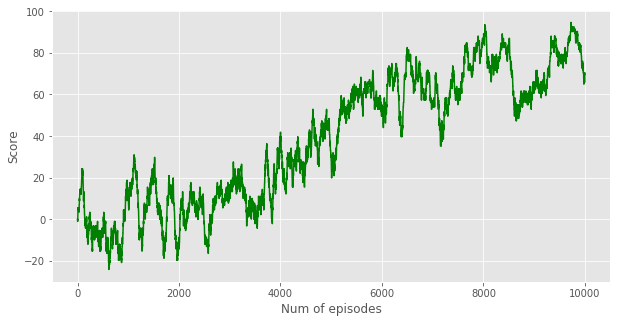

In [14]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_ppo_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [15]:
def watch_agent(goalie, striker, num_episodes=10):
        
    trained_agent_scores_window = deque(maxlen=DEQUE_SIZE)
    trained_agent_scores_window_wins = deque(maxlen=DEQUE_SIZE)

    random_agent_scores_window = deque(maxlen=DEQUE_SIZE)
    random_agent_scores_window_wins = deque(maxlen=DEQUE_SIZE)

    draws = deque(maxlen=DEQUE_SIZE)

    # training loop
    for i_episode in range(1, num_episodes+1):

        env_info = env.reset(train_mode=True)

        goalie_states = env_info[goalie_brain_name].vector_observations
        striker_states = env_info[striker_brain_name].vector_observations

        goalie_scores = np.zeros(len(env_info[goalie_brain_name].agents))
        striker_scores = np.zeros(len(env_info[striker_brain_name].agents))

        while True:

            trained_goalie_action, trained_goalie_log_prob = goalie.act(goalie_states[TRAINED_AGENT_KEY])
            trained_striker_action, trained_striker_log_prob = striker.act(striker_states[TRAINED_AGENT_KEY])

            random_goalie_action = np.asarray([np.random.choice(goalie_action_size)])
            random_striker_action = np.asarray([np.random.choice(striker_action_size)])

            goalie_actions = np.array((trained_goalie_action, random_goalie_action))
            striker_actions = np.array((trained_striker_action, random_striker_action))

            actions = dict(zip([goalie_brain_name, striker_brain_name], [goalie_actions, striker_actions]))

            env_info = env.step(actions)

            # agents get next states
            goalie_next_states = env_info[goalie_brain_name].vector_observations
            striker_next_states = env_info[striker_brain_name].vector_observations

            # agents get rewards
            goalie_rewards = env_info[goalie_brain_name].rewards
            striker_rewards = env_info[striker_brain_name].rewards

            # agents update scores
            goalie_scores += goalie_rewards
            striker_scores += striker_rewards

            # agents roll over states to next states
            goalie_states = goalie_next_states
            striker_states = striker_next_states

            # check if episode finished
            done = np.any(env_info[goalie_brain_name].local_done)
            if done: break

        # agents record scores
        trained_agent_score = goalie_scores[TRAINED_AGENT_KEY] + striker_scores[TRAINED_AGENT_KEY]
        trained_agent_scores_window.append(trained_agent_score)
        trained_agent_scores_window_wins.append(1 if trained_agent_score > 0 else 0)

        random_agent_score = goalie_scores[RANDOM_AGENT_KEY] + striker_scores[RANDOM_AGENT_KEY]
        random_agent_scores_window.append(random_agent_score)
        random_agent_scores_window_wins.append(1 if random_agent_score > 0 else 0)

        draws.append(trained_agent_score == random_agent_score)

        print(f'\rEpisode: {i_episode}')
        print(f'Red Wins: {np.count_nonzero(trained_agent_scores_window_wins)}, Score: {trained_agent_score:.4f}, Average Score: {np.sum(trained_agent_scores_window):.4f}')
        print(f'Blue Wins: {np.count_nonzero(random_agent_scores_window_wins)}, Score: {random_agent_score:.4f}, Average Score: {np.sum(random_agent_scores_window):.4f}')
        print(f'Draws: {np.count_nonzero(draws)}\n')
        
    if np.count_nonzero(trained_agent_scores_window_wins) > np.count_nonzero(random_agent_scores_window_wins):
        print('Red Player Wins!')
    else:
        print('Red Player Loses!')

In [16]:
goalie.load(f'./agents/Actor_{goalie_brain_name}.pth', f'./agents/Critic_{goalie_brain_name}.pth');
striker.load(f'./agents/Actor_{striker_brain_name}.pth', f'./agents/Critic_{striker_brain_name}.pth');

In [17]:
watch_agent(goalie, striker, num_episodes=20)

Episode: 1
Red Wins: 1, Score: 1.1000, Average Score: 1.1000
Blue Wins: 0, Score: -1.1000, Average Score: -1.1000
Draws: 0

Episode: 2
Red Wins: 1, Score: -1.1000, Average Score: 0.0000
Blue Wins: 1, Score: 1.1000, Average Score: -0.0000
Draws: 0

Episode: 3
Red Wins: 2, Score: 1.1000, Average Score: 1.1000
Blue Wins: 1, Score: -1.1000, Average Score: -1.1000
Draws: 0

Episode: 4
Red Wins: 2, Score: -1.1000, Average Score: 0.0000
Blue Wins: 2, Score: 1.1000, Average Score: -0.0000
Draws: 0

Episode: 5
Red Wins: 3, Score: 1.1000, Average Score: 1.1000
Blue Wins: 2, Score: -1.1000, Average Score: -1.1000
Draws: 0

Episode: 6
Red Wins: 3, Score: -1.1000, Average Score: 0.0000
Blue Wins: 3, Score: 1.1000, Average Score: -0.0000
Draws: 0

Episode: 7
Red Wins: 4, Score: 1.1000, Average Score: 1.1000
Blue Wins: 3, Score: -1.1000, Average Score: -1.1000
Draws: 0

Episode: 8
Red Wins: 5, Score: 1.1000, Average Score: 2.2000
Blue Wins: 3, Score: -1.1000, Average Score: -2.2000
Draws: 0

Episode:

---